In [86]:
#from mpi4py import MPI
import numpy as np
import pylab as plt

import VisModel as vm
from VisModel import utils
import uvtools
import hera_cal as hc
from pyuvdata import UVData
from pyuvsim.simsetup import initialize_uvdata_from_keywords

from hera_sim.visibilities import VisCPU, conversions
from hera_sim.beams import PolyBeam, PerturbedPolyBeam
from hera_sim.io import empty_uvdata
import vis_cpu

from astropy.time import Time
import ultranest
import time, copy, sys

In [2]:
def default_cfg():
    """
    Set parameter defaults.
    """
    # Simulation specification
    cfg_spec = dict( nfreq=16,
                     start_freq=1.e8,
                     channel_width=1e6,
                     start_time=2458902.33333,
                     integration_time=40.,
                     ntimes=3,
                     cat_name="gleamegc.dat",
                     apply_gains=True,
                     apply_noise=True,
                     ant_pert=False,
                     seed=None,
                     ant_pert_sigma=0.0,
                     use_legacy_array=False,
                     hex_spec=(3,4), 
                     hex_ants_per_row=None, 
                     hex_ant_sep=14.6,
                     use_ptsrc=True )
                        
    # Diffuse model specification
    cfg_diffuse = dict( use_diffuse=False,
                        nside=64,
                        obs_latitude=-30.7215277777,
                        obs_longitude = 21.4283055554,
                        obs_height = 1073,
                        beam_pol='XX',
                        diffuse_model='GSM',
                        eor_random_seed=42,
                        nprocs=1 )
    
    # Beam model parameters
    cfg_beam = dict( ref_freq=1.e8,
                     spectral_index=-0.6975,
                     #seed=None,
                     perturb_scale=0.0,
                     mainlobe_scale=1.0,
                     xstretch=1.0,
                     ystretch=1.0,
                     rotation=0.0,
                     mainlobe_width=0.3, 
                     beam_coeffs=[ 0.29778665, -0.44821433, 0.27338272, 
                                  -0.10030698, -0.01195859, 0.06063853, 
                                  -0.04593295,  0.0107879,  0.01390283, 
                                  -0.01881641, -0.00177106, 0.01265177, 
                                  -0.00568299, -0.00333975, 0.00452368,
                                   0.00151808, -0.00593812, 0.00351559
                                 ] )
    
    # Fluctuating gain model parameters
    cfg_gain = dict(nmodes=8, seed=None)
    
    # Noise parameters
    cfg_noise = dict(nsamp=1., seed=None, noise_file=None)
    
    # Combine into single dict
    cfg = { 'sim_beam':     cfg_beam,
            'sim_spec':     cfg_spec,
            'sim_diffuse':  cfg_diffuse,
            'sim_noise':    cfg_noise,
            'sim_gain':     cfg_gain,
           }
    return cfg

In [3]:
# Load template configuration
cfg = default_cfg()
cfg_spec = cfg['sim_spec']

# Observation time and location
obstime = Time("2018-08-31T04:02:30.11", format="isot", scale="utc")
hera_lat, hera_lon, hera_alt = -30.7215, 21.4283, 1073.0

# Initialise shape of data and antenna array
ants = utils.build_hex_array(hex_spec=cfg_spec['hex_spec'], 
                             ants_per_row=cfg_spec['hex_ants_per_row'], 
                             d=cfg_spec['hex_ant_sep'])


#uvd_init = utils.empty_uvdata(array_layout=ants, **cfg_spec)
uvd_init = initialize_uvdata_from_keywords(array_layout=ants,
                                           telescope_name="test_array",
                                           x_orientation="east",
                                           phase_type="drift",
                                           vis_units="Jy",
                                           complete=True,
                                           write_files=False,
                                           polarization_array=np.array(["XX",]),
                                           telescope_location=(hera_lat, hera_lon, hera_alt),
                                           Nfreqs=cfg_spec['nfreq'],
                                           start_freq=cfg_spec['start_freq'],
                                           start_time=obstime.jd,
                                           integration_time=cfg_spec['integration_time'],
                                           Ntimes=cfg_spec['ntimes'],
                                           channel_width=cfg_spec['channel_width'],
                                           )

# Point source catalogue
ra_dec, flux = utils.load_ptsrc_catalog('/home/phil/hera/non-redundant-pipeline/catBC.txt', 
                                        freq0=100e6, freqs=np.unique(uvd_init.freq_array), 
                                        usecols=(0,1,2,3))

In [84]:
# Sort by flux
idxs = np.argsort(flux[0,:])[::-1]
flux_sorted = flux[:,idxs]
ra_dec_sorted = ra_dec[idxs,:]

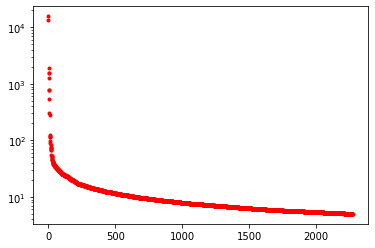

In [79]:
plt.plot(flux_sorted[0,:], 'r.')
plt.yscale('log')
#ra_dec[:100], flux[:,:100]

In [22]:
model = vm.VisModel(uvd_init, 
                    ra_dec[:100], flux[:,:100],
                    beam_model=PerturbedPolyBeam, 
                    default_beam_params=cfg['sim_beam'],
                    free_params_antpos=['antpos_dx', 'antpos_dy'], 
                    free_params_beam=['xstretch', 'ystretch', 'spectral_index'], 
                    free_params_ptsrc=['delta_ra', 'delta_dec', 'flux_factor'],
                    free_ants=np.arange(10),
                    free_beams=np.arange(10),
                    free_ptsrcs=np.arange(100),
                    comm=None)

In [ ]:
# Combine into initial parameter vector
#pnamesX = modelX.param_names()
#init_valsX = np.concatenate((init_antposX, init_beamsX, init_ptsrcX))

In [5]:
uvd_init.antenna_numbers

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

30

In [24]:
# Initial values
init_beams  = np.ones(len(model.free_beams) * len(model.free_params_beam))
init_beams[2::3] *= -0.6975

init_antpos = np.zeros(len(model.free_ants) * len(model.free_params_antpos))
init_ptsrc = np.array([0.,0.,1.]*len(model.free_ptsrcs))

init_vals = np.concatenate((init_antpos, init_beams, init_ptsrc))
print(init_vals)
print(model.param_names())

[ 0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      1.      1.     -0.6975  1.      1.     -0.6975  1.
  1.     -0.6975  1.      1.     -0.6975  1.      1.     -0.6975  1.
  1.     -0.6975  1.      1.     -0.6975  1.      1.     -0.6975  1.
  1.     -0.6975  1.      1.     -0.6975  0.      0.      1.      0.
  0.      1.      0.      0.      1.      0.      0.      1.      0.
  0.      1.      0.      0.      1.      0.      0.      1.      0.
  0.      1.      0.      0.      1.      0.      0.      1.      0.
  0.      1.      0.      0.      1.      0.      0.      1.      0.
  0.      1.      0.      0.      1.      0.      0.      1.      0.
  0.      1.      0.      0.      1.      0.      0.      1.      0.
  0.      1.      0.      0.      1.      0.      0.      1.      0.
  0.      1.      0.      0.      1.      0.      0.      1.      0.
  0.      1.      0.      0.      

In [26]:
model.model(init_vals)
model.uvd.get_data((0,1))

array([[-6.13890349-24.28591995j, -6.0606025 -23.76650467j,
        -5.98732009-23.2447876j , -5.92147052-22.72307324j,
        -5.86541788-22.20290355j, -5.82128368-21.68513303j,
        -5.79079351-21.17004322j, -5.77516796-20.65748243j,
        -5.77505945-20.14701784j, -5.79053424-19.63808824j,
        -5.82109652-19.13014712j, -5.86574975-18.62278712j,
        -5.92308843-18.11583858j, -5.99141225-17.60943685j,
        -6.0688535 -17.10405546j, -6.15350795-16.60050427j],
       [-7.87881581-23.82828735j, -7.75965724-23.30342156j,
        -7.64476346-22.77514463j, -7.53668707-22.24574462j,
        -7.43792136-21.71675489j, -7.35071003-21.18902973j,
        -7.27689553-20.66285839j, -7.21781085-20.13810406j,
        -7.17421642-19.6143552j , -7.14628161-19.09107779j,
        -7.1336078 -18.56775829j, -7.13528871-18.04402847j,
        -7.15000122-17.51976459j, -7.17611902-16.99515563j,
        -7.21183994-16.47073706j, -7.2553173 -15.94738933j],
       [-9.58077095-23.24491575j, -9.4

## Fisher matrix

In [27]:
F1 = vm.calc_fisher(model, fiducial=init_vals, var=0.5, dx=0.01, verbose=True)

0 / 350
1 / 350
2 / 350
3 / 350
4 / 350
5 / 350
6 / 350
7 / 350
8 / 350
9 / 350
10 / 350
11 / 350
12 / 350
13 / 350
14 / 350
15 / 350
16 / 350
17 / 350
18 / 350
19 / 350
20 / 350
21 / 350
22 / 350
23 / 350
24 / 350
25 / 350
26 / 350
27 / 350
28 / 350
29 / 350
30 / 350
31 / 350
32 / 350
33 / 350
34 / 350
35 / 350
36 / 350
37 / 350
38 / 350
39 / 350
40 / 350
41 / 350
42 / 350
43 / 350
44 / 350
45 / 350
46 / 350
47 / 350
48 / 350
49 / 350
50 / 350
51 / 350
52 / 350
53 / 350
54 / 350
55 / 350
56 / 350
57 / 350
58 / 350
59 / 350
60 / 350
61 / 350
62 / 350
63 / 350
64 / 350
65 / 350
66 / 350
67 / 350
68 / 350
69 / 350
70 / 350
71 / 350
72 / 350
73 / 350
74 / 350
75 / 350
76 / 350
77 / 350
78 / 350
79 / 350
80 / 350
81 / 350
82 / 350
83 / 350
84 / 350
85 / 350
86 / 350
87 / 350
88 / 350
89 / 350
90 / 350
91 / 350
92 / 350
93 / 350
94 / 350
95 / 350
96 / 350
97 / 350
98 / 350
99 / 350
100 / 350
101 / 350
102 / 350
103 / 350
104 / 350
105 / 350
106 / 350
107 / 350
108 / 350
109 / 350
110 / 350


In [28]:
# Build Fisher prior
priors_fisher = {
    'antpos_dx':        0.05,
    'antpos_dy':        0.05,
    'antpos_dz':        0.05,
    'mainlobe_scale':  0.10,
    'xstretch':        0.10,
    'ystretch':        0.10,
    'spectral_index':  0.10,
    'delta_ra':        0.10,
    'delta_dec':       0.10,
    'flux_factor':     0.05,
}

Fp1 = vm.fisher_prior(model.param_names(), priors_fisher)

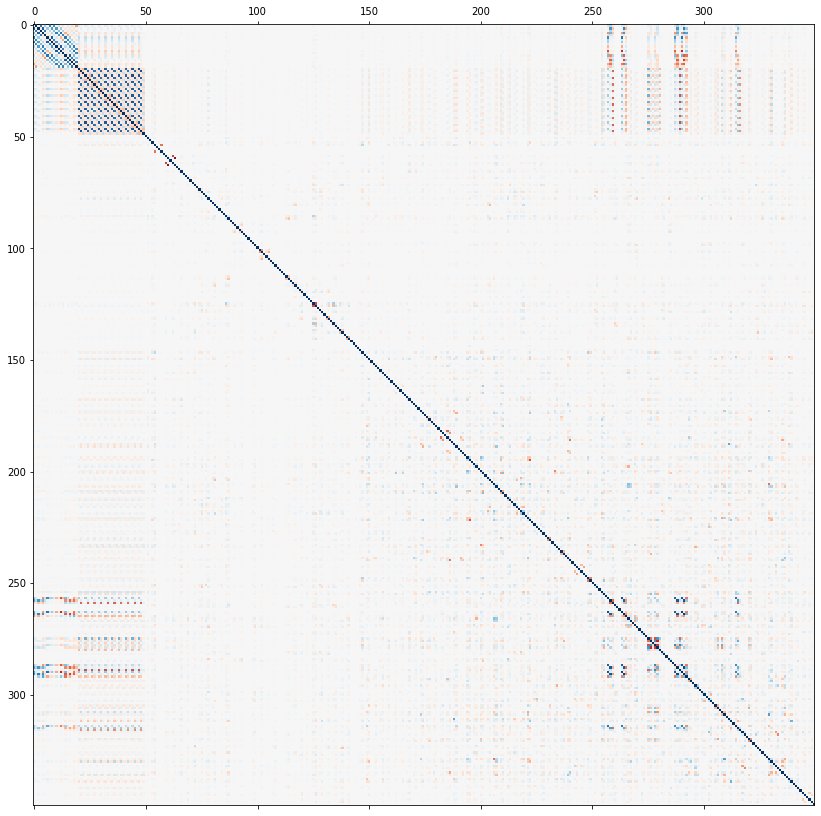

In [31]:
def corrmat(m):
    rho = np.zeros(m.shape)
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            rho[i,j] = m[i,j] / np.sqrt(m[i,i]*m[j,j])
    return rho

C1 = np.linalg.inv(F1 + Fp1)
plt.matshow(corrmat(C1), cmap='RdBu', vmin=-1., vmax=1.)
plt.gcf().set_size_inches((14., 14.))

In [21]:
model.param_names()

['antpos_dx_000',
 'antpos_dy_000',
 'antpos_dx_001',
 'antpos_dy_001',
 'antpos_dx_002',
 'antpos_dy_002',
 'antpos_dx_003',
 'antpos_dy_003',
 'antpos_dx_004',
 'antpos_dy_004',
 'antpos_dx_005',
 'antpos_dy_005',
 'antpos_dx_006',
 'antpos_dy_006',
 'antpos_dx_007',
 'antpos_dy_007',
 'antpos_dx_008',
 'antpos_dy_008',
 'antpos_dx_009',
 'antpos_dy_009',
 'mainlobe_scale_000',
 'mainlobe_scale_001',
 'mainlobe_scale_002',
 'mainlobe_scale_003',
 'mainlobe_scale_004',
 'mainlobe_scale_005',
 'mainlobe_scale_006',
 'mainlobe_scale_007',
 'mainlobe_scale_008',
 'mainlobe_scale_009']

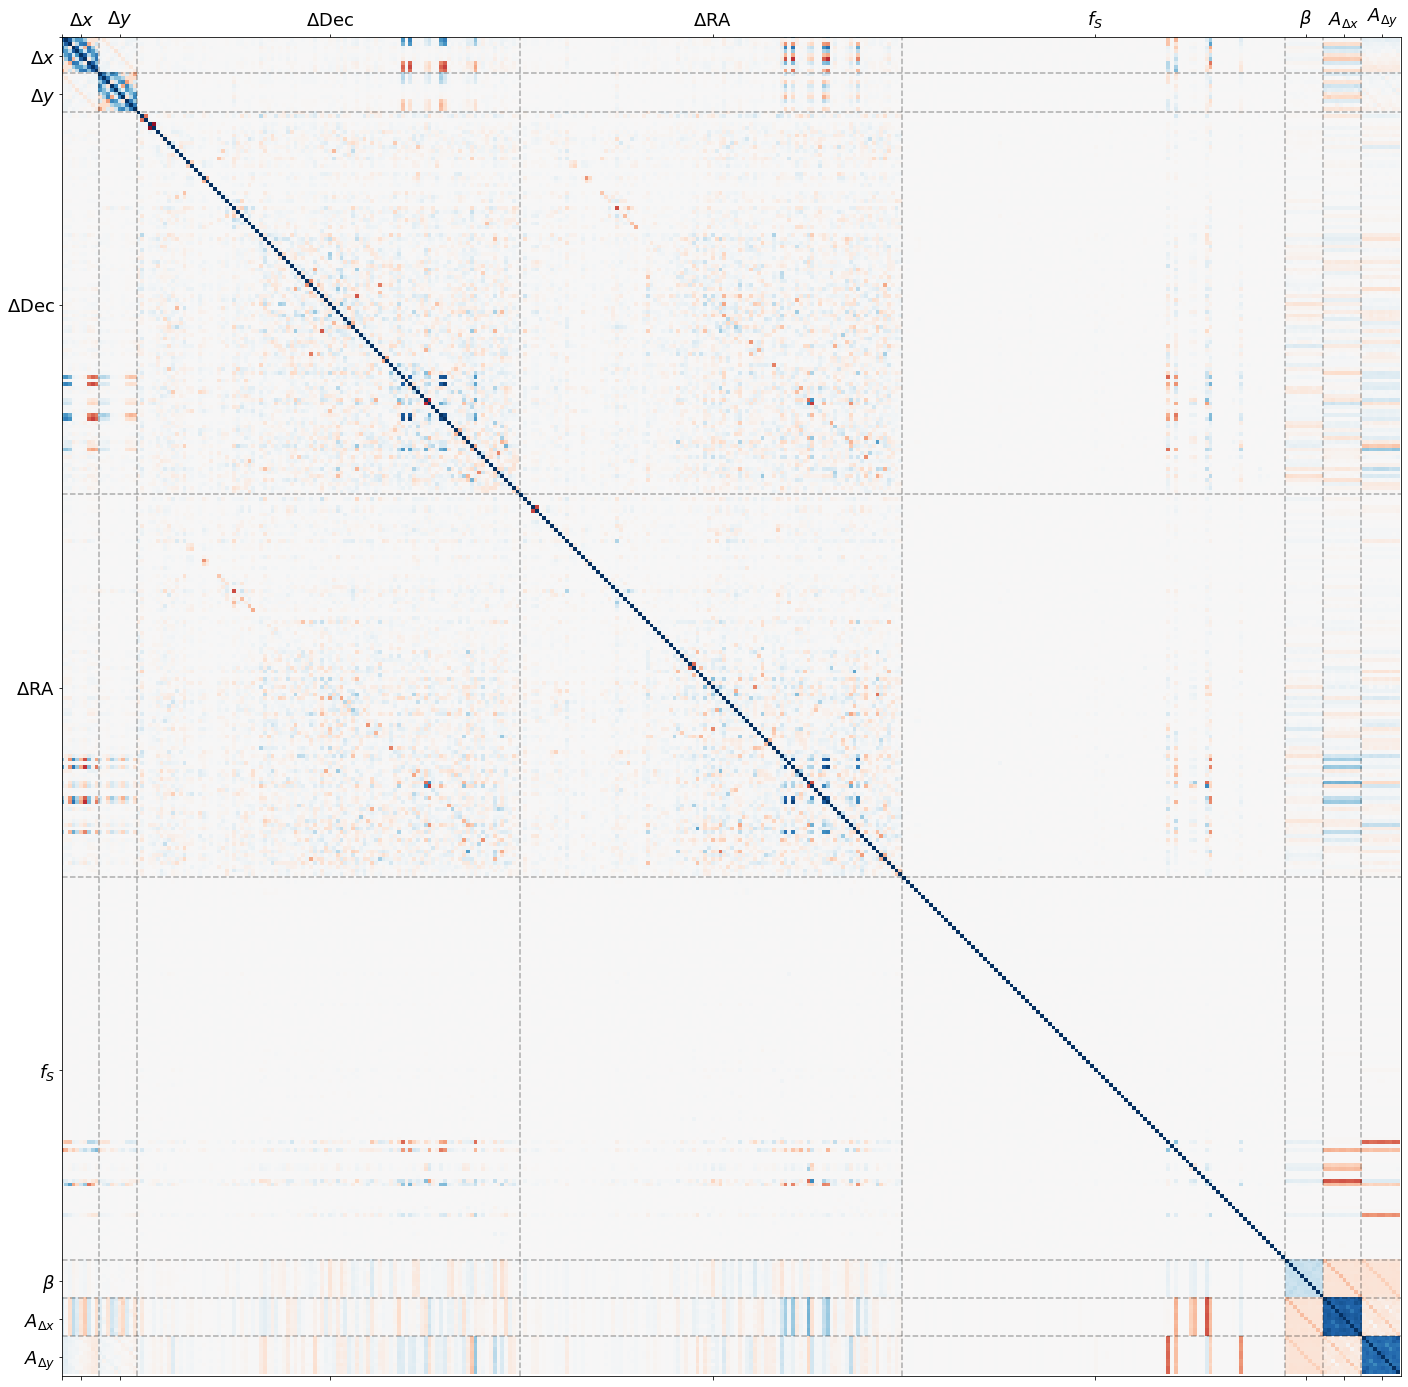

In [134]:
def reorder_matrix(pnames, mat):
    """
    Reorder the rows and columns of a matrix
    """
    # Get indices that would sort the matrix
    idxs = np.argsort(pnames)
    new_pnames = np.array(pnames)[idxs]
    
    # Reorder rows and columns into new matrix
    new_mat = np.zeros_like(mat)
    new_mat[:,:] = mat[idxs,:][:,idxs]
    
    # Test that reordering went correctly
    #for i, pi in enumerate(pnames):
    #    for j, pj in enumerate(pnames):
    #        ii = np.where(new_pnames == pi)
    #        jj = np.where(new_pnames == pj)
    #        assert mat[i,j] == new_mat[ii,jj]
    
    return new_pnames, new_mat

newp, newC = reorder_matrix(model.param_names(), C1)


#for i, p in enumerate(newp):
#    print("%03d  %s" % (i, p))

plt.matshow(corrmat(newC), cmap='RdBu', vmin=-1., vmax=1.)

bnames = [r'$\Delta x$', r'$\Delta y$', r'$\Delta {\rm Dec}}$', r'$\Delta {\rm RA}$', 
          r'$f_S$', r'$\beta$', '$A_{\Delta x}$', '$A_{\Delta y}$', '']
blocks = [9.5, 19.5, 119.5, 219.5, 319.5, 329.5, 339.5]
for b in blocks:
    plt.axhline(b, color='k', ls='dashed', alpha=0.3)
    plt.axvline(b, color='k', ls='dashed', alpha=0.3)

block_lbls = [0., 5., 15., 70., 170., 270., 325., 335., 345.]
ax = plt.gca()
ax.set_xticks(block_lbls)
ax.set_yticks(block_lbls)
ax.set_xticklabels(["",] + bnames, fontsize=18)
ax.set_yticklabels(["",] + bnames, fontsize=18)

ax.set_xlim((0., newC.shape[0]))
ax.set_ylim((newC.shape[0], 0.))

plt.gcf().set_size_inches((24., 24.))

In [117]:
def source_az_za(lsts, ra, dec, latitude, orientation="uvbeam", periodic_azimuth=False):
    """
    Get the azimuth and zenith angle for a set of sources as a function of LST.
    
    Parameters
    ----------
    lsts : array_like
        1D array of LST values.
    
    ra, dec : array_like
        1D arrays of RA and Dec values for the sources.
    
    latitude : float
        Latitude of the observing site, in radians.
    
    orientation : str, optional
        Orientation convention used for the azimuth angle. The default is
        ``'astropy'``. See ``vis_cpu.conversions.enu_to_az_za`` for more 
        information.

    periodic_azimuth : bool, optional
        if True, constrain az to be betwee 0 and 2 * pi. See 
        ``vis_cpu.conversions.enu_to_az_za`` for more information.
    
    Returns
    -------
    az, za : array_like
        Azimuth and zenith angle for each source as a fucntion of LST.
    """
    # Get equatorial to topocentric coordinate transforms as a function of LST
    eq2tops = np.array([vis_cpu.conversions.eci_to_enu_matrix(lst, latitude) for lst in lsts])

    # Source coordinate transform, from equatorial to Cartesian
    crd_eq = vis_cpu.conversions.point_source_crd_eq(ra, dec)
    
    # Get the azimuth and zenith angle for each source vs LST
    az = []
    za = []
    for eq2top in eq2tops:
        tx, ty, tz = crd_top = np.dot(eq2top, crd_eq)
        _az, _za = vis_cpu.conversions.enu_to_az_za(enu_e=tx, enu_n=ty, 
                                                  orientation=orientation, 
                                                  periodic_azimuth=periodic_azimuth)
        
        _za[np.where(tz < 0.)] = np.pi - _za[np.where(tz < 0.)]
        az.append(_az)
        za.append(_za)
    return np.array(az), np.array(za)


_lsts = np.linspace(0., 2.*np.pi, 201)
az, za = source_az_za(lsts=_lsts, 
                      ra=ra_dec_sorted[:200,0], 
                      dec=ra_dec_sorted[:200,1], 
                      latitude=-30.7215 * np.pi / 180.0)
az.shape

(201, 200)

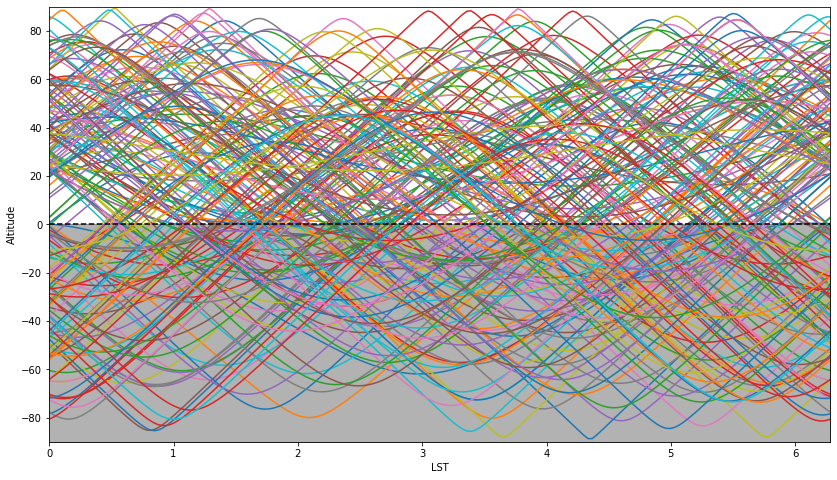

In [118]:
plt.plot(_lsts, (np.pi/2. - za)*180./np.pi, ls='solid', lw=1.5)
plt.fill_between([0., 2.*np.pi], [-90., -90.], [0., 0.], color='k', alpha=0.3)
plt.axhline(0., color='k', ls='dashed')

plt.ylim(-90., 90.)
plt.xlim((0., 2.*np.pi))
plt.ylabel("Altitude")
plt.xlabel("LST")
plt.gcf().set_size_inches((14., 8.))

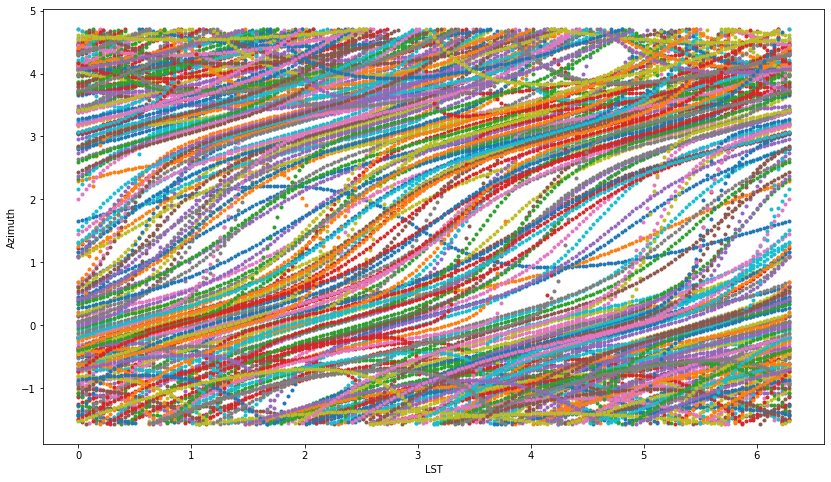

In [119]:
plt.plot(_lsts, az, marker='.', ls='none')
plt.ylabel("Azimuth")
plt.xlabel("LST")
plt.gcf().set_size_inches((14., 8.))

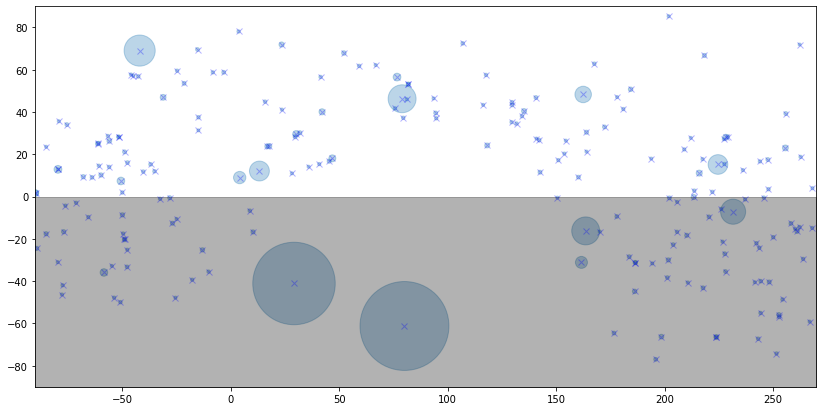

In [142]:
ii = 100
plt.scatter(az[ii]*180./np.pi, (0.5*np.pi - za[ii])*180./np.pi, s=0.5*flux_sorted[0,:200], alpha=0.3)
plt.plot(az[ii]*180./np.pi, (0.5*np.pi - za[ii])*180./np.pi, 'bx', alpha=0.3)
plt.fill_between([-90., 270.], [-90., -90.], [0., 0.], color='k', alpha=0.3)

plt.ylim(-90., 90.)
plt.xlim(-90., 270.)
plt.gcf().set_size_inches((14., 7.))

In [121]:
from matplotlib import animation, rc
from IPython.display import HTML

def animate_field(field, coords, coord_fmt="%3.1f MHz", interval=200, 
                  fig=None, colorbar=True):
    """
    Draw an animation that steps through slices of a field. The last dimension 
    of the field is the one that will be stepped through.
    
    Parameters:
        field (array_like):
            3D array of value of a field that can be displayed by 
            `matplotlib.matshow`.
        
        coords (array_like):
            1D array labelling the coordinates that are being stepped through. This 
            will be displayed as a title on each frame of the animation.
        
        coord_fmt (str, optional):
            The format string for the coordinate values.
        
        interval (int, optional):
            Interval between frames, in ms.
        
        fig (matplotlib.Figure, optional):
            Existing Figure to put animation on. Default: None (will create a new 
            Figure).
        
        colorbar (bool, optional):
            Whether to add a `matplotlib.colorbar` to the figure.
        
    Returns:
        animation (HTML5 video):
            Animation as an HTML5 video.
    """
    # Initialise figure
    if fig is None:
        fig, ax = plt.subplots()
    else:
        ax = fig.gca()
    
    # Plot initial field and get data ranges
    vmin, vmax = np.min(field), np.max(field)
    im = plt.matshow(field[:,:,0], vmin=vmin, vmax=vmax, 
                     fignum=False)
    cbar = fig.colorbar(im)
    
    def animate(i):
        im.set_data(field[:,:,i])
        ax.set_title(coord_fmt % (coords[i]))
        return (im,)

    def init():
        im.set_data(field[:,:,0])
        ax.set_title(coord_fmt % (coords[0]))
        return (im,)
    
    # Make animation
    anim = animation.FuncAnimation(fig, animate, 
                                   init_func=init,
                                   frames=field.shape[-1], 
                                   interval=interval, 
                                   blit=True)
    return HTML(anim.to_html5_video())

(16, 2273)

## Optimisation

In [143]:
# Generate model + noise
np.random.seed(7)
var = 0.5
data = copy.deepcopy(model.model(init_vals))
#print(data.data_array)
data.data_array += np.sqrt(var) \
                     * (  1.0*np.random.randn(*data.data_array.shape) 
                        + 1.j*0.*np.random.randn(*data.data_array.shape) ) # FIXME

# Create likelihood handler object
like = vm.VisLike(data, model, var=var)

In [160]:
pnames = model.param_names()
def likefn(p):
    logl = like.logl(p)
    print("logl = %3.8e" % logl, p[:5])
    return -logl
#prior = lambda cube: like.prior_cube(cube, init_vals)

In [161]:
from scipy.optimize import minimize

In [162]:
opt = minimize(likefn, init_vals, method='BFGS', options={'disp': True}, tol=1e-4)

logl = -1.30278078e+03 [0. 0. 0. 0. 0.]
logl = -1.30278079e+03 [1.49011612e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
logl = -1.30278078e+03 [0.00000000e+00 1.49011612e-08 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
logl = -1.30278080e+03 [0.00000000e+00 0.00000000e+00 1.49011612e-08 0.00000000e+00
 0.00000000e+00]
logl = -1.30278079e+03 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.49011612e-08
 0.00000000e+00]
logl = -1.30278079e+03 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.49011612e-08]
logl = -1.30278079e+03 [0. 0. 0. 0. 0.]
logl = -1.30278078e+03 [0. 0. 0. 0. 0.]
logl = -1.30278078e+03 [0. 0. 0. 0. 0.]
logl = -1.30278078e+03 [0. 0. 0. 0. 0.]
logl = -1.30278078e+03 [0. 0. 0. 0. 0.]
logl = -1.30278079e+03 [0. 0. 0. 0. 0.]
logl = -1.30278079e+03 [0. 0. 0. 0. 0.]
logl = -1.30278079e+03 [0. 0. 0. 0. 0.]
logl = -1.30278079e+03 [0. 0. 0. 0. 0.]
logl = -1.30278079e+03 [0. 0. 0. 0. 0.]
logl = -1.30278079e+03 [0. 0. 0. 0. 0.]
logl = -1.30278

logl = -1.30278078e+03 [0. 0. 0. 0. 0.]
logl = -1.30278078e+03 [0. 0. 0. 0. 0.]
logl = -1.30278078e+03 [0. 0. 0. 0. 0.]
logl = -1.30278078e+03 [0. 0. 0. 0. 0.]
logl = -1.30278078e+03 [0. 0. 0. 0. 0.]
logl = -1.30278078e+03 [0. 0. 0. 0. 0.]
logl = -1.30278078e+03 [0. 0. 0. 0. 0.]
logl = -1.30278078e+03 [0. 0. 0. 0. 0.]
logl = -1.30278078e+03 [0. 0. 0. 0. 0.]
logl = -1.30278078e+03 [0. 0. 0. 0. 0.]
logl = -1.30278079e+03 [0. 0. 0. 0. 0.]
logl = -1.30278078e+03 [0. 0. 0. 0. 0.]
logl = -1.30278078e+03 [0. 0. 0. 0. 0.]
logl = -1.30278078e+03 [0. 0. 0. 0. 0.]
logl = -1.30278078e+03 [0. 0. 0. 0. 0.]
logl = -1.30278078e+03 [0. 0. 0. 0. 0.]
logl = -1.30278079e+03 [0. 0. 0. 0. 0.]
logl = -1.30278078e+03 [0. 0. 0. 0. 0.]
logl = -1.30278078e+03 [0. 0. 0. 0. 0.]
logl = -1.30278078e+03 [0. 0. 0. 0. 0.]
logl = -1.30278078e+03 [0. 0. 0. 0. 0.]
logl = -1.30278078e+03 [0. 0. 0. 0. 0.]
logl = -1.30278079e+03 [0. 0. 0. 0. 0.]
logl = -1.30278078e+03 [0. 0. 0. 0. 0.]
logl = -1.30278079e+03 [0. 0. 0. 0. 0.]


logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01

logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01

logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01

logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01064926 -0.0161634 ]
logl = -1.08783403e+06 [-0.00339438  0.0025964  -0.0197923  -0.01

logl = -8.04066033e+03 [-1.93211977e-05  1.47790136e-05 -1.12660008e-04 -6.06167756e-05
 -9.20038698e-05]
logl = -8.04066033e+03 [-1.93211977e-05  1.47790136e-05 -1.12660008e-04 -6.06167756e-05
 -9.20038698e-05]
logl = -8.04066035e+03 [-1.93211977e-05  1.47790136e-05 -1.12660008e-04 -6.06167756e-05
 -9.20038698e-05]
logl = -8.04066033e+03 [-1.93211977e-05  1.47790136e-05 -1.12660008e-04 -6.06167756e-05
 -9.20038698e-05]
logl = -8.04066033e+03 [-1.93211977e-05  1.47790136e-05 -1.12660008e-04 -6.06167756e-05
 -9.20038698e-05]
logl = -8.04066034e+03 [-1.93211977e-05  1.47790136e-05 -1.12660008e-04 -6.06167756e-05
 -9.20038698e-05]
logl = -8.04066033e+03 [-1.93211977e-05  1.47790136e-05 -1.12660008e-04 -6.06167756e-05
 -9.20038698e-05]
logl = -8.04066033e+03 [-1.93211977e-05  1.47790136e-05 -1.12660008e-04 -6.06167756e-05
 -9.20038698e-05]
logl = -8.04066034e+03 [-1.93211977e-05  1.47790136e-05 -1.12660008e-04 -6.06167756e-05
 -9.20038698e-05]
logl = -8.04066033e+03 [-1.93211977e-05  1.477

logl = -8.04066034e+03 [-1.93211977e-05  1.47790136e-05 -1.12660008e-04 -6.06167756e-05
 -9.20038698e-05]
logl = -8.04066034e+03 [-1.93211977e-05  1.47790136e-05 -1.12660008e-04 -6.06167756e-05
 -9.20038698e-05]
logl = -8.04066033e+03 [-1.93211977e-05  1.47790136e-05 -1.12660008e-04 -6.06167756e-05
 -9.20038698e-05]
logl = -8.04066033e+03 [-1.93211977e-05  1.47790136e-05 -1.12660008e-04 -6.06167756e-05
 -9.20038698e-05]
logl = -8.04066033e+03 [-1.93211977e-05  1.47790136e-05 -1.12660008e-04 -6.06167756e-05
 -9.20038698e-05]
logl = -8.04066033e+03 [-1.93211977e-05  1.47790136e-05 -1.12660008e-04 -6.06167756e-05
 -9.20038698e-05]
logl = -8.04066033e+03 [-1.93211977e-05  1.47790136e-05 -1.12660008e-04 -6.06167756e-05
 -9.20038698e-05]
logl = -8.04066033e+03 [-1.93211977e-05  1.47790136e-05 -1.12660008e-04 -6.06167756e-05
 -9.20038698e-05]
logl = -8.04066033e+03 [-1.93211977e-05  1.47790136e-05 -1.12660008e-04 -6.06167756e-05
 -9.20038698e-05]
logl = -8.04066033e+03 [-1.93211977e-05  1.477

logl = -8.04066034e+03 [-1.93211977e-05  1.47790136e-05 -1.12660008e-04 -6.06167756e-05
 -9.20038698e-05]
logl = -8.04066034e+03 [-1.93211977e-05  1.47790136e-05 -1.12660008e-04 -6.06167756e-05
 -9.20038698e-05]
logl = -8.04066033e+03 [-1.93211977e-05  1.47790136e-05 -1.12660008e-04 -6.06167756e-05
 -9.20038698e-05]
logl = -8.04066033e+03 [-1.93211977e-05  1.47790136e-05 -1.12660008e-04 -6.06167756e-05
 -9.20038698e-05]
logl = -8.04066033e+03 [-1.93211977e-05  1.47790136e-05 -1.12660008e-04 -6.06167756e-05
 -9.20038698e-05]
logl = -8.04066033e+03 [-1.93211977e-05  1.47790136e-05 -1.12660008e-04 -6.06167756e-05
 -9.20038698e-05]
logl = -8.04066033e+03 [-1.93211977e-05  1.47790136e-05 -1.12660008e-04 -6.06167756e-05
 -9.20038698e-05]
logl = -8.04066033e+03 [-1.93211977e-05  1.47790136e-05 -1.12660008e-04 -6.06167756e-05
 -9.20038698e-05]
logl = -8.04066033e+03 [-1.93211977e-05  1.47790136e-05 -1.12660008e-04 -6.06167756e-05
 -9.20038698e-05]
logl = -8.04066033e+03 [-1.93211977e-05  1.477

logl = -8.04063943e+03 [-1.93211977e-05  1.47790136e-05 -1.12660008e-04 -6.06167756e-05
 -9.20038698e-05]
logl = -8.04067335e+03 [-1.93211977e-05  1.47790136e-05 -1.12660008e-04 -6.06167756e-05
 -9.20038698e-05]
logl = -8.04066047e+03 [-1.93211977e-05  1.47790136e-05 -1.12660008e-04 -6.06167756e-05
 -9.20038698e-05]
logl = -8.04064837e+03 [-1.93211977e-05  1.47790136e-05 -1.12660008e-04 -6.06167756e-05
 -9.20038698e-05]
logl = -8.04068278e+03 [-1.93211977e-05  1.47790136e-05 -1.12660008e-04 -6.06167756e-05
 -9.20038698e-05]
logl = -8.04066028e+03 [-1.93211977e-05  1.47790136e-05 -1.12660008e-04 -6.06167756e-05
 -9.20038698e-05]
logl = -8.04066033e+03 [-1.93211977e-05  1.47790136e-05 -1.12660008e-04 -6.06167756e-05
 -9.20038698e-05]
logl = -8.04066034e+03 [-1.93211977e-05  1.47790136e-05 -1.12660008e-04 -6.06167756e-05
 -9.20038698e-05]
logl = -8.04066033e+03 [-1.93211977e-05  1.47790136e-05 -1.12660008e-04 -6.06167756e-05
 -9.20038698e-05]
logl = -8.04066034e+03 [-1.93211977e-05  1.477

logl = -1.30121451e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121449e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121449e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121450e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121450e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121451e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121450e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121450e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121452e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121451e+03 [-2.89370963e-07  2.213

logl = -1.30121450e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121450e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121450e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121450e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121450e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121450e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121450e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121450e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121450e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121450e+03 [-2.89370963e-07  2.213

logl = -1.30121450e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121450e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121450e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121450e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121450e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121450e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121450e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121450e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121450e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121450e+03 [-2.89370963e-07  2.213

logl = -1.30121450e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121450e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121450e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121450e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121450e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121450e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121450e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121440e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121440e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121451e+03 [-2.89370963e-07  2.213

logl = -1.30121450e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121450e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121449e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121450e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121450e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121450e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121450e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121450e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121450e+03 [-2.89370963e-07  2.21343286e-07 -1.68729370e-06 -9.07849242e-07
 -1.37792950e-06]
logl = -1.30121450e+03 [-2.89370963e-07  2.213

logl = -1.30161756e+03 [ 1.85302354e-06  2.72015592e-06 -5.17758395e-06 -3.63993640e-06
 -1.43877307e-06]
logl = -1.30161756e+03 [ 1.85302354e-06  2.72015592e-06 -5.17758395e-06 -3.63993640e-06
 -1.43877307e-06]
logl = -1.30161756e+03 [ 1.85302354e-06  2.72015592e-06 -5.17758395e-06 -3.63993640e-06
 -1.43877307e-06]
logl = -1.30161756e+03 [ 1.85302354e-06  2.72015592e-06 -5.17758395e-06 -3.63993640e-06
 -1.43877307e-06]
logl = -1.30161756e+03 [ 1.85302354e-06  2.72015592e-06 -5.17758395e-06 -3.63993640e-06
 -1.43877307e-06]
logl = -1.30161756e+03 [ 1.85302354e-06  2.72015592e-06 -5.17758395e-06 -3.63993640e-06
 -1.43877307e-06]
logl = -1.30161756e+03 [ 1.85302354e-06  2.72015592e-06 -5.17758395e-06 -3.63993640e-06
 -1.43877307e-06]
logl = -1.30161756e+03 [ 1.85302354e-06  2.72015592e-06 -5.17758395e-06 -3.63993640e-06
 -1.43877307e-06]
logl = -1.30161756e+03 [ 1.85302354e-06  2.72015592e-06 -5.17758395e-06 -3.63993640e-06
 -1.43877307e-06]
logl = -1.30161756e+03 [ 1.85302354e-06  2.720

logl = -1.30161756e+03 [ 1.85302354e-06  2.72015592e-06 -5.17758395e-06 -3.63993640e-06
 -1.43877307e-06]
logl = -1.30161756e+03 [ 1.85302354e-06  2.72015592e-06 -5.17758395e-06 -3.63993640e-06
 -1.43877307e-06]
logl = -1.30161756e+03 [ 1.85302354e-06  2.72015592e-06 -5.17758395e-06 -3.63993640e-06
 -1.43877307e-06]
logl = -1.30161756e+03 [ 1.85302354e-06  2.72015592e-06 -5.17758395e-06 -3.63993640e-06
 -1.43877307e-06]
logl = -1.30161756e+03 [ 1.85302354e-06  2.72015592e-06 -5.17758395e-06 -3.63993640e-06
 -1.43877307e-06]
logl = -1.30161756e+03 [ 1.85302354e-06  2.72015592e-06 -5.17758395e-06 -3.63993640e-06
 -1.43877307e-06]
logl = -1.30161756e+03 [ 1.85302354e-06  2.72015592e-06 -5.17758395e-06 -3.63993640e-06
 -1.43877307e-06]
logl = -1.30161756e+03 [ 1.85302354e-06  2.72015592e-06 -5.17758395e-06 -3.63993640e-06
 -1.43877307e-06]
logl = -1.30161756e+03 [ 1.85302354e-06  2.72015592e-06 -5.17758395e-06 -3.63993640e-06
 -1.43877307e-06]
logl = -1.30161756e+03 [ 1.85302354e-06  2.720

logl = -1.30161756e+03 [ 1.85302354e-06  2.72015592e-06 -5.17758395e-06 -3.63993640e-06
 -1.43877307e-06]
logl = -1.30161756e+03 [ 1.85302354e-06  2.72015592e-06 -5.17758395e-06 -3.63993640e-06
 -1.43877307e-06]
logl = -1.30161756e+03 [ 1.85302354e-06  2.72015592e-06 -5.17758395e-06 -3.63993640e-06
 -1.43877307e-06]
logl = -1.30161756e+03 [ 1.85302354e-06  2.72015592e-06 -5.17758395e-06 -3.63993640e-06
 -1.43877307e-06]
logl = -1.30161756e+03 [ 1.85302354e-06  2.72015592e-06 -5.17758395e-06 -3.63993640e-06
 -1.43877307e-06]
logl = -1.30161756e+03 [ 1.85302354e-06  2.72015592e-06 -5.17758395e-06 -3.63993640e-06
 -1.43877307e-06]
logl = -1.30161756e+03 [ 1.85302354e-06  2.72015592e-06 -5.17758395e-06 -3.63993640e-06
 -1.43877307e-06]
logl = -1.30161756e+03 [ 1.85302354e-06  2.72015592e-06 -5.17758395e-06 -3.63993640e-06
 -1.43877307e-06]
logl = -1.30161756e+03 [ 1.85302354e-06  2.72015592e-06 -5.17758395e-06 -3.63993640e-06
 -1.43877307e-06]
logl = -1.30161756e+03 [ 1.85302354e-06  2.720

logl = -1.30161756e+03 [ 1.85302354e-06  2.72015592e-06 -5.17758395e-06 -3.63993640e-06
 -1.43877307e-06]
logl = -1.30161814e+03 [ 1.85302354e-06  2.72015592e-06 -5.17758395e-06 -3.63993640e-06
 -1.43877307e-06]
logl = -1.30161741e+03 [ 1.85302354e-06  2.72015592e-06 -5.17758395e-06 -3.63993640e-06
 -1.43877307e-06]
logl = -1.30161758e+03 [ 1.85302354e-06  2.72015592e-06 -5.17758395e-06 -3.63993640e-06
 -1.43877307e-06]
logl = -1.30161756e+03 [ 1.85302354e-06  2.72015592e-06 -5.17758395e-06 -3.63993640e-06
 -1.43877307e-06]
logl = -1.30161756e+03 [ 1.85302354e-06  2.72015592e-06 -5.17758395e-06 -3.63993640e-06
 -1.43877307e-06]
logl = -1.30161756e+03 [ 1.85302354e-06  2.72015592e-06 -5.17758395e-06 -3.63993640e-06
 -1.43877307e-06]
logl = -1.30161756e+03 [ 1.85302354e-06  2.72015592e-06 -5.17758395e-06 -3.63993640e-06
 -1.43877307e-06]
logl = -1.30161756e+03 [ 1.85302354e-06  2.72015592e-06 -5.17758395e-06 -3.63993640e-06
 -1.43877307e-06]
logl = -1.30161756e+03 [ 1.85302354e-06  2.720

logl = -1.30051290e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051291e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051292e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051292e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051292e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051292e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051292e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051293e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051292e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051292e+03 [ 6.60765933e-07  1.329

logl = -1.30051292e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051292e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051292e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051292e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051292e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051292e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051292e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051292e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051291e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051292e+03 [ 6.60765933e-07  1.329

logl = -1.30051292e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051292e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051292e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051292e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051292e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051292e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051292e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051292e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051292e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051292e+03 [ 6.60765933e-07  1.329

logl = -1.30051292e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051292e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051292e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051292e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051291e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051291e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051292e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051291e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051287e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051292e+03 [ 6.60765933e-07  1.329

logl = -1.30051292e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051291e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051291e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051292e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051292e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051291e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051292e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051292e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051291e+03 [ 6.60765933e-07  1.32954912e-06 -3.23521288e-06 -2.11951069e-06
 -1.40491320e-06]
logl = -1.30051292e+03 [ 6.60765933e-07  1.329

logl = -1.30030020e+03 [ 3.56847512e-06  3.86691777e-06 -5.71785490e-06 -4.16921380e-06
 -1.08411909e-06]
logl = -1.30030020e+03 [ 3.56847512e-06  3.86691777e-06 -5.71785490e-06 -4.16921380e-06
 -1.08411909e-06]
logl = -1.30030020e+03 [ 3.56847512e-06  3.86691777e-06 -5.71785490e-06 -4.16921380e-06
 -1.08411909e-06]
logl = -1.30030020e+03 [ 3.56847512e-06  3.86691777e-06 -5.71785490e-06 -4.16921380e-06
 -1.08411909e-06]
logl = -1.30030020e+03 [ 3.56847512e-06  3.86691777e-06 -5.71785490e-06 -4.16921380e-06
 -1.08411909e-06]
logl = -1.30030020e+03 [ 3.56847512e-06  3.86691777e-06 -5.71785490e-06 -4.16921380e-06
 -1.08411909e-06]
logl = -1.30030020e+03 [ 3.56847512e-06  3.86691777e-06 -5.71785490e-06 -4.16921380e-06
 -1.08411909e-06]
logl = -1.30030020e+03 [ 3.56847512e-06  3.86691777e-06 -5.71785490e-06 -4.16921380e-06
 -1.08411909e-06]
logl = -1.30030020e+03 [ 3.56847512e-06  3.86691777e-06 -5.71785490e-06 -4.16921380e-06
 -1.08411909e-06]
logl = -1.30030020e+03 [ 3.56847512e-06  3.866

logl = -1.30030020e+03 [ 3.56847512e-06  3.86691777e-06 -5.71785490e-06 -4.16921380e-06
 -1.08411909e-06]
logl = -1.30030020e+03 [ 3.56847512e-06  3.86691777e-06 -5.71785490e-06 -4.16921380e-06
 -1.08411909e-06]
logl = -1.30030020e+03 [ 3.56847512e-06  3.86691777e-06 -5.71785490e-06 -4.16921380e-06
 -1.08411909e-06]
logl = -1.30030020e+03 [ 3.56847512e-06  3.86691777e-06 -5.71785490e-06 -4.16921380e-06
 -1.08411909e-06]
logl = -1.30030020e+03 [ 3.56847512e-06  3.86691777e-06 -5.71785490e-06 -4.16921380e-06
 -1.08411909e-06]
logl = -1.30030020e+03 [ 3.56847512e-06  3.86691777e-06 -5.71785490e-06 -4.16921380e-06
 -1.08411909e-06]
logl = -1.30030020e+03 [ 3.56847512e-06  3.86691777e-06 -5.71785490e-06 -4.16921380e-06
 -1.08411909e-06]
logl = -1.30030020e+03 [ 3.56847512e-06  3.86691777e-06 -5.71785490e-06 -4.16921380e-06
 -1.08411909e-06]
logl = -1.30030020e+03 [ 3.56847512e-06  3.86691777e-06 -5.71785490e-06 -4.16921380e-06
 -1.08411909e-06]
logl = -1.30030020e+03 [ 3.56847512e-06  3.866

logl = -1.30030020e+03 [ 3.56847512e-06  3.86691777e-06 -5.71785490e-06 -4.16921380e-06
 -1.08411909e-06]
logl = -1.30030020e+03 [ 3.56847512e-06  3.86691777e-06 -5.71785490e-06 -4.16921380e-06
 -1.08411909e-06]
logl = -1.30030020e+03 [ 3.56847512e-06  3.86691777e-06 -5.71785490e-06 -4.16921380e-06
 -1.08411909e-06]
logl = -1.30030020e+03 [ 3.56847512e-06  3.86691777e-06 -5.71785490e-06 -4.16921380e-06
 -1.08411909e-06]
logl = -1.30030020e+03 [ 3.56847512e-06  3.86691777e-06 -5.71785490e-06 -4.16921380e-06
 -1.08411909e-06]
logl = -1.30030020e+03 [ 3.56847512e-06  3.86691777e-06 -5.71785490e-06 -4.16921380e-06
 -1.08411909e-06]
logl = -1.30030020e+03 [ 3.56847512e-06  3.86691777e-06 -5.71785490e-06 -4.16921380e-06
 -1.08411909e-06]
logl = -1.30030020e+03 [ 3.56847512e-06  3.86691777e-06 -5.71785490e-06 -4.16921380e-06
 -1.08411909e-06]
logl = -1.30030020e+03 [ 3.56847512e-06  3.86691777e-06 -5.71785490e-06 -4.16921380e-06
 -1.08411909e-06]
logl = -1.30030020e+03 [ 3.56847512e-06  3.866

logl = -1.30030020e+03 [ 3.56847512e-06  3.86691777e-06 -5.71785490e-06 -4.16921380e-06
 -1.08411909e-06]
logl = -1.30029992e+03 [ 3.56847512e-06  3.86691777e-06 -5.71785490e-06 -4.16921380e-06
 -1.08411909e-06]
logl = -1.30030010e+03 [ 3.56847512e-06  3.86691777e-06 -5.71785490e-06 -4.16921380e-06
 -1.08411909e-06]
logl = -1.30030021e+03 [ 3.56847512e-06  3.86691777e-06 -5.71785490e-06 -4.16921380e-06
 -1.08411909e-06]
logl = -1.30030020e+03 [ 3.56847512e-06  3.86691777e-06 -5.71785490e-06 -4.16921380e-06
 -1.08411909e-06]
logl = -1.30030020e+03 [ 3.56847512e-06  3.86691777e-06 -5.71785490e-06 -4.16921380e-06
 -1.08411909e-06]
logl = -1.30030020e+03 [ 3.56847512e-06  3.86691777e-06 -5.71785490e-06 -4.16921380e-06
 -1.08411909e-06]
logl = -1.30030020e+03 [ 3.56847512e-06  3.86691777e-06 -5.71785490e-06 -4.16921380e-06
 -1.08411909e-06]
logl = -1.30030020e+03 [ 3.56847512e-06  3.86691777e-06 -5.71785490e-06 -4.16921380e-06
 -1.08411909e-06]
logl = -1.30030020e+03 [ 3.56847512e-06  3.866

logl = -1.29994957e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994958e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994958e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994958e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994958e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994958e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994960e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994959e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994958e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994957e+03 [ 4.91803188e-06  5.233

logl = -1.29994958e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994958e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994958e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994958e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994958e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994958e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994958e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994958e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994958e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994958e+03 [ 4.91803188e-06  5.233

logl = -1.29994958e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994958e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994958e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994958e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994958e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994958e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994958e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994958e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994958e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994958e+03 [ 4.91803188e-06  5.233

logl = -1.29994958e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994958e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994958e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994958e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994958e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994958e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994972e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994966e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994959e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994958e+03 [ 4.91803188e-06  5.233

logl = -1.29994958e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994957e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994958e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994958e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994958e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994958e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994958e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994958e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994958e+03 [ 4.91803188e-06  5.23355284e-06 -7.21223534e-06 -5.32301060e-06
 -4.92147277e-07]
logl = -1.29994958e+03 [ 4.91803188e-06  5.233

logl = -1.29940216e+03 [ 8.32366402e-06  8.47299813e-06 -1.09099900e-05 -8.11561779e-06
  8.22500690e-07]
logl = -1.29940216e+03 [ 8.32366402e-06  8.47299813e-06 -1.09099900e-05 -8.11561779e-06
  8.22500690e-07]
logl = -1.29940216e+03 [ 8.32366402e-06  8.47299813e-06 -1.09099900e-05 -8.11561779e-06
  8.22500690e-07]
logl = -1.29940217e+03 [ 8.32366402e-06  8.47299813e-06 -1.09099900e-05 -8.11561779e-06
  8.22500690e-07]
logl = -1.29940216e+03 [ 8.32366402e-06  8.47299813e-06 -1.09099900e-05 -8.11561779e-06
  8.22500690e-07]
logl = -1.29940216e+03 [ 8.32366402e-06  8.47299813e-06 -1.09099900e-05 -8.11561779e-06
  8.22500690e-07]
logl = -1.29940217e+03 [ 8.32366402e-06  8.47299813e-06 -1.09099900e-05 -8.11561779e-06
  8.22500690e-07]
logl = -1.29940216e+03 [ 8.32366402e-06  8.47299813e-06 -1.09099900e-05 -8.11561779e-06
  8.22500690e-07]
logl = -1.29940216e+03 [ 8.32366402e-06  8.47299813e-06 -1.09099900e-05 -8.11561779e-06
  8.22500690e-07]
logl = -1.29940216e+03 [ 8.32366402e-06  8.472

logl = -1.29940217e+03 [ 8.32366402e-06  8.47299813e-06 -1.09099900e-05 -8.11561779e-06
  8.22500690e-07]
logl = -1.29940216e+03 [ 8.32366402e-06  8.47299813e-06 -1.09099900e-05 -8.11561779e-06
  8.22500690e-07]
logl = -1.29940216e+03 [ 8.32366402e-06  8.47299813e-06 -1.09099900e-05 -8.11561779e-06
  8.22500690e-07]
logl = -1.29940216e+03 [ 8.32366402e-06  8.47299813e-06 -1.09099900e-05 -8.11561779e-06
  8.22500690e-07]
logl = -1.29940216e+03 [ 8.32366402e-06  8.47299813e-06 -1.09099900e-05 -8.11561779e-06
  8.22500690e-07]
logl = -1.29940216e+03 [ 8.32366402e-06  8.47299813e-06 -1.09099900e-05 -8.11561779e-06
  8.22500690e-07]
logl = -1.29940216e+03 [ 8.32366402e-06  8.47299813e-06 -1.09099900e-05 -8.11561779e-06
  8.22500690e-07]
logl = -1.29940216e+03 [ 8.32366402e-06  8.47299813e-06 -1.09099900e-05 -8.11561779e-06
  8.22500690e-07]
logl = -1.29940216e+03 [ 8.32366402e-06  8.47299813e-06 -1.09099900e-05 -8.11561779e-06
  8.22500690e-07]
logl = -1.29940216e+03 [ 8.32366402e-06  8.472

logl = -1.29940217e+03 [ 8.32366402e-06  8.47299813e-06 -1.09099900e-05 -8.11561779e-06
  8.22500690e-07]
logl = -1.29940216e+03 [ 8.32366402e-06  8.47299813e-06 -1.09099900e-05 -8.11561779e-06
  8.22500690e-07]
logl = -1.29940216e+03 [ 8.32366402e-06  8.47299813e-06 -1.09099900e-05 -8.11561779e-06
  8.22500690e-07]
logl = -1.29940216e+03 [ 8.32366402e-06  8.47299813e-06 -1.09099900e-05 -8.11561779e-06
  8.22500690e-07]
logl = -1.29940216e+03 [ 8.32366402e-06  8.47299813e-06 -1.09099900e-05 -8.11561779e-06
  8.22500690e-07]
logl = -1.29940216e+03 [ 8.32366402e-06  8.47299813e-06 -1.09099900e-05 -8.11561779e-06
  8.22500690e-07]
logl = -1.29940217e+03 [ 8.32366402e-06  8.47299813e-06 -1.09099900e-05 -8.11561779e-06
  8.22500690e-07]
logl = -1.29940216e+03 [ 8.32366402e-06  8.47299813e-06 -1.09099900e-05 -8.11561779e-06
  8.22500690e-07]
logl = -1.29940217e+03 [ 8.32366402e-06  8.47299813e-06 -1.09099900e-05 -8.11561779e-06
  8.22500690e-07]
logl = -1.29940216e+03 [ 8.32366402e-06  8.472

logl = -1.29940207e+03 [ 8.32366402e-06  8.47299813e-06 -1.09099900e-05 -8.11561779e-06
  8.22500690e-07]
logl = -1.29940218e+03 [ 8.32366402e-06  8.47299813e-06 -1.09099900e-05 -8.11561779e-06
  8.22500690e-07]
logl = -1.29940216e+03 [ 8.32366402e-06  8.47299813e-06 -1.09099900e-05 -8.11561779e-06
  8.22500690e-07]
logl = -1.29940217e+03 [ 8.32366402e-06  8.47299813e-06 -1.09099900e-05 -8.11561779e-06
  8.22500690e-07]
logl = -1.29940216e+03 [ 8.32366402e-06  8.47299813e-06 -1.09099900e-05 -8.11561779e-06
  8.22500690e-07]
logl = -1.29940217e+03 [ 8.32366402e-06  8.47299813e-06 -1.09099900e-05 -8.11561779e-06
  8.22500690e-07]
logl = -1.29940216e+03 [ 8.32366402e-06  8.47299813e-06 -1.09099900e-05 -8.11561779e-06
  8.22500690e-07]
logl = -1.29940216e+03 [ 8.32366402e-06  8.47299813e-06 -1.09099900e-05 -8.11561779e-06
  8.22500690e-07]
logl = -1.29940217e+03 [ 8.32366402e-06  8.47299813e-06 -1.09099900e-05 -8.11561779e-06
  8.22500690e-07]
logl = -1.29940217e+03 [ 8.32366402e-06  8.472

logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924355e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924353e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924353e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.637

logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.637

logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.637

logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924359e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924352e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.637

logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.63725386e-05 -1.83203797e-05 -1.39331001e-05
  4.38186281e-06]
logl = -1.29924354e+03 [ 1.71234393e-05  1.637

logl = -1.29921358e+03 [ 2.01797233e-05  2.06454218e-05 -2.37895848e-05 -1.82064334e-05
  8.18754262e-06]
logl = -1.29921358e+03 [ 2.01797233e-05  2.06454218e-05 -2.37895848e-05 -1.82064334e-05
  8.18754262e-06]
logl = -1.29921358e+03 [ 2.01797233e-05  2.06454218e-05 -2.37895848e-05 -1.82064334e-05
  8.18754262e-06]
logl = -1.29921358e+03 [ 2.01797233e-05  2.06454218e-05 -2.37895848e-05 -1.82064334e-05
  8.18754262e-06]
logl = -1.29921358e+03 [ 2.01797233e-05  2.06454218e-05 -2.37895848e-05 -1.82064334e-05
  8.18754262e-06]
logl = -1.29921358e+03 [ 2.01797233e-05  2.06454218e-05 -2.37895848e-05 -1.82064334e-05
  8.18754262e-06]
logl = -1.29921358e+03 [ 2.01797233e-05  2.06454218e-05 -2.37895848e-05 -1.82064334e-05
  8.18754262e-06]
logl = -1.29921358e+03 [ 2.01797233e-05  2.06454218e-05 -2.37895848e-05 -1.82064334e-05
  8.18754262e-06]
logl = -1.29921358e+03 [ 2.01797233e-05  2.06454218e-05 -2.37895848e-05 -1.82064334e-05
  8.18754262e-06]
logl = -1.29921358e+03 [ 2.01797233e-05  2.064

logl = -1.29921358e+03 [ 2.01797233e-05  2.06454218e-05 -2.37895848e-05 -1.82064334e-05
  8.18754262e-06]
logl = -1.29921358e+03 [ 2.01797233e-05  2.06454218e-05 -2.37895848e-05 -1.82064334e-05
  8.18754262e-06]
logl = -1.29921358e+03 [ 2.01797233e-05  2.06454218e-05 -2.37895848e-05 -1.82064334e-05
  8.18754262e-06]
logl = -1.29921358e+03 [ 2.01797233e-05  2.06454218e-05 -2.37895848e-05 -1.82064334e-05
  8.18754262e-06]
logl = -1.29921358e+03 [ 2.01797233e-05  2.06454218e-05 -2.37895848e-05 -1.82064334e-05
  8.18754262e-06]
logl = -1.29921358e+03 [ 2.01797233e-05  2.06454218e-05 -2.37895848e-05 -1.82064334e-05
  8.18754262e-06]
logl = -1.29921358e+03 [ 2.01797233e-05  2.06454218e-05 -2.37895848e-05 -1.82064334e-05
  8.18754262e-06]
logl = -1.29921358e+03 [ 2.01797233e-05  2.06454218e-05 -2.37895848e-05 -1.82064334e-05
  8.18754262e-06]
logl = -1.29921358e+03 [ 2.01797233e-05  2.06454218e-05 -2.37895848e-05 -1.82064334e-05
  8.18754262e-06]
logl = -1.29921358e+03 [ 2.01797233e-05  2.064

logl = -1.29921358e+03 [ 2.01797233e-05  2.06454218e-05 -2.37895848e-05 -1.82064334e-05
  8.18754262e-06]
logl = -1.29921358e+03 [ 2.01797233e-05  2.06454218e-05 -2.37895848e-05 -1.82064334e-05
  8.18754262e-06]
logl = -1.29921358e+03 [ 2.01797233e-05  2.06454218e-05 -2.37895848e-05 -1.82064334e-05
  8.18754262e-06]
logl = -1.29921358e+03 [ 2.01797233e-05  2.06454218e-05 -2.37895848e-05 -1.82064334e-05
  8.18754262e-06]
logl = -1.29921358e+03 [ 2.01797233e-05  2.06454218e-05 -2.37895848e-05 -1.82064334e-05
  8.18754262e-06]
logl = -1.29921358e+03 [ 2.01797233e-05  2.06454218e-05 -2.37895848e-05 -1.82064334e-05
  8.18754262e-06]
logl = -1.29921358e+03 [ 2.01797233e-05  2.06454218e-05 -2.37895848e-05 -1.82064334e-05
  8.18754262e-06]
logl = -1.29921358e+03 [ 2.01797233e-05  2.06454218e-05 -2.37895848e-05 -1.82064334e-05
  8.18754262e-06]
logl = -1.29921358e+03 [ 2.01797233e-05  2.06454218e-05 -2.37895848e-05 -1.82064334e-05
  8.18754262e-06]
logl = -1.29921358e+03 [ 2.01797233e-05  2.064

logl = -1.29921359e+03 [ 2.01797233e-05  2.06454218e-05 -2.37895848e-05 -1.82064334e-05
  8.18754262e-06]
logl = -1.29921358e+03 [ 2.01797233e-05  2.06454218e-05 -2.37895848e-05 -1.82064334e-05
  8.18754262e-06]
logl = -1.29921358e+03 [ 2.01797233e-05  2.06454218e-05 -2.37895848e-05 -1.82064334e-05
  8.18754262e-06]
logl = -1.29921358e+03 [ 2.01797233e-05  2.06454218e-05 -2.37895848e-05 -1.82064334e-05
  8.18754262e-06]
logl = -1.29921358e+03 [ 2.01797233e-05  2.06454218e-05 -2.37895848e-05 -1.82064334e-05
  8.18754262e-06]
logl = -1.29921358e+03 [ 2.01797233e-05  2.06454218e-05 -2.37895848e-05 -1.82064334e-05
  8.18754262e-06]
logl = -1.29921358e+03 [ 2.01797233e-05  2.06454218e-05 -2.37895848e-05 -1.82064334e-05
  8.18754262e-06]
logl = -1.29921358e+03 [ 2.01797233e-05  2.06454218e-05 -2.37895848e-05 -1.82064334e-05
  8.18754262e-06]
logl = -1.29921358e+03 [ 2.01797233e-05  2.06454218e-05 -2.37895848e-05 -1.82064334e-05
  8.18754262e-06]
logl = -1.29921358e+03 [ 2.01797233e-05  2.064

logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915738e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915738e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915736e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.164

logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.164

logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.164

logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915747e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915729e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915738e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.164

logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.16454869e-05 -2.50194769e-05 -1.91993541e-05
  9.14996750e-06]
logl = -1.29915737e+03 [ 2.08870162e-05  2.164

logl = -1.29904717e+03 [ 2.23206330e-05  2.38322719e-05 -2.78883759e-05 -2.15008325e-05
  1.10711968e-05]
logl = -1.29904717e+03 [ 2.23206330e-05  2.38322719e-05 -2.78883759e-05 -2.15008325e-05
  1.10711968e-05]
logl = -1.29904717e+03 [ 2.23206330e-05  2.38322719e-05 -2.78883759e-05 -2.15008325e-05
  1.10711968e-05]
logl = -1.29904717e+03 [ 2.23206330e-05  2.38322719e-05 -2.78883759e-05 -2.15008325e-05
  1.10711968e-05]
logl = -1.29904717e+03 [ 2.23206330e-05  2.38322719e-05 -2.78883759e-05 -2.15008325e-05
  1.10711968e-05]
logl = -1.29904717e+03 [ 2.23206330e-05  2.38322719e-05 -2.78883759e-05 -2.15008325e-05
  1.10711968e-05]
logl = -1.29904717e+03 [ 2.23206330e-05  2.38322719e-05 -2.78883759e-05 -2.15008325e-05
  1.10711968e-05]
logl = -1.29904717e+03 [ 2.23206330e-05  2.38322719e-05 -2.78883759e-05 -2.15008325e-05
  1.10711968e-05]
logl = -1.29904717e+03 [ 2.23206330e-05  2.38322719e-05 -2.78883759e-05 -2.15008325e-05
  1.10711968e-05]
logl = -1.29904717e+03 [ 2.23206330e-05  2.383

logl = -1.29904717e+03 [ 2.23206330e-05  2.38322719e-05 -2.78883759e-05 -2.15008325e-05
  1.10711968e-05]
logl = -1.29904717e+03 [ 2.23206330e-05  2.38322719e-05 -2.78883759e-05 -2.15008325e-05
  1.10711968e-05]
logl = -1.29904717e+03 [ 2.23206330e-05  2.38322719e-05 -2.78883759e-05 -2.15008325e-05
  1.10711968e-05]
logl = -1.29904717e+03 [ 2.23206330e-05  2.38322719e-05 -2.78883759e-05 -2.15008325e-05
  1.10711968e-05]
logl = -1.29904717e+03 [ 2.23206330e-05  2.38322719e-05 -2.78883759e-05 -2.15008325e-05
  1.10711968e-05]
logl = -1.29904717e+03 [ 2.23206330e-05  2.38322719e-05 -2.78883759e-05 -2.15008325e-05
  1.10711968e-05]
logl = -1.29904717e+03 [ 2.23206330e-05  2.38322719e-05 -2.78883759e-05 -2.15008325e-05
  1.10711968e-05]
logl = -1.29904717e+03 [ 2.23206330e-05  2.38322719e-05 -2.78883759e-05 -2.15008325e-05
  1.10711968e-05]
logl = -1.29904717e+03 [ 2.23206330e-05  2.38322719e-05 -2.78883759e-05 -2.15008325e-05
  1.10711968e-05]
logl = -1.29904717e+03 [ 2.23206330e-05  2.383

logl = -1.29904717e+03 [ 2.23206330e-05  2.38322719e-05 -2.78883759e-05 -2.15008325e-05
  1.10711968e-05]
logl = -1.29904717e+03 [ 2.23206330e-05  2.38322719e-05 -2.78883759e-05 -2.15008325e-05
  1.10711968e-05]
logl = -1.29904717e+03 [ 2.23206330e-05  2.38322719e-05 -2.78883759e-05 -2.15008325e-05
  1.10711968e-05]
logl = -1.29904717e+03 [ 2.23206330e-05  2.38322719e-05 -2.78883759e-05 -2.15008325e-05
  1.10711968e-05]
logl = -1.29904717e+03 [ 2.23206330e-05  2.38322719e-05 -2.78883759e-05 -2.15008325e-05
  1.10711968e-05]
logl = -1.29904717e+03 [ 2.23206330e-05  2.38322719e-05 -2.78883759e-05 -2.15008325e-05
  1.10711968e-05]
logl = -1.29904717e+03 [ 2.23206330e-05  2.38322719e-05 -2.78883759e-05 -2.15008325e-05
  1.10711968e-05]
logl = -1.29904717e+03 [ 2.23206330e-05  2.38322719e-05 -2.78883759e-05 -2.15008325e-05
  1.10711968e-05]
logl = -1.29904717e+03 [ 2.23206330e-05  2.38322719e-05 -2.78883759e-05 -2.15008325e-05
  1.10711968e-05]
logl = -1.29904717e+03 [ 2.23206330e-05  2.383

logl = -1.29904717e+03 [ 2.23206330e-05  2.38322719e-05 -2.78883759e-05 -2.15008325e-05
  1.10711968e-05]
logl = -1.29904717e+03 [ 2.23206330e-05  2.38322719e-05 -2.78883759e-05 -2.15008325e-05
  1.10711968e-05]
logl = -1.29904717e+03 [ 2.23206330e-05  2.38322719e-05 -2.78883759e-05 -2.15008325e-05
  1.10711968e-05]
logl = -1.29904717e+03 [ 2.23206330e-05  2.38322719e-05 -2.78883759e-05 -2.15008325e-05
  1.10711968e-05]
logl = -1.29904717e+03 [ 2.23206330e-05  2.38322719e-05 -2.78883759e-05 -2.15008325e-05
  1.10711968e-05]
logl = -1.29904717e+03 [ 2.23206330e-05  2.38322719e-05 -2.78883759e-05 -2.15008325e-05
  1.10711968e-05]
logl = -1.29904717e+03 [ 2.23206330e-05  2.38322719e-05 -2.78883759e-05 -2.15008325e-05
  1.10711968e-05]
logl = -1.29904717e+03 [ 2.23206330e-05  2.38322719e-05 -2.78883759e-05 -2.15008325e-05
  1.10711968e-05]
logl = -1.29904717e+03 [ 2.23206330e-05  2.38322719e-05 -2.78883759e-05 -2.15008325e-05
  1.10711968e-05]
logl = -1.29904717e+03 [ 2.23206330e-05  2.383

logl = -1.29867311e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867311e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867311e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867312e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867311e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867311e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867310e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867310e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867311e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867311e+03 [ 2.80551002e-05  3.257

logl = -1.29867311e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867311e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867311e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867311e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867311e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867311e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867311e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867311e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867311e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867311e+03 [ 2.80551002e-05  3.257

logl = -1.29867311e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867311e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867311e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867311e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867311e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867311e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867311e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867311e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867311e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867311e+03 [ 2.80551002e-05  3.257

logl = -1.29867319e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867305e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867311e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867311e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867311e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867311e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867280e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867308e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867312e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867311e+03 [ 2.80551002e-05  3.257

logl = -1.29867311e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867311e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867311e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867311e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867311e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867311e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867311e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867311e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867311e+03 [ 2.80551002e-05  3.25794117e-05 -3.93639716e-05 -3.07067459e-05
  1.87561139e-05]
logl = -1.29867311e+03 [ 2.80551002e-05  3.257

logl = -1.29800976e+03 [ 3.80713875e-05  5.23453535e-05 -6.66239151e-05 -5.32804670e-05
  3.84068201e-05]
logl = -1.29800976e+03 [ 3.80713875e-05  5.23453535e-05 -6.66239151e-05 -5.32804670e-05
  3.84068201e-05]
logl = -1.29800976e+03 [ 3.80713875e-05  5.23453535e-05 -6.66239151e-05 -5.32804670e-05
  3.84068201e-05]
logl = -1.29800976e+03 [ 3.80713875e-05  5.23453535e-05 -6.66239151e-05 -5.32804670e-05
  3.84068201e-05]
logl = -1.29800976e+03 [ 3.80713875e-05  5.23453535e-05 -6.66239151e-05 -5.32804670e-05
  3.84068201e-05]
logl = -1.29800976e+03 [ 3.80713875e-05  5.23453535e-05 -6.66239151e-05 -5.32804670e-05
  3.84068201e-05]
logl = -1.29800976e+03 [ 3.80713875e-05  5.23453535e-05 -6.66239151e-05 -5.32804670e-05
  3.84068201e-05]
logl = -1.29800976e+03 [ 3.80713875e-05  5.23453535e-05 -6.66239151e-05 -5.32804670e-05
  3.84068201e-05]
logl = -1.29800976e+03 [ 3.80713875e-05  5.23453535e-05 -6.66239151e-05 -5.32804670e-05
  3.84068201e-05]
logl = -1.29800976e+03 [ 3.80713875e-05  5.234

logl = -1.29800976e+03 [ 3.80713875e-05  5.23453535e-05 -6.66239151e-05 -5.32804670e-05
  3.84068201e-05]
logl = -1.29800976e+03 [ 3.80713875e-05  5.23453535e-05 -6.66239151e-05 -5.32804670e-05
  3.84068201e-05]
logl = -1.29800976e+03 [ 3.80713875e-05  5.23453535e-05 -6.66239151e-05 -5.32804670e-05
  3.84068201e-05]
logl = -1.29800976e+03 [ 3.80713875e-05  5.23453535e-05 -6.66239151e-05 -5.32804670e-05
  3.84068201e-05]
logl = -1.29800976e+03 [ 3.80713875e-05  5.23453535e-05 -6.66239151e-05 -5.32804670e-05
  3.84068201e-05]
logl = -1.29800976e+03 [ 3.80713875e-05  5.23453535e-05 -6.66239151e-05 -5.32804670e-05
  3.84068201e-05]
logl = -1.29800976e+03 [ 3.80713875e-05  5.23453535e-05 -6.66239151e-05 -5.32804670e-05
  3.84068201e-05]
logl = -1.29800976e+03 [ 3.80713875e-05  5.23453535e-05 -6.66239151e-05 -5.32804670e-05
  3.84068201e-05]
logl = -1.29800976e+03 [ 3.80713875e-05  5.23453535e-05 -6.66239151e-05 -5.32804670e-05
  3.84068201e-05]
logl = -1.29800976e+03 [ 3.80713875e-05  5.234

logl = -1.29800976e+03 [ 3.80713875e-05  5.23453535e-05 -6.66239151e-05 -5.32804670e-05
  3.84068201e-05]
logl = -1.29800976e+03 [ 3.80713875e-05  5.23453535e-05 -6.66239151e-05 -5.32804670e-05
  3.84068201e-05]
logl = -1.29800976e+03 [ 3.80713875e-05  5.23453535e-05 -6.66239151e-05 -5.32804670e-05
  3.84068201e-05]
logl = -1.29800975e+03 [ 3.80713875e-05  5.23453535e-05 -6.66239151e-05 -5.32804670e-05
  3.84068201e-05]
logl = -1.29800976e+03 [ 3.80713875e-05  5.23453535e-05 -6.66239151e-05 -5.32804670e-05
  3.84068201e-05]
logl = -1.29800976e+03 [ 3.80713875e-05  5.23453535e-05 -6.66239151e-05 -5.32804670e-05
  3.84068201e-05]
logl = -1.29800976e+03 [ 3.80713875e-05  5.23453535e-05 -6.66239151e-05 -5.32804670e-05
  3.84068201e-05]
logl = -1.29800976e+03 [ 3.80713875e-05  5.23453535e-05 -6.66239151e-05 -5.32804670e-05
  3.84068201e-05]
logl = -1.29800976e+03 [ 3.80713875e-05  5.23453535e-05 -6.66239151e-05 -5.32804670e-05
  3.84068201e-05]
logl = -1.29800976e+03 [ 3.80713875e-05  5.234

logl = -1.29800976e+03 [ 3.80713875e-05  5.23453535e-05 -6.66239151e-05 -5.32804670e-05
  3.84068201e-05]
logl = -1.29800976e+03 [ 3.80713875e-05  5.23453535e-05 -6.66239151e-05 -5.32804670e-05
  3.84068201e-05]
logl = -1.29800976e+03 [ 3.80713875e-05  5.23453535e-05 -6.66239151e-05 -5.32804670e-05
  3.84068201e-05]
logl = -1.29800976e+03 [ 3.80713875e-05  5.23453535e-05 -6.66239151e-05 -5.32804670e-05
  3.84068201e-05]
logl = -1.29800976e+03 [ 3.80713875e-05  5.23453535e-05 -6.66239151e-05 -5.32804670e-05
  3.84068201e-05]
logl = -1.29800976e+03 [ 3.80713875e-05  5.23453535e-05 -6.66239151e-05 -5.32804670e-05
  3.84068201e-05]
logl = -1.29800976e+03 [ 3.80713875e-05  5.23453535e-05 -6.66239151e-05 -5.32804670e-05
  3.84068201e-05]
logl = -1.29800975e+03 [ 3.80713875e-05  5.23453535e-05 -6.66239151e-05 -5.32804670e-05
  3.84068201e-05]
logl = -1.29800976e+03 [ 3.80713875e-05  5.23453535e-05 -6.66239151e-05 -5.32804670e-05
  3.84068201e-05]
logl = -1.29800976e+03 [ 3.80713875e-05  5.234

logl = -1.29676636e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676636e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.908

logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.908

logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.908

logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676607e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676643e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676638e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.908

logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.90819096e-05 -1.05019804e-04 -8.58941502e-05
  6.76024223e-05]
logl = -1.29676637e+03 [ 4.90630950e-05  7.908

logl = -1.29576253e+03 [ 4.43525060e-05  1.29545863e-04 -1.65627597e-04 -1.51209567e-04
  1.23222038e-04]
logl = -1.29576253e+03 [ 4.43525060e-05  1.29545863e-04 -1.65627597e-04 -1.51209567e-04
  1.23222038e-04]
logl = -1.29576253e+03 [ 4.43525060e-05  1.29545863e-04 -1.65627597e-04 -1.51209567e-04
  1.23222038e-04]
logl = -1.29576253e+03 [ 4.43525060e-05  1.29545863e-04 -1.65627597e-04 -1.51209567e-04
  1.23222038e-04]
logl = -1.29576253e+03 [ 4.43525060e-05  1.29545863e-04 -1.65627597e-04 -1.51209567e-04
  1.23222038e-04]
logl = -1.29576253e+03 [ 4.43525060e-05  1.29545863e-04 -1.65627597e-04 -1.51209567e-04
  1.23222038e-04]
logl = -1.29576253e+03 [ 4.43525060e-05  1.29545863e-04 -1.65627597e-04 -1.51209567e-04
  1.23222038e-04]
logl = -1.29576253e+03 [ 4.43525060e-05  1.29545863e-04 -1.65627597e-04 -1.51209567e-04
  1.23222038e-04]
logl = -1.29576253e+03 [ 4.43525060e-05  1.29545863e-04 -1.65627597e-04 -1.51209567e-04
  1.23222038e-04]
logl = -1.29576253e+03 [ 4.43525060e-05  1.295

logl = -1.29576253e+03 [ 4.43525060e-05  1.29545863e-04 -1.65627597e-04 -1.51209567e-04
  1.23222038e-04]
logl = -1.29576253e+03 [ 4.43525060e-05  1.29545863e-04 -1.65627597e-04 -1.51209567e-04
  1.23222038e-04]
logl = -1.29576253e+03 [ 4.43525060e-05  1.29545863e-04 -1.65627597e-04 -1.51209567e-04
  1.23222038e-04]
logl = -1.29576253e+03 [ 4.43525060e-05  1.29545863e-04 -1.65627597e-04 -1.51209567e-04
  1.23222038e-04]
logl = -1.29576253e+03 [ 4.43525060e-05  1.29545863e-04 -1.65627597e-04 -1.51209567e-04
  1.23222038e-04]
logl = -1.29576253e+03 [ 4.43525060e-05  1.29545863e-04 -1.65627597e-04 -1.51209567e-04
  1.23222038e-04]
logl = -1.29576253e+03 [ 4.43525060e-05  1.29545863e-04 -1.65627597e-04 -1.51209567e-04
  1.23222038e-04]
logl = -1.29576253e+03 [ 4.43525060e-05  1.29545863e-04 -1.65627597e-04 -1.51209567e-04
  1.23222038e-04]
logl = -1.29576253e+03 [ 4.43525060e-05  1.29545863e-04 -1.65627597e-04 -1.51209567e-04
  1.23222038e-04]
logl = -1.29576253e+03 [ 4.43525060e-05  1.295

logl = -1.29576253e+03 [ 4.43525060e-05  1.29545863e-04 -1.65627597e-04 -1.51209567e-04
  1.23222038e-04]
logl = -1.29576252e+03 [ 4.43525060e-05  1.29545863e-04 -1.65627597e-04 -1.51209567e-04
  1.23222038e-04]
logl = -1.29576253e+03 [ 4.43525060e-05  1.29545863e-04 -1.65627597e-04 -1.51209567e-04
  1.23222038e-04]
logl = -1.29576253e+03 [ 4.43525060e-05  1.29545863e-04 -1.65627597e-04 -1.51209567e-04
  1.23222038e-04]
logl = -1.29576253e+03 [ 4.43525060e-05  1.29545863e-04 -1.65627597e-04 -1.51209567e-04
  1.23222038e-04]
logl = -1.29576253e+03 [ 4.43525060e-05  1.29545863e-04 -1.65627597e-04 -1.51209567e-04
  1.23222038e-04]
logl = -1.29576253e+03 [ 4.43525060e-05  1.29545863e-04 -1.65627597e-04 -1.51209567e-04
  1.23222038e-04]
logl = -1.29576253e+03 [ 4.43525060e-05  1.29545863e-04 -1.65627597e-04 -1.51209567e-04
  1.23222038e-04]
logl = -1.29576253e+03 [ 4.43525060e-05  1.29545863e-04 -1.65627597e-04 -1.51209567e-04
  1.23222038e-04]
logl = -1.29576253e+03 [ 4.43525060e-05  1.295

logl = -1.29576253e+03 [ 4.43525060e-05  1.29545863e-04 -1.65627597e-04 -1.51209567e-04
  1.23222038e-04]
logl = -1.29576253e+03 [ 4.43525060e-05  1.29545863e-04 -1.65627597e-04 -1.51209567e-04
  1.23222038e-04]
logl = -1.29576253e+03 [ 4.43525060e-05  1.29545863e-04 -1.65627597e-04 -1.51209567e-04
  1.23222038e-04]
logl = -1.29576253e+03 [ 4.43525060e-05  1.29545863e-04 -1.65627597e-04 -1.51209567e-04
  1.23222038e-04]
logl = -1.29576253e+03 [ 4.43525060e-05  1.29545863e-04 -1.65627597e-04 -1.51209567e-04
  1.23222038e-04]
logl = -1.29576253e+03 [ 4.43525060e-05  1.29545863e-04 -1.65627597e-04 -1.51209567e-04
  1.23222038e-04]
logl = -1.29576253e+03 [ 4.43525060e-05  1.29545863e-04 -1.65627597e-04 -1.51209567e-04
  1.23222038e-04]
logl = -1.29576253e+03 [ 4.43525060e-05  1.29545863e-04 -1.65627597e-04 -1.51209567e-04
  1.23222038e-04]
logl = -1.29576253e+03 [ 4.43525060e-05  1.29545863e-04 -1.65627597e-04 -1.51209567e-04
  1.23222038e-04]
logl = -1.29576253e+03 [ 4.43525060e-05  1.295

logl = -1.29454618e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454618e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454618e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454619e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454618e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454619e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454619e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454618e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454619e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454618e+03 [-7.69864971e-05  1.695

logl = -1.29454618e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454618e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454618e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454618e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454618e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454618e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454618e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454618e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454618e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454618e+03 [-7.69864971e-05  1.695

logl = -1.29454618e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454618e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454618e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454618e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454618e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454618e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454618e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454618e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454618e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454618e+03 [-7.69864971e-05  1.695

logl = -1.29454618e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454588e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454624e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454619e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454618e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454618e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454618e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454619e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454618e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454618e+03 [-7.69864971e-05  1.695

logl = -1.29454618e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454618e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454618e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454618e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454618e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454618e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454618e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454618e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454618e+03 [-7.69864971e-05  1.69527098e-04 -1.50830965e-04 -2.12142128e-04
  1.86010488e-04]
logl = -1.29454618e+03 [-7.69864971e-05  1.695

logl = -1.29318206e+03 [-2.65846392e-04  2.22987959e-04 -9.87519118e-05 -2.90351891e-04
  2.28077350e-04]
logl = -1.29318206e+03 [-2.65846392e-04  2.22987959e-04 -9.87519118e-05 -2.90351891e-04
  2.28077350e-04]
logl = -1.29318206e+03 [-2.65846392e-04  2.22987959e-04 -9.87519118e-05 -2.90351891e-04
  2.28077350e-04]
logl = -1.29318206e+03 [-2.65846392e-04  2.22987959e-04 -9.87519118e-05 -2.90351891e-04
  2.28077350e-04]
logl = -1.29318206e+03 [-2.65846392e-04  2.22987959e-04 -9.87519118e-05 -2.90351891e-04
  2.28077350e-04]
logl = -1.29318206e+03 [-2.65846392e-04  2.22987959e-04 -9.87519118e-05 -2.90351891e-04
  2.28077350e-04]
logl = -1.29318206e+03 [-2.65846392e-04  2.22987959e-04 -9.87519118e-05 -2.90351891e-04
  2.28077350e-04]
logl = -1.29318206e+03 [-2.65846392e-04  2.22987959e-04 -9.87519118e-05 -2.90351891e-04
  2.28077350e-04]
logl = -1.29318206e+03 [-2.65846392e-04  2.22987959e-04 -9.87519118e-05 -2.90351891e-04
  2.28077350e-04]
logl = -1.29318206e+03 [-2.65846392e-04  2.229

logl = -1.29318206e+03 [-2.65846392e-04  2.22987959e-04 -9.87519118e-05 -2.90351891e-04
  2.28077350e-04]
logl = -1.29318206e+03 [-2.65846392e-04  2.22987959e-04 -9.87519118e-05 -2.90351891e-04
  2.28077350e-04]
logl = -1.29318206e+03 [-2.65846392e-04  2.22987959e-04 -9.87519118e-05 -2.90351891e-04
  2.28077350e-04]
logl = -1.29318206e+03 [-2.65846392e-04  2.22987959e-04 -9.87519118e-05 -2.90351891e-04
  2.28077350e-04]
logl = -1.29318206e+03 [-2.65846392e-04  2.22987959e-04 -9.87519118e-05 -2.90351891e-04
  2.28077350e-04]
logl = -1.29318206e+03 [-2.65846392e-04  2.22987959e-04 -9.87519118e-05 -2.90351891e-04
  2.28077350e-04]
logl = -1.29318206e+03 [-2.65846392e-04  2.22987959e-04 -9.87519118e-05 -2.90351891e-04
  2.28077350e-04]
logl = -1.29318206e+03 [-2.65846392e-04  2.22987959e-04 -9.87519118e-05 -2.90351891e-04
  2.28077350e-04]
logl = -1.29318206e+03 [-2.65846392e-04  2.22987959e-04 -9.87519118e-05 -2.90351891e-04
  2.28077350e-04]
logl = -1.29318206e+03 [-2.65846392e-04  2.229

logl = -1.29318206e+03 [-2.65846392e-04  2.22987959e-04 -9.87519118e-05 -2.90351891e-04
  2.28077350e-04]
logl = -1.29318206e+03 [-2.65846392e-04  2.22987959e-04 -9.87519118e-05 -2.90351891e-04
  2.28077350e-04]
logl = -1.29318206e+03 [-2.65846392e-04  2.22987959e-04 -9.87519118e-05 -2.90351891e-04
  2.28077350e-04]
logl = -1.29318206e+03 [-2.65846392e-04  2.22987959e-04 -9.87519118e-05 -2.90351891e-04
  2.28077350e-04]
logl = -1.29318206e+03 [-2.65846392e-04  2.22987959e-04 -9.87519118e-05 -2.90351891e-04
  2.28077350e-04]
logl = -1.29318206e+03 [-2.65846392e-04  2.22987959e-04 -9.87519118e-05 -2.90351891e-04
  2.28077350e-04]
logl = -1.29318206e+03 [-2.65846392e-04  2.22987959e-04 -9.87519118e-05 -2.90351891e-04
  2.28077350e-04]
logl = -1.29318206e+03 [-2.65846392e-04  2.22987959e-04 -9.87519118e-05 -2.90351891e-04
  2.28077350e-04]
logl = -1.29318206e+03 [-2.65846392e-04  2.22987959e-04 -9.87519118e-05 -2.90351891e-04
  2.28077350e-04]
logl = -1.29318206e+03 [-2.65846392e-04  2.229

logl = -1.29318206e+03 [-2.65846392e-04  2.22987959e-04 -9.87519118e-05 -2.90351891e-04
  2.28077350e-04]
logl = -1.29318206e+03 [-2.65846392e-04  2.22987959e-04 -9.87519118e-05 -2.90351891e-04
  2.28077350e-04]
logl = -1.29318206e+03 [-2.65846392e-04  2.22987959e-04 -9.87519118e-05 -2.90351891e-04
  2.28077350e-04]
logl = -1.29318206e+03 [-2.65846392e-04  2.22987959e-04 -9.87519118e-05 -2.90351891e-04
  2.28077350e-04]
logl = -1.29318206e+03 [-2.65846392e-04  2.22987959e-04 -9.87519118e-05 -2.90351891e-04
  2.28077350e-04]
logl = -1.29318206e+03 [-2.65846392e-04  2.22987959e-04 -9.87519118e-05 -2.90351891e-04
  2.28077350e-04]
logl = -1.29318206e+03 [-2.65846392e-04  2.22987959e-04 -9.87519118e-05 -2.90351891e-04
  2.28077350e-04]
logl = -1.29318206e+03 [-2.65846392e-04  2.22987959e-04 -9.87519118e-05 -2.90351891e-04
  2.28077350e-04]
logl = -1.29318206e+03 [-2.65846392e-04  2.22987959e-04 -9.87519118e-05 -2.90351891e-04
  2.28077350e-04]
logl = -1.29318206e+03 [-2.65846392e-04  2.229

logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102514e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.216

logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.216

logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.216

logl = -1.29102483e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102519e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102514e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.216

logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.29102513e+03 [-4.87626675e-04  3.21612302e-04 -1.90350102e-05 -4.00745493e-04
  2.26446747e-04]
logl = -1.28847907e+03 [-3.14282163e-04  9.65905244e-04 -5.24759962e-05 -8.40116242e-04
 -3.02640825e-04]
logl = -1.28847908e+03 [-3.14267262e-04  9.659

logl = -1.28847907e+03 [-3.14282163e-04  9.65905244e-04 -5.24759962e-05 -8.40116242e-04
 -3.02640825e-04]
logl = -1.28847907e+03 [-3.14282163e-04  9.65905244e-04 -5.24759962e-05 -8.40116242e-04
 -3.02640825e-04]
logl = -1.28847907e+03 [-3.14282163e-04  9.65905244e-04 -5.24759962e-05 -8.40116242e-04
 -3.02640825e-04]
logl = -1.28847907e+03 [-3.14282163e-04  9.65905244e-04 -5.24759962e-05 -8.40116242e-04
 -3.02640825e-04]
logl = -1.28847907e+03 [-3.14282163e-04  9.65905244e-04 -5.24759962e-05 -8.40116242e-04
 -3.02640825e-04]
logl = -1.28847907e+03 [-3.14282163e-04  9.65905244e-04 -5.24759962e-05 -8.40116242e-04
 -3.02640825e-04]
logl = -1.28847907e+03 [-3.14282163e-04  9.65905244e-04 -5.24759962e-05 -8.40116242e-04
 -3.02640825e-04]
logl = -1.28847907e+03 [-3.14282163e-04  9.65905244e-04 -5.24759962e-05 -8.40116242e-04
 -3.02640825e-04]
logl = -1.28847907e+03 [-3.14282163e-04  9.65905244e-04 -5.24759962e-05 -8.40116242e-04
 -3.02640825e-04]
logl = -1.28847907e+03 [-3.14282163e-04  9.659

logl = -1.28847907e+03 [-3.14282163e-04  9.65905244e-04 -5.24759962e-05 -8.40116242e-04
 -3.02640825e-04]
logl = -1.28847907e+03 [-3.14282163e-04  9.65905244e-04 -5.24759962e-05 -8.40116242e-04
 -3.02640825e-04]
logl = -1.28847907e+03 [-3.14282163e-04  9.65905244e-04 -5.24759962e-05 -8.40116242e-04
 -3.02640825e-04]
logl = -1.28847907e+03 [-3.14282163e-04  9.65905244e-04 -5.24759962e-05 -8.40116242e-04
 -3.02640825e-04]
logl = -1.28847907e+03 [-3.14282163e-04  9.65905244e-04 -5.24759962e-05 -8.40116242e-04
 -3.02640825e-04]
logl = -1.28847907e+03 [-3.14282163e-04  9.65905244e-04 -5.24759962e-05 -8.40116242e-04
 -3.02640825e-04]
logl = -1.28847907e+03 [-3.14282163e-04  9.65905244e-04 -5.24759962e-05 -8.40116242e-04
 -3.02640825e-04]
logl = -1.28847907e+03 [-3.14282163e-04  9.65905244e-04 -5.24759962e-05 -8.40116242e-04
 -3.02640825e-04]
logl = -1.28847907e+03 [-3.14282163e-04  9.65905244e-04 -5.24759962e-05 -8.40116242e-04
 -3.02640825e-04]
logl = -1.28847907e+03 [-3.14282163e-04  9.659

logl = -1.28847907e+03 [-3.14282163e-04  9.65905244e-04 -5.24759962e-05 -8.40116242e-04
 -3.02640825e-04]
logl = -1.28847907e+03 [-3.14282163e-04  9.65905244e-04 -5.24759962e-05 -8.40116242e-04
 -3.02640825e-04]
logl = -1.28847907e+03 [-3.14282163e-04  9.65905244e-04 -5.24759962e-05 -8.40116242e-04
 -3.02640825e-04]
logl = -1.28847907e+03 [-3.14282163e-04  9.65905244e-04 -5.24759962e-05 -8.40116242e-04
 -3.02640825e-04]
logl = -1.28847907e+03 [-3.14282163e-04  9.65905244e-04 -5.24759962e-05 -8.40116242e-04
 -3.02640825e-04]
logl = -1.28847907e+03 [-3.14282163e-04  9.65905244e-04 -5.24759962e-05 -8.40116242e-04
 -3.02640825e-04]
logl = -1.28847907e+03 [-3.14282163e-04  9.65905244e-04 -5.24759962e-05 -8.40116242e-04
 -3.02640825e-04]
logl = -1.28847907e+03 [-3.14282163e-04  9.65905244e-04 -5.24759962e-05 -8.40116242e-04
 -3.02640825e-04]
logl = -1.28847907e+03 [-3.14282163e-04  9.65905244e-04 -5.24759962e-05 -8.40116242e-04
 -3.02640825e-04]
logl = -1.28847907e+03 [-3.14282163e-04  9.659

logl = -1.28847907e+03 [-3.14282163e-04  9.65905244e-04 -5.24759962e-05 -8.40116242e-04
 -3.02640825e-04]
logl = -1.28847907e+03 [-3.14282163e-04  9.65905244e-04 -5.24759962e-05 -8.40116242e-04
 -3.02640825e-04]
logl = -1.28847907e+03 [-3.14282163e-04  9.65905244e-04 -5.24759962e-05 -8.40116242e-04
 -3.02640825e-04]
logl = -1.28847907e+03 [-3.14282163e-04  9.65905244e-04 -5.24759962e-05 -8.40116242e-04
 -3.02640825e-04]
logl = -1.28847907e+03 [-3.14282163e-04  9.65905244e-04 -5.24759962e-05 -8.40116242e-04
 -3.02640825e-04]
logl = -1.28847907e+03 [-3.14282163e-04  9.65905244e-04 -5.24759962e-05 -8.40116242e-04
 -3.02640825e-04]
logl = -1.28847907e+03 [-3.14282163e-04  9.65905244e-04 -5.24759962e-05 -8.40116242e-04
 -3.02640825e-04]
logl = -1.28847907e+03 [-3.14282163e-04  9.65905244e-04 -5.24759962e-05 -8.40116242e-04
 -3.02640825e-04]
logl = -1.28847907e+03 [-3.14282163e-04  9.65905244e-04 -5.24759962e-05 -8.40116242e-04
 -3.02640825e-04]
logl = -1.28847907e+03 [-3.14282163e-04  9.659

logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500055e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00

logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00

logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00

logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00164794 -0.00027198]
logl = -1.28500056e+03 [-0.00068509  0.00197065  0.00016551 -0.00

logl = -1.28394773e+03 [-0.00340639  0.00279216  0.00059942 -0.00293291  0.00216105]
logl = -1.28394772e+03 [-0.00340639  0.00279216  0.00059942 -0.00293291  0.00216105]
logl = -1.28394772e+03 [-0.00340639  0.00279216  0.00059942 -0.00293291  0.00216105]
logl = -1.28394772e+03 [-0.00340639  0.00279216  0.00059942 -0.00293291  0.00216105]
logl = -1.28394773e+03 [-0.00340639  0.00279216  0.00059942 -0.00293291  0.00216105]
logl = -1.28394772e+03 [-0.00340639  0.00279216  0.00059942 -0.00293291  0.00216105]
logl = -1.28394772e+03 [-0.00340639  0.00279216  0.00059942 -0.00293291  0.00216105]
logl = -1.28394772e+03 [-0.00340639  0.00279216  0.00059942 -0.00293291  0.00216105]
logl = -1.28394772e+03 [-0.00340639  0.00279216  0.00059942 -0.00293291  0.00216105]
logl = -1.28394772e+03 [-0.00340639  0.00279216  0.00059942 -0.00293291  0.00216105]
logl = -1.28394773e+03 [-0.00340639  0.00279216  0.00059942 -0.00293291  0.00216105]
logl = -1.28394773e+03 [-0.00340639  0.00279216  0.00059942 -0.00

logl = -1.28394773e+03 [-0.00340639  0.00279216  0.00059942 -0.00293291  0.00216105]
logl = -1.28394772e+03 [-0.00340639  0.00279216  0.00059942 -0.00293291  0.00216105]
logl = -1.28394772e+03 [-0.00340639  0.00279216  0.00059942 -0.00293291  0.00216105]
logl = -1.28394773e+03 [-0.00340639  0.00279216  0.00059942 -0.00293291  0.00216105]
logl = -1.28394773e+03 [-0.00340639  0.00279216  0.00059942 -0.00293291  0.00216105]
logl = -1.28394772e+03 [-0.00340639  0.00279216  0.00059942 -0.00293291  0.00216105]
logl = -1.28394773e+03 [-0.00340639  0.00279216  0.00059942 -0.00293291  0.00216105]
logl = -1.28394773e+03 [-0.00340639  0.00279216  0.00059942 -0.00293291  0.00216105]
logl = -1.28394772e+03 [-0.00340639  0.00279216  0.00059942 -0.00293291  0.00216105]
logl = -1.28394773e+03 [-0.00340639  0.00279216  0.00059942 -0.00293291  0.00216105]
logl = -1.28394773e+03 [-0.00340639  0.00279216  0.00059942 -0.00293291  0.00216105]
logl = -1.28394773e+03 [-0.00340639  0.00279216  0.00059942 -0.00

logl = -1.28394772e+03 [-0.00340639  0.00279216  0.00059942 -0.00293291  0.00216105]
logl = -1.28394767e+03 [-0.00340639  0.00279216  0.00059942 -0.00293291  0.00216105]
logl = -1.28394774e+03 [-0.00340639  0.00279216  0.00059942 -0.00293291  0.00216105]
logl = -1.28394773e+03 [-0.00340639  0.00279216  0.00059942 -0.00293291  0.00216105]
logl = -1.28394768e+03 [-0.00340639  0.00279216  0.00059942 -0.00293291  0.00216105]
logl = -1.28394773e+03 [-0.00340639  0.00279216  0.00059942 -0.00293291  0.00216105]
logl = -1.28394773e+03 [-0.00340639  0.00279216  0.00059942 -0.00293291  0.00216105]
logl = -1.28394772e+03 [-0.00340639  0.00279216  0.00059942 -0.00293291  0.00216105]
logl = -1.28394773e+03 [-0.00340639  0.00279216  0.00059942 -0.00293291  0.00216105]
logl = -1.28394772e+03 [-0.00340639  0.00279216  0.00059942 -0.00293291  0.00216105]
logl = -1.28394772e+03 [-0.00340639  0.00279216  0.00059942 -0.00293291  0.00216105]
logl = -1.28394773e+03 [-0.00340639  0.00279216  0.00059942 -0.00

logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240355e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00

logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00

logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00

logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240350e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00334258  0.00231685]
logl = -1.28240354e+03 [-0.00358842  0.00339673  0.00091584 -0.00

logl = -1.28091818e+03 [-0.00387321  0.00446196  0.00148666 -0.00406191  0.00294812]
logl = -1.28091818e+03 [-0.00387321  0.00446196  0.00148666 -0.00406191  0.00294812]
logl = -1.28091818e+03 [-0.00387321  0.00446196  0.00148666 -0.00406191  0.00294812]
logl = -1.28091818e+03 [-0.00387321  0.00446196  0.00148666 -0.00406191  0.00294812]
logl = -1.28091818e+03 [-0.00387321  0.00446196  0.00148666 -0.00406191  0.00294812]
logl = -1.28091818e+03 [-0.00387321  0.00446196  0.00148666 -0.00406191  0.00294812]
logl = -1.28091818e+03 [-0.00387321  0.00446196  0.00148666 -0.00406191  0.00294812]
logl = -1.28091818e+03 [-0.00387321  0.00446196  0.00148666 -0.00406191  0.00294812]
logl = -1.28091818e+03 [-0.00387321  0.00446196  0.00148666 -0.00406191  0.00294812]
logl = -1.28091818e+03 [-0.00387321  0.00446196  0.00148666 -0.00406191  0.00294812]
logl = -1.28091818e+03 [-0.00387321  0.00446196  0.00148666 -0.00406191  0.00294812]
logl = -1.28091818e+03 [-0.00387321  0.00446196  0.00148666 -0.00

logl = -1.28091818e+03 [-0.00387321  0.00446196  0.00148666 -0.00406191  0.00294812]
logl = -1.28091818e+03 [-0.00387321  0.00446196  0.00148666 -0.00406191  0.00294812]
logl = -1.28091818e+03 [-0.00387321  0.00446196  0.00148666 -0.00406191  0.00294812]
logl = -1.28091818e+03 [-0.00387321  0.00446196  0.00148666 -0.00406191  0.00294812]
logl = -1.28091818e+03 [-0.00387321  0.00446196  0.00148666 -0.00406191  0.00294812]
logl = -1.28091818e+03 [-0.00387321  0.00446196  0.00148666 -0.00406191  0.00294812]
logl = -1.28091818e+03 [-0.00387321  0.00446196  0.00148666 -0.00406191  0.00294812]
logl = -1.28091818e+03 [-0.00387321  0.00446196  0.00148666 -0.00406191  0.00294812]
logl = -1.28091818e+03 [-0.00387321  0.00446196  0.00148666 -0.00406191  0.00294812]
logl = -1.28091818e+03 [-0.00387321  0.00446196  0.00148666 -0.00406191  0.00294812]
logl = -1.28091818e+03 [-0.00387321  0.00446196  0.00148666 -0.00406191  0.00294812]
logl = -1.28091818e+03 [-0.00387321  0.00446196  0.00148666 -0.00

logl = -1.28091818e+03 [-0.00387321  0.00446196  0.00148666 -0.00406191  0.00294812]
logl = -1.28091828e+03 [-0.00387321  0.00446196  0.00148666 -0.00406191  0.00294812]
logl = -1.28091811e+03 [-0.00387321  0.00446196  0.00148666 -0.00406191  0.00294812]
logl = -1.28091819e+03 [-0.00387321  0.00446196  0.00148666 -0.00406191  0.00294812]
logl = -1.28091818e+03 [-0.00387321  0.00446196  0.00148666 -0.00406191  0.00294812]
logl = -1.28091818e+03 [-0.00387321  0.00446196  0.00148666 -0.00406191  0.00294812]
logl = -1.28091818e+03 [-0.00387321  0.00446196  0.00148666 -0.00406191  0.00294812]
logl = -1.28091788e+03 [-0.00387321  0.00446196  0.00148666 -0.00406191  0.00294812]
logl = -1.28091825e+03 [-0.00387321  0.00446196  0.00148666 -0.00406191  0.00294812]
logl = -1.28091818e+03 [-0.00387321  0.00446196  0.00148666 -0.00406191  0.00294812]
logl = -1.28091818e+03 [-0.00387321  0.00446196  0.00148666 -0.00406191  0.00294812]
logl = -1.28091818e+03 [-0.00387321  0.00446196  0.00148666 -0.00

logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474237  0.0034604 ]
logl = -1.27867413e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.00346041]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867414e+03 [-0.00412387  0.00551405  0.00209571 -0.00

logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00

logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00

logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00474239  0.0034604 ]
logl = -1.27867412e+03 [-0.00412387  0.00551405  0.00209571 -0.00

logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00

logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00

logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00

logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00588277  0.00474451]
logl = -1.28416107e+03 [-0.00425951  0.0069887   0.00208368 -0.00

logl = -1.27817452e+03 [-0.00415404  0.00584204  0.00209303 -0.00499603  0.00374601]
logl = -1.27817452e+03 [-0.00415404  0.00584204  0.00209303 -0.00499603  0.00374601]
logl = -1.27817452e+03 [-0.00415404  0.00584204  0.00209303 -0.00499603  0.00374601]
logl = -1.27817452e+03 [-0.00415404  0.00584204  0.00209303 -0.00499603  0.00374601]
logl = -1.27817452e+03 [-0.00415404  0.00584204  0.00209303 -0.00499603  0.00374601]
logl = -1.27817452e+03 [-0.00415404  0.00584204  0.00209303 -0.00499603  0.00374601]
logl = -1.27817452e+03 [-0.00415404  0.00584204  0.00209303 -0.00499603  0.00374601]
logl = -1.27817452e+03 [-0.00415404  0.00584204  0.00209303 -0.00499603  0.00374601]
logl = -1.27817452e+03 [-0.00415404  0.00584204  0.00209303 -0.00499603  0.00374601]
logl = -1.27817452e+03 [-0.00415404  0.00584204  0.00209303 -0.00499603  0.00374601]
logl = -1.27817452e+03 [-0.00415404  0.00584204  0.00209303 -0.00499603  0.00374601]
logl = -1.27817452e+03 [-0.00415404  0.00584204  0.00209303 -0.00

logl = -1.27817452e+03 [-0.00415404  0.00584204  0.00209303 -0.00499603  0.00374601]
logl = -1.27817452e+03 [-0.00415404  0.00584204  0.00209303 -0.00499603  0.00374601]
logl = -1.27817452e+03 [-0.00415404  0.00584204  0.00209303 -0.00499603  0.00374601]
logl = -1.27817452e+03 [-0.00415404  0.00584204  0.00209303 -0.00499603  0.00374601]
logl = -1.27817452e+03 [-0.00415404  0.00584204  0.00209303 -0.00499603  0.00374601]
logl = -1.27817452e+03 [-0.00415404  0.00584204  0.00209303 -0.00499603  0.00374601]
logl = -1.27817452e+03 [-0.00415404  0.00584204  0.00209303 -0.00499603  0.00374601]
logl = -1.27817452e+03 [-0.00415404  0.00584204  0.00209303 -0.00499603  0.00374601]
logl = -1.27817452e+03 [-0.00415404  0.00584204  0.00209303 -0.00499603  0.00374601]
logl = -1.27817452e+03 [-0.00415404  0.00584204  0.00209303 -0.00499603  0.00374601]
logl = -1.27817452e+03 [-0.00415404  0.00584204  0.00209303 -0.00499603  0.00374601]
logl = -1.27817452e+03 [-0.00415404  0.00584204  0.00209303 -0.00

logl = -1.27817452e+03 [-0.00415404  0.00584204  0.00209303 -0.00499603  0.00374601]
logl = -1.27817452e+03 [-0.00415404  0.00584204  0.00209303 -0.00499603  0.00374601]
logl = -1.27817452e+03 [-0.00415404  0.00584204  0.00209303 -0.00499603  0.00374601]
logl = -1.27817452e+03 [-0.00415404  0.00584204  0.00209303 -0.00499603  0.00374601]
logl = -1.27817452e+03 [-0.00415404  0.00584204  0.00209303 -0.00499603  0.00374601]
logl = -1.27817452e+03 [-0.00415404  0.00584204  0.00209303 -0.00499603  0.00374601]
logl = -1.27817452e+03 [-0.00415404  0.00584204  0.00209303 -0.00499603  0.00374601]
logl = -1.27817457e+03 [-0.00415404  0.00584204  0.00209303 -0.00499603  0.00374601]
logl = -1.27817443e+03 [-0.00415404  0.00584204  0.00209303 -0.00499603  0.00374601]
logl = -1.27817451e+03 [-0.00415404  0.00584204  0.00209303 -0.00499603  0.00374601]
logl = -1.27817434e+03 [-0.00415404  0.00584204  0.00209303 -0.00499603  0.00374601]
logl = -1.27817460e+03 [-0.00415404  0.00584204  0.00209303 -0.00

logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746987e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746987e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00

logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00

logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00

logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00504064  0.00385066]
logl = -1.27746986e+03 [-0.00431885  0.0060029   0.00241145 -0.00

logl = -1.27649818e+03 [-0.00404728  0.00632202  0.00214093 -0.00529232  0.00431417]
logl = -1.27649818e+03 [-0.00404728  0.00632202  0.00214093 -0.00529232  0.00431417]
logl = -1.27649818e+03 [-0.00404728  0.00632202  0.00214093 -0.00529232  0.00431417]
logl = -1.27649818e+03 [-0.00404728  0.00632202  0.00214093 -0.00529232  0.00431417]
logl = -1.27649818e+03 [-0.00404728  0.00632202  0.00214093 -0.00529232  0.00431417]
logl = -1.27649818e+03 [-0.00404728  0.00632202  0.00214093 -0.00529232  0.00431417]
logl = -1.27649818e+03 [-0.00404728  0.00632202  0.00214093 -0.00529232  0.00431417]
logl = -1.27649818e+03 [-0.00404728  0.00632202  0.00214093 -0.00529232  0.00431417]
logl = -1.27649818e+03 [-0.00404728  0.00632202  0.00214093 -0.00529232  0.00431417]
logl = -1.27649818e+03 [-0.00404728  0.00632202  0.00214093 -0.00529232  0.00431417]
logl = -1.27649818e+03 [-0.00404728  0.00632202  0.00214093 -0.00529232  0.00431417]
logl = -1.27649818e+03 [-0.00404728  0.00632202  0.00214093 -0.00

logl = -1.27649818e+03 [-0.00404728  0.00632202  0.00214093 -0.00529232  0.00431417]
logl = -1.27649818e+03 [-0.00404728  0.00632202  0.00214093 -0.00529232  0.00431417]
logl = -1.27649818e+03 [-0.00404728  0.00632202  0.00214093 -0.00529232  0.00431417]
logl = -1.27649818e+03 [-0.00404728  0.00632202  0.00214093 -0.00529232  0.00431417]
logl = -1.27649818e+03 [-0.00404728  0.00632202  0.00214093 -0.00529232  0.00431417]
logl = -1.27649818e+03 [-0.00404728  0.00632202  0.00214093 -0.00529232  0.00431417]
logl = -1.27649818e+03 [-0.00404728  0.00632202  0.00214093 -0.00529232  0.00431417]
logl = -1.27649818e+03 [-0.00404728  0.00632202  0.00214093 -0.00529232  0.00431417]
logl = -1.27649818e+03 [-0.00404728  0.00632202  0.00214093 -0.00529232  0.00431417]
logl = -1.27649818e+03 [-0.00404728  0.00632202  0.00214093 -0.00529232  0.00431417]
logl = -1.27649818e+03 [-0.00404728  0.00632202  0.00214093 -0.00529232  0.00431417]
logl = -1.27649818e+03 [-0.00404728  0.00632202  0.00214093 -0.00

logl = -1.27649789e+03 [-0.00404728  0.00632202  0.00214093 -0.00529232  0.00431417]
logl = -1.27649826e+03 [-0.00404728  0.00632202  0.00214093 -0.00529232  0.00431417]
logl = -1.27649819e+03 [-0.00404728  0.00632202  0.00214093 -0.00529232  0.00431417]
logl = -1.27649818e+03 [-0.00404728  0.00632202  0.00214093 -0.00529232  0.00431417]
logl = -1.27649818e+03 [-0.00404728  0.00632202  0.00214093 -0.00529232  0.00431417]
logl = -1.27649818e+03 [-0.00404728  0.00632202  0.00214093 -0.00529232  0.00431417]
logl = -1.27649818e+03 [-0.00404728  0.00632202  0.00214093 -0.00529232  0.00431417]
logl = -1.27649818e+03 [-0.00404728  0.00632202  0.00214093 -0.00529232  0.00431417]
logl = -1.27649818e+03 [-0.00404728  0.00632202  0.00214093 -0.00529232  0.00431417]
logl = -1.27649818e+03 [-0.00404728  0.00632202  0.00214093 -0.00529232  0.00431417]
logl = -1.27649818e+03 [-0.00404728  0.00632202  0.00214093 -0.00529232  0.00431417]
logl = -1.27649818e+03 [-0.00404728  0.00632202  0.00214093 -0.00

logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529040e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529042e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529040e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529037e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529040e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00

logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00

logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00

logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529040e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529035e+03 [-0.0042627   0.00642311  0.00281373 -0.00510063  0.00442954]
logl = -1.27529039e+03 [-0.0042627   0.00642311  0.00281373 -0.00

logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00508608  0.00523657]
logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00508608  0.00523657]
logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00508608  0.00523657]
logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00508608  0.00523657]
logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00508608  0.00523657]
logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00508608  0.00523657]
logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00508608  0.00523657]
logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00508608  0.00523657]
logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00508608  0.00523657]
logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00508608  0.00523657]
logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00508608  0.00523657]
logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00

logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00508608  0.00523657]
logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00508608  0.00523657]
logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00508608  0.00523657]
logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00508608  0.00523657]
logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00508608  0.00523657]
logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00508608  0.00523657]
logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00508608  0.00523657]
logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00508608  0.00523657]
logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00508608  0.00523657]
logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00508608  0.00523657]
logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00508608  0.00523657]
logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00

logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00508608  0.00523657]
logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00508608  0.00523657]
logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00508608  0.00523657]
logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00508608  0.00523657]
logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00508608  0.00523657]
logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00508608  0.00523657]
logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00508608  0.00523657]
logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00508608  0.00523657]
logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00508608  0.00523657]
logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00508608  0.00523657]
logl = -1.27470545e+03 [-0.0043388   0.00643953  0.00251392 -0.00508608  0.00523657]
logl = -1.27470528e+03 [-0.0043388   0.00643953  0.00251392 -0.00

logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00508608  0.00523657]
logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00508608  0.00523657]
logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00508608  0.00523657]
logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00508608  0.00523657]
logl = -1.27470533e+03 [-0.0043388   0.00643953  0.00251392 -0.00508608  0.00523657]
logl = -1.27376046e+03 [-0.00429185  0.00632071  0.00251126 -0.00481792  0.0055106 ]
logl = -1.27376045e+03 [-0.00429183  0.00632071  0.00251126 -0.00481792  0.0055106 ]
logl = -1.27376046e+03 [-0.00429185  0.00632072  0.00251126 -0.00481792  0.0055106 ]
logl = -1.27376046e+03 [-0.00429185  0.00632071  0.00251127 -0.00481792  0.0055106 ]
logl = -1.27376046e+03 [-0.00429185  0.00632071  0.00251126 -0.0048179   0.0055106 ]
logl = -1.27376047e+03 [-0.00429185  0.00632071  0.00251126 -0.00481792  0.00551062]
logl = -1.27376047e+03 [-0.00429185  0.00632071  0.00251126 -0.00

logl = -1.27376046e+03 [-0.00429185  0.00632071  0.00251126 -0.00481792  0.0055106 ]
logl = -1.27376046e+03 [-0.00429185  0.00632071  0.00251126 -0.00481792  0.0055106 ]
logl = -1.27376046e+03 [-0.00429185  0.00632071  0.00251126 -0.00481792  0.0055106 ]
logl = -1.27376046e+03 [-0.00429185  0.00632071  0.00251126 -0.00481792  0.0055106 ]
logl = -1.27376046e+03 [-0.00429185  0.00632071  0.00251126 -0.00481792  0.0055106 ]
logl = -1.27376046e+03 [-0.00429185  0.00632071  0.00251126 -0.00481792  0.0055106 ]
logl = -1.27376046e+03 [-0.00429185  0.00632071  0.00251126 -0.00481792  0.0055106 ]
logl = -1.27376046e+03 [-0.00429185  0.00632071  0.00251126 -0.00481792  0.0055106 ]
logl = -1.27376046e+03 [-0.00429185  0.00632071  0.00251126 -0.00481792  0.0055106 ]
logl = -1.27376046e+03 [-0.00429185  0.00632071  0.00251126 -0.00481792  0.0055106 ]
logl = -1.27376046e+03 [-0.00429185  0.00632071  0.00251126 -0.00481792  0.0055106 ]
logl = -1.27376046e+03 [-0.00429185  0.00632071  0.00251126 -0.00

logl = -1.27376047e+03 [-0.00429185  0.00632071  0.00251126 -0.00481792  0.0055106 ]
logl = -1.27376046e+03 [-0.00429185  0.00632071  0.00251126 -0.00481792  0.0055106 ]
logl = -1.27376046e+03 [-0.00429185  0.00632071  0.00251126 -0.00481792  0.0055106 ]
logl = -1.27376046e+03 [-0.00429185  0.00632071  0.00251126 -0.00481792  0.0055106 ]
logl = -1.27376046e+03 [-0.00429185  0.00632071  0.00251126 -0.00481792  0.0055106 ]
logl = -1.27376046e+03 [-0.00429185  0.00632071  0.00251126 -0.00481792  0.0055106 ]
logl = -1.27376046e+03 [-0.00429185  0.00632071  0.00251126 -0.00481792  0.0055106 ]
logl = -1.27376046e+03 [-0.00429185  0.00632071  0.00251126 -0.00481792  0.0055106 ]
logl = -1.27376046e+03 [-0.00429185  0.00632071  0.00251126 -0.00481792  0.0055106 ]
logl = -1.27376046e+03 [-0.00429185  0.00632071  0.00251126 -0.00481792  0.0055106 ]
logl = -1.27376046e+03 [-0.00429185  0.00632071  0.00251126 -0.00481792  0.0055106 ]
logl = -1.27376046e+03 [-0.00429185  0.00632071  0.00251126 -0.00

logl = -1.27376046e+03 [-0.00429185  0.00632071  0.00251126 -0.00481792  0.0055106 ]
logl = -1.27376062e+03 [-0.00429185  0.00632071  0.00251126 -0.00481792  0.0055106 ]
logl = -1.27376038e+03 [-0.00429185  0.00632071  0.00251126 -0.00481792  0.0055106 ]
logl = -1.27376046e+03 [-0.00429185  0.00632071  0.00251126 -0.00481792  0.0055106 ]
logl = -1.27376034e+03 [-0.00429185  0.00632071  0.00251126 -0.00481792  0.0055106 ]
logl = -1.27376054e+03 [-0.00429185  0.00632071  0.00251126 -0.00481792  0.0055106 ]
logl = -1.27376047e+03 [-0.00429185  0.00632071  0.00251126 -0.00481792  0.0055106 ]
logl = -1.27376046e+03 [-0.00429185  0.00632071  0.00251126 -0.00481792  0.0055106 ]
logl = -1.27376046e+03 [-0.00429185  0.00632071  0.00251126 -0.00481792  0.0055106 ]
logl = -1.27376046e+03 [-0.00429185  0.00632071  0.00251126 -0.00481792  0.0055106 ]
logl = -1.27376046e+03 [-0.00429185  0.00632071  0.00251126 -0.00481792  0.0055106 ]
logl = -1.27376046e+03 [-0.00429185  0.00632071  0.00251126 -0.00

logl = -1.27274188e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274188e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274188e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274188e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274188e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00

logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00

logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00

logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00419171  0.00571671]
logl = -1.27274187e+03 [-0.00410057  0.00587634  0.00237744 -0.00

logl = -1.27184280e+03 [-0.00411956  0.00524377  0.00214786 -0.00342236  0.00601989]
logl = -1.27184280e+03 [-0.00411956  0.00524377  0.00214786 -0.00342236  0.00601989]
logl = -1.27184280e+03 [-0.00411956  0.00524377  0.00214786 -0.00342236  0.00601989]
logl = -1.27184280e+03 [-0.00411956  0.00524377  0.00214786 -0.00342236  0.00601989]
logl = -1.27184280e+03 [-0.00411956  0.00524377  0.00214786 -0.00342236  0.00601989]
logl = -1.27184280e+03 [-0.00411956  0.00524377  0.00214786 -0.00342236  0.00601989]
logl = -1.27184280e+03 [-0.00411956  0.00524377  0.00214786 -0.00342236  0.00601989]
logl = -1.27184280e+03 [-0.00411956  0.00524377  0.00214786 -0.00342236  0.00601989]
logl = -1.27184280e+03 [-0.00411956  0.00524377  0.00214786 -0.00342236  0.00601989]
logl = -1.27184280e+03 [-0.00411956  0.00524377  0.00214786 -0.00342236  0.00601989]
logl = -1.27184280e+03 [-0.00411956  0.00524377  0.00214786 -0.00342236  0.00601989]
logl = -1.27184280e+03 [-0.00411956  0.00524377  0.00214786 -0.00

logl = -1.27184280e+03 [-0.00411956  0.00524377  0.00214786 -0.00342236  0.00601989]
logl = -1.27184280e+03 [-0.00411956  0.00524377  0.00214786 -0.00342236  0.00601989]
logl = -1.27184280e+03 [-0.00411956  0.00524377  0.00214786 -0.00342236  0.00601989]
logl = -1.27184280e+03 [-0.00411956  0.00524377  0.00214786 -0.00342236  0.00601989]
logl = -1.27184280e+03 [-0.00411956  0.00524377  0.00214786 -0.00342236  0.00601989]
logl = -1.27184280e+03 [-0.00411956  0.00524377  0.00214786 -0.00342236  0.00601989]
logl = -1.27184280e+03 [-0.00411956  0.00524377  0.00214786 -0.00342236  0.00601989]
logl = -1.27184280e+03 [-0.00411956  0.00524377  0.00214786 -0.00342236  0.00601989]
logl = -1.27184280e+03 [-0.00411956  0.00524377  0.00214786 -0.00342236  0.00601989]
logl = -1.27184280e+03 [-0.00411956  0.00524377  0.00214786 -0.00342236  0.00601989]
logl = -1.27184280e+03 [-0.00411956  0.00524377  0.00214786 -0.00342236  0.00601989]
logl = -1.27184280e+03 [-0.00411956  0.00524377  0.00214786 -0.00

logl = -1.27184280e+03 [-0.00411956  0.00524377  0.00214786 -0.00342236  0.00601989]
logl = -1.27184280e+03 [-0.00411956  0.00524377  0.00214786 -0.00342236  0.00601989]
logl = -1.27184280e+03 [-0.00411956  0.00524377  0.00214786 -0.00342236  0.00601989]
logl = -1.27184280e+03 [-0.00411956  0.00524377  0.00214786 -0.00342236  0.00601989]
logl = -1.27184280e+03 [-0.00411956  0.00524377  0.00214786 -0.00342236  0.00601989]
logl = -1.27184280e+03 [-0.00411956  0.00524377  0.00214786 -0.00342236  0.00601989]
logl = -1.27184280e+03 [-0.00411956  0.00524377  0.00214786 -0.00342236  0.00601989]
logl = -1.27184278e+03 [-0.00411956  0.00524377  0.00214786 -0.00342236  0.00601989]
logl = -1.27184284e+03 [-0.00411956  0.00524377  0.00214786 -0.00342236  0.00601989]
logl = -1.27184280e+03 [-0.00411956  0.00524377  0.00214786 -0.00342236  0.00601989]
logl = -1.27184275e+03 [-0.00411956  0.00524377  0.00214786 -0.00342236  0.00601989]
logl = -1.27184285e+03 [-0.00411956  0.00524377  0.00214786 -0.00

logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152759e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152759e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152758e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152759e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152761e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00

logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00

logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152759e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00

logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152759e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152755e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00252206  0.00614088]
logl = -1.27152760e+03 [-0.003789    0.00475255  0.0019661  -0.00

logl = -1.27098829e+03 [-0.00360073  0.00459281  0.00190162 -0.00212102  0.00620902]
logl = -1.27098829e+03 [-0.00360073  0.00459281  0.00190162 -0.00212102  0.00620902]
logl = -1.27098829e+03 [-0.00360073  0.00459281  0.00190162 -0.00212102  0.00620902]
logl = -1.27098829e+03 [-0.00360073  0.00459281  0.00190162 -0.00212102  0.00620902]
logl = -1.27098829e+03 [-0.00360073  0.00459281  0.00190162 -0.00212102  0.00620902]
logl = -1.27098829e+03 [-0.00360073  0.00459281  0.00190162 -0.00212102  0.00620902]
logl = -1.27098829e+03 [-0.00360073  0.00459281  0.00190162 -0.00212102  0.00620902]
logl = -1.27098829e+03 [-0.00360073  0.00459281  0.00190162 -0.00212102  0.00620902]
logl = -1.27098829e+03 [-0.00360073  0.00459281  0.00190162 -0.00212102  0.00620902]
logl = -1.27098830e+03 [-0.00360073  0.00459281  0.00190162 -0.00212102  0.00620902]
logl = -1.27098829e+03 [-0.00360073  0.00459281  0.00190162 -0.00212102  0.00620902]
logl = -1.27098829e+03 [-0.00360073  0.00459281  0.00190162 -0.00

logl = -1.27098829e+03 [-0.00360073  0.00459281  0.00190162 -0.00212102  0.00620902]
logl = -1.27098829e+03 [-0.00360073  0.00459281  0.00190162 -0.00212102  0.00620902]
logl = -1.27098829e+03 [-0.00360073  0.00459281  0.00190162 -0.00212102  0.00620902]
logl = -1.27098829e+03 [-0.00360073  0.00459281  0.00190162 -0.00212102  0.00620902]
logl = -1.27098829e+03 [-0.00360073  0.00459281  0.00190162 -0.00212102  0.00620902]
logl = -1.27098829e+03 [-0.00360073  0.00459281  0.00190162 -0.00212102  0.00620902]
logl = -1.27098829e+03 [-0.00360073  0.00459281  0.00190162 -0.00212102  0.00620902]
logl = -1.27098829e+03 [-0.00360073  0.00459281  0.00190162 -0.00212102  0.00620902]
logl = -1.27098829e+03 [-0.00360073  0.00459281  0.00190162 -0.00212102  0.00620902]
logl = -1.27098829e+03 [-0.00360073  0.00459281  0.00190162 -0.00212102  0.00620902]
logl = -1.27098829e+03 [-0.00360073  0.00459281  0.00190162 -0.00212102  0.00620902]
logl = -1.27098829e+03 [-0.00360073  0.00459281  0.00190162 -0.00

logl = -1.27098829e+03 [-0.00360073  0.00459281  0.00190162 -0.00212102  0.00620902]
logl = -1.27098829e+03 [-0.00360073  0.00459281  0.00190162 -0.00212102  0.00620902]
logl = -1.27098829e+03 [-0.00360073  0.00459281  0.00190162 -0.00212102  0.00620902]
logl = -1.27098829e+03 [-0.00360073  0.00459281  0.00190162 -0.00212102  0.00620902]
logl = -1.27098829e+03 [-0.00360073  0.00459281  0.00190162 -0.00212102  0.00620902]
logl = -1.27098829e+03 [-0.00360073  0.00459281  0.00190162 -0.00212102  0.00620902]
logl = -1.27098829e+03 [-0.00360073  0.00459281  0.00190162 -0.00212102  0.00620902]
logl = -1.27098829e+03 [-0.00360073  0.00459281  0.00190162 -0.00212102  0.00620902]
logl = -1.27098840e+03 [-0.00360073  0.00459281  0.00190162 -0.00212102  0.00620902]
logl = -1.27098826e+03 [-0.00360073  0.00459281  0.00190162 -0.00212102  0.00620902]
logl = -1.27098829e+03 [-0.00360073  0.00459281  0.00190162 -0.00212102  0.00620902]
logl = -1.27098829e+03 [-0.00360073  0.00459281  0.00190162 -0.00

logl = -1.27098829e+03 [-0.00360073  0.00459281  0.00190162 -0.00212102  0.00620902]
logl = -1.27098829e+03 [-0.00360073  0.00459281  0.00190162 -0.00212102  0.00620902]
logl = -1.27098829e+03 [-0.00360073  0.00459281  0.00190162 -0.00212102  0.00620902]
logl = -1.27098829e+03 [-0.00360073  0.00459281  0.00190162 -0.00212102  0.00620902]
logl = -1.27021934e+03 [-0.00323227  0.00435344  0.00177341 -0.00137621  0.00636164]
logl = -1.27021932e+03 [-0.00323225  0.00435344  0.00177341 -0.00137621  0.00636164]
logl = -1.27021933e+03 [-0.00323227  0.00435346  0.00177341 -0.00137621  0.00636164]
logl = -1.27021934e+03 [-0.00323227  0.00435344  0.00177342 -0.00137621  0.00636164]
logl = -1.27021934e+03 [-0.00323227  0.00435344  0.00177341 -0.0013762   0.00636164]
logl = -1.27021935e+03 [-0.00323227  0.00435344  0.00177341 -0.00137621  0.00636166]
logl = -1.27021935e+03 [-0.00323227  0.00435344  0.00177341 -0.00137621  0.00636164]
logl = -1.27021934e+03 [-0.00323227  0.00435344  0.00177341 -0.00

logl = -1.27021934e+03 [-0.00323227  0.00435344  0.00177341 -0.00137621  0.00636164]
logl = -1.27021934e+03 [-0.00323227  0.00435344  0.00177341 -0.00137621  0.00636164]
logl = -1.27021934e+03 [-0.00323227  0.00435344  0.00177341 -0.00137621  0.00636164]
logl = -1.27021934e+03 [-0.00323227  0.00435344  0.00177341 -0.00137621  0.00636164]
logl = -1.27021934e+03 [-0.00323227  0.00435344  0.00177341 -0.00137621  0.00636164]
logl = -1.27021934e+03 [-0.00323227  0.00435344  0.00177341 -0.00137621  0.00636164]
logl = -1.27021934e+03 [-0.00323227  0.00435344  0.00177341 -0.00137621  0.00636164]
logl = -1.27021934e+03 [-0.00323227  0.00435344  0.00177341 -0.00137621  0.00636164]
logl = -1.27021934e+03 [-0.00323227  0.00435344  0.00177341 -0.00137621  0.00636164]
logl = -1.27021934e+03 [-0.00323227  0.00435344  0.00177341 -0.00137621  0.00636164]
logl = -1.27021934e+03 [-0.00323227  0.00435344  0.00177341 -0.00137621  0.00636164]
logl = -1.27021934e+03 [-0.00323227  0.00435344  0.00177341 -0.00

logl = -1.27021934e+03 [-0.00323227  0.00435344  0.00177341 -0.00137621  0.00636164]
logl = -1.27021934e+03 [-0.00323227  0.00435344  0.00177341 -0.00137621  0.00636164]
logl = -1.27021934e+03 [-0.00323227  0.00435344  0.00177341 -0.00137621  0.00636164]
logl = -1.27021934e+03 [-0.00323227  0.00435344  0.00177341 -0.00137621  0.00636164]
logl = -1.27021934e+03 [-0.00323227  0.00435344  0.00177341 -0.00137621  0.00636164]
logl = -1.27021934e+03 [-0.00323227  0.00435344  0.00177341 -0.00137621  0.00636164]
logl = -1.27021934e+03 [-0.00323227  0.00435344  0.00177341 -0.00137621  0.00636164]
logl = -1.27021934e+03 [-0.00323227  0.00435344  0.00177341 -0.00137621  0.00636164]
logl = -1.27021934e+03 [-0.00323227  0.00435344  0.00177341 -0.00137621  0.00636164]
logl = -1.27021934e+03 [-0.00323227  0.00435344  0.00177341 -0.00137621  0.00636164]
logl = -1.27021934e+03 [-0.00323227  0.00435344  0.00177341 -0.00137621  0.00636164]
logl = -1.27021934e+03 [-0.00323227  0.00435344  0.00177341 -0.00

logl = -1.27021928e+03 [-0.00323227  0.00435344  0.00177341 -0.00137621  0.00636164]
logl = -1.27021934e+03 [-0.00323227  0.00435344  0.00177341 -0.00137621  0.00636164]
logl = -1.27021935e+03 [-0.00323227  0.00435344  0.00177341 -0.00137621  0.00636164]
logl = -1.27021949e+03 [-0.00323227  0.00435344  0.00177341 -0.00137621  0.00636164]
logl = -1.27021935e+03 [-0.00323227  0.00435344  0.00177341 -0.00137621  0.00636164]
logl = -1.27021934e+03 [-0.00323227  0.00435344  0.00177341 -0.00137621  0.00636164]
logl = -1.27021934e+03 [-0.00323227  0.00435344  0.00177341 -0.00137621  0.00636164]
logl = -1.27021934e+03 [-0.00323227  0.00435344  0.00177341 -0.00137621  0.00636164]
logl = -1.27021934e+03 [-0.00323227  0.00435344  0.00177341 -0.00137621  0.00636164]
logl = -1.27021934e+03 [-0.00323227  0.00435344  0.00177341 -0.00137621  0.00636164]
logl = -1.27021934e+03 [-0.00323227  0.00435344  0.00177341 -0.00137621  0.00636164]
logl = -1.27021934e+03 [-0.00323227  0.00435344  0.00177341 -0.00

logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907425e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00

logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00

logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00

logl = -1.26907425e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00035693  0.0064792 ]
logl = -1.26907426e+03 [-0.00279729  0.00400977  0.00163623 -0.00

logl = -1.26856543e+03 [-0.00260773  0.00335305  0.00084865  0.00051045  0.00601706]
logl = -1.26856543e+03 [-0.00260773  0.00335305  0.00084865  0.00051045  0.00601706]
logl = -1.26856543e+03 [-0.00260773  0.00335305  0.00084865  0.00051045  0.00601706]
logl = -1.26856543e+03 [-0.00260773  0.00335305  0.00084865  0.00051045  0.00601706]
logl = -1.26856543e+03 [-0.00260773  0.00335305  0.00084865  0.00051045  0.00601706]
logl = -1.26856543e+03 [-0.00260773  0.00335305  0.00084865  0.00051045  0.00601706]
logl = -1.26856543e+03 [-0.00260773  0.00335305  0.00084865  0.00051045  0.00601706]
logl = -1.26856543e+03 [-0.00260773  0.00335305  0.00084865  0.00051045  0.00601706]
logl = -1.26856543e+03 [-0.00260773  0.00335305  0.00084865  0.00051045  0.00601706]
logl = -1.26856543e+03 [-0.00260773  0.00335305  0.00084865  0.00051045  0.00601706]
logl = -1.26856543e+03 [-0.00260773  0.00335305  0.00084865  0.00051045  0.00601706]
logl = -1.26856543e+03 [-0.00260773  0.00335305  0.00084865  0.00

logl = -1.26856543e+03 [-0.00260773  0.00335305  0.00084865  0.00051045  0.00601706]
logl = -1.26856543e+03 [-0.00260773  0.00335305  0.00084865  0.00051045  0.00601706]
logl = -1.26856543e+03 [-0.00260773  0.00335305  0.00084865  0.00051045  0.00601706]
logl = -1.26856543e+03 [-0.00260773  0.00335305  0.00084865  0.00051045  0.00601706]
logl = -1.26856543e+03 [-0.00260773  0.00335305  0.00084865  0.00051045  0.00601706]
logl = -1.26856543e+03 [-0.00260773  0.00335305  0.00084865  0.00051045  0.00601706]
logl = -1.26856543e+03 [-0.00260773  0.00335305  0.00084865  0.00051045  0.00601706]
logl = -1.26856543e+03 [-0.00260773  0.00335305  0.00084865  0.00051045  0.00601706]
logl = -1.26856543e+03 [-0.00260773  0.00335305  0.00084865  0.00051045  0.00601706]
logl = -1.26856543e+03 [-0.00260773  0.00335305  0.00084865  0.00051045  0.00601706]
logl = -1.26856543e+03 [-0.00260773  0.00335305  0.00084865  0.00051045  0.00601706]
logl = -1.26856543e+03 [-0.00260773  0.00335305  0.00084865  0.00

logl = -1.26856543e+03 [-0.00260773  0.00335305  0.00084865  0.00051045  0.00601706]
logl = -1.26856543e+03 [-0.00260773  0.00335305  0.00084865  0.00051045  0.00601706]
logl = -1.26856543e+03 [-0.00260773  0.00335305  0.00084865  0.00051045  0.00601706]
logl = -1.26856541e+03 [-0.00260773  0.00335305  0.00084865  0.00051045  0.00601706]
logl = -1.26856545e+03 [-0.00260773  0.00335305  0.00084865  0.00051045  0.00601706]
logl = -1.26856543e+03 [-0.00260773  0.00335305  0.00084865  0.00051045  0.00601706]
logl = -1.26856539e+03 [-0.00260773  0.00335305  0.00084865  0.00051045  0.00601706]
logl = -1.26856546e+03 [-0.00260773  0.00335305  0.00084865  0.00051045  0.00601706]
logl = -1.26856543e+03 [-0.00260773  0.00335305  0.00084865  0.00051045  0.00601706]
logl = -1.26856543e+03 [-0.00260773  0.00335305  0.00084865  0.00051045  0.00601706]
logl = -1.26856543e+03 [-0.00260773  0.00335305  0.00084865  0.00051045  0.00601706]
logl = -1.26856543e+03 [-0.00260773  0.00335305  0.00084865  0.00

logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784852e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784852e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00

logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00

logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00

logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784847e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00080239  0.0060167 ]
logl = -1.26784851e+03 [-0.00263636  0.0030319   0.00067077  0.00

logl = -1.26693777e+03 [-0.00200608  0.00296232  0.0010791   0.00110326  0.00637016]
logl = -1.26693777e+03 [-0.00200608  0.00296232  0.0010791   0.00110326  0.00637016]
logl = -1.26693777e+03 [-0.00200608  0.00296232  0.0010791   0.00110326  0.00637016]
logl = -1.26693777e+03 [-0.00200608  0.00296232  0.0010791   0.00110326  0.00637016]
logl = -1.26693777e+03 [-0.00200608  0.00296232  0.0010791   0.00110326  0.00637016]
logl = -1.26693777e+03 [-0.00200608  0.00296232  0.0010791   0.00110326  0.00637016]
logl = -1.26693777e+03 [-0.00200608  0.00296232  0.0010791   0.00110326  0.00637016]
logl = -1.26693777e+03 [-0.00200608  0.00296232  0.0010791   0.00110326  0.00637016]
logl = -1.26693777e+03 [-0.00200608  0.00296232  0.0010791   0.00110326  0.00637016]
logl = -1.26693777e+03 [-0.00200608  0.00296232  0.0010791   0.00110326  0.00637016]
logl = -1.26693777e+03 [-0.00200608  0.00296232  0.0010791   0.00110326  0.00637016]
logl = -1.26693777e+03 [-0.00200608  0.00296232  0.0010791   0.00

logl = -1.26693777e+03 [-0.00200608  0.00296232  0.0010791   0.00110326  0.00637016]
logl = -1.26693777e+03 [-0.00200608  0.00296232  0.0010791   0.00110326  0.00637016]
logl = -1.26693777e+03 [-0.00200608  0.00296232  0.0010791   0.00110326  0.00637016]
logl = -1.26693777e+03 [-0.00200608  0.00296232  0.0010791   0.00110326  0.00637016]
logl = -1.26693777e+03 [-0.00200608  0.00296232  0.0010791   0.00110326  0.00637016]
logl = -1.26693777e+03 [-0.00200608  0.00296232  0.0010791   0.00110326  0.00637016]
logl = -1.26693777e+03 [-0.00200608  0.00296232  0.0010791   0.00110326  0.00637016]
logl = -1.26693777e+03 [-0.00200608  0.00296232  0.0010791   0.00110326  0.00637016]
logl = -1.26693777e+03 [-0.00200608  0.00296232  0.0010791   0.00110326  0.00637016]
logl = -1.26693777e+03 [-0.00200608  0.00296232  0.0010791   0.00110326  0.00637016]
logl = -1.26693777e+03 [-0.00200608  0.00296232  0.0010791   0.00110326  0.00637016]
logl = -1.26693777e+03 [-0.00200608  0.00296232  0.0010791   0.00

logl = -1.26693777e+03 [-0.00200608  0.00296232  0.0010791   0.00110326  0.00637016]
logl = -1.26693777e+03 [-0.00200608  0.00296232  0.0010791   0.00110326  0.00637016]
logl = -1.26693784e+03 [-0.00200608  0.00296232  0.0010791   0.00110326  0.00637016]
logl = -1.26693775e+03 [-0.00200608  0.00296232  0.0010791   0.00110326  0.00637016]
logl = -1.26693777e+03 [-0.00200608  0.00296232  0.0010791   0.00110326  0.00637016]
logl = -1.26693777e+03 [-0.00200608  0.00296232  0.0010791   0.00110326  0.00637016]
logl = -1.26693777e+03 [-0.00200608  0.00296232  0.0010791   0.00110326  0.00637016]
logl = -1.26693777e+03 [-0.00200608  0.00296232  0.0010791   0.00110326  0.00637016]
logl = -1.26693756e+03 [-0.00200608  0.00296232  0.0010791   0.00110326  0.00637016]
logl = -1.26693779e+03 [-0.00200608  0.00296232  0.0010791   0.00110326  0.00637016]
logl = -1.26693777e+03 [-0.00200608  0.00296232  0.0010791   0.00110326  0.00637016]
logl = -1.26693776e+03 [-0.00200608  0.00296232  0.0010791   0.00

logl = -1.26604468e+03 [-0.00184446  0.00252693  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.00099972  0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.00079011  0.00601408]
logl = -1.26604469e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.0060141 ]
logl = -1.26604469e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604469e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.00

logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.00

logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.00

logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.0007901   0.00601408]
logl = -1.26604468e+03 [-0.00184446  0.00252691  0.0009997   0.00

logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661418e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661418e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661420e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00

logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00

logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00

logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00016376  0.00531097]
logl = -1.26661419e+03 [-0.00203488  0.00187419  0.00075509 -0.00

logl = -1.26570165e+03 [-0.00191684  0.00227879  0.00090672  0.00042751  0.00574681]
logl = -1.26570165e+03 [-0.00191684  0.00227879  0.00090672  0.00042751  0.00574681]
logl = -1.26570165e+03 [-0.00191684  0.00227879  0.00090672  0.00042751  0.00574681]
logl = -1.26570165e+03 [-0.00191684  0.00227879  0.00090672  0.00042751  0.00574681]
logl = -1.26570165e+03 [-0.00191684  0.00227879  0.00090672  0.00042751  0.00574681]
logl = -1.26570165e+03 [-0.00191684  0.00227879  0.00090672  0.00042751  0.00574681]
logl = -1.26570165e+03 [-0.00191684  0.00227879  0.00090672  0.00042751  0.00574681]
logl = -1.26570165e+03 [-0.00191684  0.00227879  0.00090672  0.00042751  0.00574681]
logl = -1.26570165e+03 [-0.00191684  0.00227879  0.00090672  0.00042751  0.00574681]
logl = -1.26570165e+03 [-0.00191684  0.00227879  0.00090672  0.00042751  0.00574681]
logl = -1.26570165e+03 [-0.00191684  0.00227879  0.00090672  0.00042751  0.00574681]
logl = -1.26570165e+03 [-0.00191684  0.00227879  0.00090672  0.00

logl = -1.26570165e+03 [-0.00191684  0.00227879  0.00090672  0.00042751  0.00574681]
logl = -1.26570165e+03 [-0.00191684  0.00227879  0.00090672  0.00042751  0.00574681]
logl = -1.26570165e+03 [-0.00191684  0.00227879  0.00090672  0.00042751  0.00574681]
logl = -1.26570165e+03 [-0.00191684  0.00227879  0.00090672  0.00042751  0.00574681]
logl = -1.26570165e+03 [-0.00191684  0.00227879  0.00090672  0.00042751  0.00574681]
logl = -1.26570165e+03 [-0.00191684  0.00227879  0.00090672  0.00042751  0.00574681]
logl = -1.26570165e+03 [-0.00191684  0.00227879  0.00090672  0.00042751  0.00574681]
logl = -1.26570165e+03 [-0.00191684  0.00227879  0.00090672  0.00042751  0.00574681]
logl = -1.26570165e+03 [-0.00191684  0.00227879  0.00090672  0.00042751  0.00574681]
logl = -1.26570165e+03 [-0.00191684  0.00227879  0.00090672  0.00042751  0.00574681]
logl = -1.26570165e+03 [-0.00191684  0.00227879  0.00090672  0.00042751  0.00574681]
logl = -1.26570165e+03 [-0.00191684  0.00227879  0.00090672  0.00

logl = -1.26570167e+03 [-0.00191684  0.00227879  0.00090672  0.00042751  0.00574681]
logl = -1.26570165e+03 [-0.00191684  0.00227879  0.00090672  0.00042751  0.00574681]
logl = -1.26570161e+03 [-0.00191684  0.00227879  0.00090672  0.00042751  0.00574681]
logl = -1.26570168e+03 [-0.00191684  0.00227879  0.00090672  0.00042751  0.00574681]
logl = -1.26570165e+03 [-0.00191684  0.00227879  0.00090672  0.00042751  0.00574681]
logl = -1.26570165e+03 [-0.00191684  0.00227879  0.00090672  0.00042751  0.00574681]
logl = -1.26570165e+03 [-0.00191684  0.00227879  0.00090672  0.00042751  0.00574681]
logl = -1.26570165e+03 [-0.00191684  0.00227879  0.00090672  0.00042751  0.00574681]
logl = -1.26570165e+03 [-0.00191684  0.00227879  0.00090672  0.00042751  0.00574681]
logl = -1.26570165e+03 [-0.00191684  0.00227879  0.00090672  0.00042751  0.00574681]
logl = -1.26570165e+03 [-0.00191684  0.00227879  0.00090672  0.00042751  0.00574681]
logl = -1.26570169e+03 [-0.00191684  0.00227879  0.00090672  0.00

logl = -1.26516722e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00

logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00

logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00

logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00014973  0.00569949]
logl = -1.26516721e+03 [-0.00188156  0.00208789  0.00108511 -0.00

logl = -1.26455882e+03 [-0.00163517  0.00192456  0.00167702 -0.00125533  0.00561554]
logl = -1.26455882e+03 [-0.00163517  0.00192456  0.00167702 -0.00125533  0.00561554]
logl = -1.26455882e+03 [-0.00163517  0.00192456  0.00167702 -0.00125533  0.00561554]
logl = -1.26455882e+03 [-0.00163517  0.00192456  0.00167702 -0.00125533  0.00561554]
logl = -1.26455882e+03 [-0.00163517  0.00192456  0.00167702 -0.00125533  0.00561554]
logl = -1.26455882e+03 [-0.00163517  0.00192456  0.00167702 -0.00125533  0.00561554]
logl = -1.26455882e+03 [-0.00163517  0.00192456  0.00167702 -0.00125533  0.00561554]
logl = -1.26455882e+03 [-0.00163517  0.00192456  0.00167702 -0.00125533  0.00561554]
logl = -1.26455882e+03 [-0.00163517  0.00192456  0.00167702 -0.00125533  0.00561554]
logl = -1.26455882e+03 [-0.00163517  0.00192456  0.00167702 -0.00125533  0.00561554]
logl = -1.26455882e+03 [-0.00163517  0.00192456  0.00167702 -0.00125533  0.00561554]
logl = -1.26455882e+03 [-0.00163517  0.00192456  0.00167702 -0.00

logl = -1.26455882e+03 [-0.00163517  0.00192456  0.00167702 -0.00125533  0.00561554]
logl = -1.26455882e+03 [-0.00163517  0.00192456  0.00167702 -0.00125533  0.00561554]
logl = -1.26455882e+03 [-0.00163517  0.00192456  0.00167702 -0.00125533  0.00561554]
logl = -1.26455882e+03 [-0.00163517  0.00192456  0.00167702 -0.00125533  0.00561554]
logl = -1.26455882e+03 [-0.00163517  0.00192456  0.00167702 -0.00125533  0.00561554]
logl = -1.26455882e+03 [-0.00163517  0.00192456  0.00167702 -0.00125533  0.00561554]
logl = -1.26455882e+03 [-0.00163517  0.00192456  0.00167702 -0.00125533  0.00561554]
logl = -1.26455882e+03 [-0.00163517  0.00192456  0.00167702 -0.00125533  0.00561554]
logl = -1.26455882e+03 [-0.00163517  0.00192456  0.00167702 -0.00125533  0.00561554]
logl = -1.26455882e+03 [-0.00163517  0.00192456  0.00167702 -0.00125533  0.00561554]
logl = -1.26455882e+03 [-0.00163517  0.00192456  0.00167702 -0.00125533  0.00561554]
logl = -1.26455882e+03 [-0.00163517  0.00192456  0.00167702 -0.00

logl = -1.26455882e+03 [-0.00163517  0.00192456  0.00167702 -0.00125533  0.00561554]
logl = -1.26455882e+03 [-0.00163517  0.00192456  0.00167702 -0.00125533  0.00561554]
logl = -1.26455882e+03 [-0.00163517  0.00192456  0.00167702 -0.00125533  0.00561554]
logl = -1.26455882e+03 [-0.00163517  0.00192456  0.00167702 -0.00125533  0.00561554]
logl = -1.26455862e+03 [-0.00163517  0.00192456  0.00167702 -0.00125533  0.00561554]
logl = -1.26455883e+03 [-0.00163517  0.00192456  0.00167702 -0.00125533  0.00561554]
logl = -1.26455882e+03 [-0.00163517  0.00192456  0.00167702 -0.00125533  0.00561554]
logl = -1.26455882e+03 [-0.00163517  0.00192456  0.00167702 -0.00125533  0.00561554]
logl = -1.26455882e+03 [-0.00163517  0.00192456  0.00167702 -0.00125533  0.00561554]
logl = -1.26455882e+03 [-0.00163517  0.00192456  0.00167702 -0.00125533  0.00561554]
logl = -1.26455882e+03 [-0.00163517  0.00192456  0.00167702 -0.00125533  0.00561554]
logl = -1.26455882e+03 [-0.00163517  0.00192456  0.00167702 -0.00

logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413647e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413648e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413645e+03 [-0.00140391  0.00176602  0.00241206 -0.00

logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00

logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00

logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00266503  0.00560953]
logl = -1.26413646e+03 [-0.00140391  0.00176602  0.00241206 -0.00

logl = -1.26385050e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385051e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385050e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385050e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385050e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00

logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00

logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00

logl = -1.26385050e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26385049e+03 [-0.00115735  0.00203507  0.00319344 -0.00369644  0.00591512]
logl = -1.26346195e+03 [-0.00099672  0.00225275  0.00368166 -0.00

logl = -1.26346195e+03 [-0.00099672  0.00225275  0.00368166 -0.00440152  0.00608995]
logl = -1.26346195e+03 [-0.00099672  0.00225275  0.00368166 -0.00440152  0.00608995]
logl = -1.26346195e+03 [-0.00099672  0.00225275  0.00368166 -0.00440152  0.00608995]
logl = -1.26346195e+03 [-0.00099672  0.00225275  0.00368166 -0.00440152  0.00608995]
logl = -1.26346195e+03 [-0.00099672  0.00225275  0.00368166 -0.00440152  0.00608995]
logl = -1.26346195e+03 [-0.00099672  0.00225275  0.00368166 -0.00440152  0.00608995]
logl = -1.26346195e+03 [-0.00099672  0.00225275  0.00368166 -0.00440152  0.00608995]
logl = -1.26346195e+03 [-0.00099672  0.00225275  0.00368166 -0.00440152  0.00608995]
logl = -1.26346195e+03 [-0.00099672  0.00225275  0.00368166 -0.00440152  0.00608995]
logl = -1.26346195e+03 [-0.00099672  0.00225275  0.00368166 -0.00440152  0.00608995]
logl = -1.26346195e+03 [-0.00099672  0.00225275  0.00368166 -0.00440152  0.00608995]
logl = -1.26346195e+03 [-0.00099672  0.00225275  0.00368166 -0.00

logl = -1.26346195e+03 [-0.00099672  0.00225275  0.00368166 -0.00440152  0.00608995]
logl = -1.26346195e+03 [-0.00099672  0.00225275  0.00368166 -0.00440152  0.00608995]
logl = -1.26346195e+03 [-0.00099672  0.00225275  0.00368166 -0.00440152  0.00608995]
logl = -1.26346195e+03 [-0.00099672  0.00225275  0.00368166 -0.00440152  0.00608995]
logl = -1.26346195e+03 [-0.00099672  0.00225275  0.00368166 -0.00440152  0.00608995]
logl = -1.26346195e+03 [-0.00099672  0.00225275  0.00368166 -0.00440152  0.00608995]
logl = -1.26346195e+03 [-0.00099672  0.00225275  0.00368166 -0.00440152  0.00608995]
logl = -1.26346195e+03 [-0.00099672  0.00225275  0.00368166 -0.00440152  0.00608995]
logl = -1.26346195e+03 [-0.00099672  0.00225275  0.00368166 -0.00440152  0.00608995]
logl = -1.26346195e+03 [-0.00099672  0.00225275  0.00368166 -0.00440152  0.00608995]
logl = -1.26346195e+03 [-0.00099672  0.00225275  0.00368166 -0.00440152  0.00608995]
logl = -1.26346195e+03 [-0.00099672  0.00225275  0.00368166 -0.00

logl = -1.26346195e+03 [-0.00099672  0.00225275  0.00368166 -0.00440152  0.00608995]
logl = -1.26346195e+03 [-0.00099672  0.00225275  0.00368166 -0.00440152  0.00608995]
logl = -1.26346195e+03 [-0.00099672  0.00225275  0.00368166 -0.00440152  0.00608995]
logl = -1.26346195e+03 [-0.00099672  0.00225275  0.00368166 -0.00440152  0.00608995]
logl = -1.26346195e+03 [-0.00099672  0.00225275  0.00368166 -0.00440152  0.00608995]
logl = -1.26346203e+03 [-0.00099672  0.00225275  0.00368166 -0.00440152  0.00608995]
logl = -1.26346180e+03 [-0.00099672  0.00225275  0.00368166 -0.00440152  0.00608995]
logl = -1.26346195e+03 [-0.00099672  0.00225275  0.00368166 -0.00440152  0.00608995]
logl = -1.26346194e+03 [-0.00099672  0.00225275  0.00368166 -0.00440152  0.00608995]
logl = -1.26346210e+03 [-0.00099672  0.00225275  0.00368166 -0.00440152  0.00608995]
logl = -1.26346195e+03 [-0.00099672  0.00225275  0.00368166 -0.00440152  0.00608995]
logl = -1.26346195e+03 [-0.00099672  0.00225275  0.00368166 -0.00

logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341824e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00

logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00

logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00

logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00498479  0.00641683]
logl = -1.26341823e+03 [-0.00065659  0.00248124  0.00436923 -0.00

logl = -1.26325265e+03 [-0.000818    0.00237281  0.00404294 -0.004708    0.00626171]
logl = -1.26325265e+03 [-0.000818    0.00237281  0.00404294 -0.004708    0.00626171]
logl = -1.26325265e+03 [-0.000818    0.00237281  0.00404294 -0.004708    0.00626171]
logl = -1.26325265e+03 [-0.000818    0.00237281  0.00404294 -0.004708    0.00626171]
logl = -1.26325265e+03 [-0.000818    0.00237281  0.00404294 -0.004708    0.00626171]
logl = -1.26325265e+03 [-0.000818    0.00237281  0.00404294 -0.004708    0.00626171]
logl = -1.26325265e+03 [-0.000818    0.00237281  0.00404294 -0.004708    0.00626171]
logl = -1.26325265e+03 [-0.000818    0.00237281  0.00404294 -0.004708    0.00626171]
logl = -1.26325265e+03 [-0.000818    0.00237281  0.00404294 -0.004708    0.00626171]
logl = -1.26325265e+03 [-0.000818    0.00237281  0.00404294 -0.004708    0.00626171]
logl = -1.26325265e+03 [-0.000818    0.00237281  0.00404294 -0.004708    0.00626171]
logl = -1.26325265e+03 [-0.000818    0.00237281  0.00404294 -0.00

logl = -1.26325265e+03 [-0.000818    0.00237281  0.00404294 -0.004708    0.00626171]
logl = -1.26325265e+03 [-0.000818    0.00237281  0.00404294 -0.004708    0.00626171]
logl = -1.26325265e+03 [-0.000818    0.00237281  0.00404294 -0.004708    0.00626171]
logl = -1.26325265e+03 [-0.000818    0.00237281  0.00404294 -0.004708    0.00626171]
logl = -1.26325265e+03 [-0.000818    0.00237281  0.00404294 -0.004708    0.00626171]
logl = -1.26325265e+03 [-0.000818    0.00237281  0.00404294 -0.004708    0.00626171]
logl = -1.26325265e+03 [-0.000818    0.00237281  0.00404294 -0.004708    0.00626171]
logl = -1.26325265e+03 [-0.000818    0.00237281  0.00404294 -0.004708    0.00626171]
logl = -1.26325265e+03 [-0.000818    0.00237281  0.00404294 -0.004708    0.00626171]
logl = -1.26325265e+03 [-0.000818    0.00237281  0.00404294 -0.004708    0.00626171]
logl = -1.26325265e+03 [-0.000818    0.00237281  0.00404294 -0.004708    0.00626171]
logl = -1.26325265e+03 [-0.000818    0.00237281  0.00404294 -0.00

logl = -1.26325265e+03 [-0.000818    0.00237281  0.00404294 -0.004708    0.00626171]
logl = -1.26325265e+03 [-0.000818    0.00237281  0.00404294 -0.004708    0.00626171]
logl = -1.26325265e+03 [-0.000818    0.00237281  0.00404294 -0.004708    0.00626171]
logl = -1.26325265e+03 [-0.000818    0.00237281  0.00404294 -0.004708    0.00626171]
logl = -1.26325265e+03 [-0.000818    0.00237281  0.00404294 -0.004708    0.00626171]
logl = -1.26325265e+03 [-0.000818    0.00237281  0.00404294 -0.004708    0.00626171]
logl = -1.26325265e+03 [-0.000818    0.00237281  0.00404294 -0.004708    0.00626171]
logl = -1.26325265e+03 [-0.000818    0.00237281  0.00404294 -0.004708    0.00626171]
logl = -1.26325265e+03 [-0.000818    0.00237281  0.00404294 -0.004708    0.00626171]
logl = -1.26325264e+03 [-0.000818    0.00237281  0.00404294 -0.004708    0.00626171]
logl = -1.26325267e+03 [-0.000818    0.00237281  0.00404294 -0.004708    0.00626171]
logl = -1.26325265e+03 [-0.000818    0.00237281  0.00404294 -0.00

logl = -1.26301529e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301530e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301529e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301528e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301528e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301527e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301528e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301529e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301529e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301529e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301530e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301529e+03 [-0.00061613  0.00243854  0.00430951 -0.00

logl = -1.26301529e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301529e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301529e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301529e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301529e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301529e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301529e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301529e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301529e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301529e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301529e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301529e+03 [-0.00061613  0.00243854  0.00430951 -0.00

logl = -1.26301529e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301529e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301529e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301529e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301529e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301529e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301529e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301529e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301529e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301529e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301529e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301529e+03 [-0.00061613  0.00243854  0.00430951 -0.00

logl = -1.26301529e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301529e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301529e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301529e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301528e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301528e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301529e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301526e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301528e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301529e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301529e+03 [-0.00061613  0.00243854  0.00430951 -0.00483135  0.00644062]
logl = -1.26301529e+03 [-0.00061613  0.00243854  0.00430951 -0.00

logl = -1.26284367e+03 [-0.00039012  0.00247463  0.00451742 -0.00493472  0.00670297]
logl = -1.26284367e+03 [-0.00039012  0.00247463  0.00451742 -0.00493472  0.00670297]
logl = -1.26284367e+03 [-0.00039012  0.00247463  0.00451742 -0.00493472  0.00670297]
logl = -1.26284367e+03 [-0.00039012  0.00247463  0.00451742 -0.00493472  0.00670297]
logl = -1.26284367e+03 [-0.00039012  0.00247463  0.00451742 -0.00493472  0.00670297]
logl = -1.26284367e+03 [-0.00039012  0.00247463  0.00451742 -0.00493472  0.00670297]
logl = -1.26284367e+03 [-0.00039012  0.00247463  0.00451742 -0.00493472  0.00670297]
logl = -1.26284367e+03 [-0.00039012  0.00247463  0.00451742 -0.00493472  0.00670297]
logl = -1.26284367e+03 [-0.00039012  0.00247463  0.00451742 -0.00493472  0.00670297]
logl = -1.26284367e+03 [-0.00039012  0.00247463  0.00451742 -0.00493472  0.00670297]
logl = -1.26284367e+03 [-0.00039012  0.00247463  0.00451742 -0.00493472  0.00670297]
logl = -1.26284367e+03 [-0.00039012  0.00247463  0.00451742 -0.00

logl = -1.26284367e+03 [-0.00039012  0.00247463  0.00451742 -0.00493472  0.00670297]
logl = -1.26284367e+03 [-0.00039012  0.00247463  0.00451742 -0.00493472  0.00670297]
logl = -1.26284367e+03 [-0.00039012  0.00247463  0.00451742 -0.00493472  0.00670297]
logl = -1.26284367e+03 [-0.00039012  0.00247463  0.00451742 -0.00493472  0.00670297]
logl = -1.26284367e+03 [-0.00039012  0.00247463  0.00451742 -0.00493472  0.00670297]
logl = -1.26284367e+03 [-0.00039012  0.00247463  0.00451742 -0.00493472  0.00670297]
logl = -1.26284367e+03 [-0.00039012  0.00247463  0.00451742 -0.00493472  0.00670297]
logl = -1.26284367e+03 [-0.00039012  0.00247463  0.00451742 -0.00493472  0.00670297]
logl = -1.26284367e+03 [-0.00039012  0.00247463  0.00451742 -0.00493472  0.00670297]
logl = -1.26284367e+03 [-0.00039012  0.00247463  0.00451742 -0.00493472  0.00670297]
logl = -1.26284367e+03 [-0.00039012  0.00247463  0.00451742 -0.00493472  0.00670297]
logl = -1.26284367e+03 [-0.00039012  0.00247463  0.00451742 -0.00

logl = -1.26284367e+03 [-0.00039012  0.00247463  0.00451742 -0.00493472  0.00670297]
logl = -1.26284367e+03 [-0.00039012  0.00247463  0.00451742 -0.00493472  0.00670297]
logl = -1.26284367e+03 [-0.00039012  0.00247463  0.00451742 -0.00493472  0.00670297]
logl = -1.26284367e+03 [-0.00039012  0.00247463  0.00451742 -0.00493472  0.00670297]
logl = -1.26284367e+03 [-0.00039012  0.00247463  0.00451742 -0.00493472  0.00670297]
logl = -1.26284367e+03 [-0.00039012  0.00247463  0.00451742 -0.00493472  0.00670297]
logl = -1.26284367e+03 [-0.00039012  0.00247463  0.00451742 -0.00493472  0.00670297]
logl = -1.26284367e+03 [-0.00039012  0.00247463  0.00451742 -0.00493472  0.00670297]
logl = -1.26284367e+03 [-0.00039012  0.00247463  0.00451742 -0.00493472  0.00670297]
logl = -1.26284373e+03 [-0.00039012  0.00247463  0.00451742 -0.00493472  0.00670297]
logl = -1.26284369e+03 [-0.00039012  0.00247463  0.00451742 -0.00493472  0.00670297]
logl = -1.26284367e+03 [-0.00039012  0.00247463  0.00451742 -0.00

logl = -1.26284367e+03 [-0.00039012  0.00247463  0.00451742 -0.00493472  0.00670297]
logl = -1.26284367e+03 [-0.00039012  0.00247463  0.00451742 -0.00493472  0.00670297]
logl = -1.26284367e+03 [-0.00039012  0.00247463  0.00451742 -0.00493472  0.00670297]
logl = -1.26284367e+03 [-0.00039012  0.00247463  0.00451742 -0.00493472  0.00670297]
logl = -1.26259661e+03 [-0.00019043  0.00241746  0.00471802 -0.00483449  0.00703908]
logl = -1.26259659e+03 [-0.00019042  0.00241746  0.00471802 -0.00483449  0.00703908]
logl = -1.26259660e+03 [-0.00019043  0.00241748  0.00471802 -0.00483449  0.00703908]
logl = -1.26259660e+03 [-0.00019043  0.00241746  0.00471803 -0.00483449  0.00703908]
logl = -1.26259661e+03 [-0.00019043  0.00241746  0.00471802 -0.00483448  0.00703908]
logl = -1.26259662e+03 [-0.00019043  0.00241746  0.00471802 -0.00483449  0.0070391 ]
logl = -1.26259661e+03 [-0.00019043  0.00241746  0.00471802 -0.00483449  0.00703908]
logl = -1.26259661e+03 [-0.00019043  0.00241746  0.00471802 -0.00

logl = -1.26259661e+03 [-0.00019043  0.00241746  0.00471802 -0.00483449  0.00703908]
logl = -1.26259661e+03 [-0.00019043  0.00241746  0.00471802 -0.00483449  0.00703908]
logl = -1.26259661e+03 [-0.00019043  0.00241746  0.00471802 -0.00483449  0.00703908]
logl = -1.26259661e+03 [-0.00019043  0.00241746  0.00471802 -0.00483449  0.00703908]
logl = -1.26259661e+03 [-0.00019043  0.00241746  0.00471802 -0.00483449  0.00703908]
logl = -1.26259661e+03 [-0.00019043  0.00241746  0.00471802 -0.00483449  0.00703908]
logl = -1.26259661e+03 [-0.00019043  0.00241746  0.00471802 -0.00483449  0.00703908]
logl = -1.26259661e+03 [-0.00019043  0.00241746  0.00471802 -0.00483449  0.00703908]
logl = -1.26259661e+03 [-0.00019043  0.00241746  0.00471802 -0.00483449  0.00703908]
logl = -1.26259661e+03 [-0.00019043  0.00241746  0.00471802 -0.00483449  0.00703908]
logl = -1.26259661e+03 [-0.00019043  0.00241746  0.00471802 -0.00483449  0.00703908]
logl = -1.26259661e+03 [-0.00019043  0.00241746  0.00471802 -0.00

logl = -1.26259661e+03 [-0.00019043  0.00241746  0.00471802 -0.00483449  0.00703908]
logl = -1.26259661e+03 [-0.00019043  0.00241746  0.00471802 -0.00483449  0.00703908]
logl = -1.26259661e+03 [-0.00019043  0.00241746  0.00471802 -0.00483449  0.00703908]
logl = -1.26259661e+03 [-0.00019043  0.00241746  0.00471802 -0.00483449  0.00703908]
logl = -1.26259661e+03 [-0.00019043  0.00241746  0.00471802 -0.00483449  0.00703908]
logl = -1.26259661e+03 [-0.00019043  0.00241746  0.00471802 -0.00483449  0.00703908]
logl = -1.26259661e+03 [-0.00019043  0.00241746  0.00471802 -0.00483449  0.00703908]
logl = -1.26259661e+03 [-0.00019043  0.00241746  0.00471802 -0.00483449  0.00703908]
logl = -1.26259661e+03 [-0.00019043  0.00241746  0.00471802 -0.00483449  0.00703908]
logl = -1.26259661e+03 [-0.00019043  0.00241746  0.00471802 -0.00483449  0.00703908]
logl = -1.26259661e+03 [-0.00019043  0.00241746  0.00471802 -0.00483449  0.00703908]
logl = -1.26259661e+03 [-0.00019043  0.00241746  0.00471802 -0.00

logl = -1.26259650e+03 [-0.00019043  0.00241746  0.00471802 -0.00483449  0.00703908]
logl = -1.26259661e+03 [-0.00019043  0.00241746  0.00471802 -0.00483449  0.00703908]
logl = -1.26259665e+03 [-0.00019043  0.00241746  0.00471802 -0.00483449  0.00703908]
logl = -1.26259674e+03 [-0.00019043  0.00241746  0.00471802 -0.00483449  0.00703908]
logl = -1.26259661e+03 [-0.00019043  0.00241746  0.00471802 -0.00483449  0.00703908]
logl = -1.26259661e+03 [-0.00019043  0.00241746  0.00471802 -0.00483449  0.00703908]
logl = -1.26259661e+03 [-0.00019043  0.00241746  0.00471802 -0.00483449  0.00703908]
logl = -1.26259661e+03 [-0.00019043  0.00241746  0.00471802 -0.00483449  0.00703908]
logl = -1.26259661e+03 [-0.00019043  0.00241746  0.00471802 -0.00483449  0.00703908]
logl = -1.26259661e+03 [-0.00019043  0.00241746  0.00471802 -0.00483449  0.00703908]
logl = -1.26259661e+03 [-0.00019043  0.00241746  0.00471802 -0.00483449  0.00703908]
logl = -1.26259661e+03 [-0.00019043  0.00241746  0.00471802 -0.00

logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224275e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224275e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224275e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00

logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00

logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224275e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224275e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00

logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00475578  0.00746428]
logl = -1.26224276e+03 [ 0.00012151  0.00231502  0.00501923 -0.00

logl = -1.26191848e+03 [ 0.00073606  0.00215132  0.00555645 -0.00493922  0.00793783]
logl = -1.26191848e+03 [ 0.00073606  0.00215132  0.00555645 -0.00493922  0.00793783]
logl = -1.26191848e+03 [ 0.00073606  0.00215132  0.00555645 -0.00493922  0.00793783]
logl = -1.26191848e+03 [ 0.00073606  0.00215132  0.00555645 -0.00493922  0.00793783]
logl = -1.26191848e+03 [ 0.00073606  0.00215132  0.00555645 -0.00493922  0.00793783]
logl = -1.26191848e+03 [ 0.00073606  0.00215132  0.00555645 -0.00493922  0.00793783]
logl = -1.26191848e+03 [ 0.00073606  0.00215132  0.00555645 -0.00493922  0.00793783]
logl = -1.26191848e+03 [ 0.00073606  0.00215132  0.00555645 -0.00493922  0.00793783]
logl = -1.26191848e+03 [ 0.00073606  0.00215132  0.00555645 -0.00493922  0.00793783]
logl = -1.26191848e+03 [ 0.00073606  0.00215132  0.00555645 -0.00493922  0.00793783]
logl = -1.26191848e+03 [ 0.00073606  0.00215132  0.00555645 -0.00493922  0.00793783]
logl = -1.26191848e+03 [ 0.00073606  0.00215132  0.00555645 -0.00

logl = -1.26191848e+03 [ 0.00073606  0.00215132  0.00555645 -0.00493922  0.00793783]
logl = -1.26191848e+03 [ 0.00073606  0.00215132  0.00555645 -0.00493922  0.00793783]
logl = -1.26191848e+03 [ 0.00073606  0.00215132  0.00555645 -0.00493922  0.00793783]
logl = -1.26191848e+03 [ 0.00073606  0.00215132  0.00555645 -0.00493922  0.00793783]
logl = -1.26191848e+03 [ 0.00073606  0.00215132  0.00555645 -0.00493922  0.00793783]
logl = -1.26191848e+03 [ 0.00073606  0.00215132  0.00555645 -0.00493922  0.00793783]
logl = -1.26191848e+03 [ 0.00073606  0.00215132  0.00555645 -0.00493922  0.00793783]
logl = -1.26191848e+03 [ 0.00073606  0.00215132  0.00555645 -0.00493922  0.00793783]
logl = -1.26191848e+03 [ 0.00073606  0.00215132  0.00555645 -0.00493922  0.00793783]
logl = -1.26191848e+03 [ 0.00073606  0.00215132  0.00555645 -0.00493922  0.00793783]
logl = -1.26191848e+03 [ 0.00073606  0.00215132  0.00555645 -0.00493922  0.00793783]
logl = -1.26191848e+03 [ 0.00073606  0.00215132  0.00555645 -0.00

logl = -1.26191848e+03 [ 0.00073606  0.00215132  0.00555645 -0.00493922  0.00793783]
logl = -1.26191848e+03 [ 0.00073606  0.00215132  0.00555645 -0.00493922  0.00793783]
logl = -1.26191848e+03 [ 0.00073606  0.00215132  0.00555645 -0.00493922  0.00793783]
logl = -1.26191848e+03 [ 0.00073606  0.00215132  0.00555645 -0.00493922  0.00793783]
logl = -1.26191847e+03 [ 0.00073606  0.00215132  0.00555645 -0.00493922  0.00793783]
logl = -1.26191849e+03 [ 0.00073606  0.00215132  0.00555645 -0.00493922  0.00793783]
logl = -1.26191848e+03 [ 0.00073606  0.00215132  0.00555645 -0.00493922  0.00793783]
logl = -1.26191845e+03 [ 0.00073606  0.00215132  0.00555645 -0.00493922  0.00793783]
logl = -1.26191851e+03 [ 0.00073606  0.00215132  0.00555645 -0.00493922  0.00793783]
logl = -1.26191848e+03 [ 0.00073606  0.00215132  0.00555645 -0.00493922  0.00793783]
logl = -1.26191848e+03 [ 0.00073606  0.00215132  0.00555645 -0.00493922  0.00793783]
logl = -1.26191848e+03 [ 0.00073606  0.00215132  0.00555645 -0.00

logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167661e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167663e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00

logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00

logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00

logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167661e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167661e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00517192  0.00841354]
logl = -1.26167662e+03 [ 0.00128604  0.00194526  0.00604091 -0.00

logl = -1.26129905e+03 [ 0.00186107  0.0016847   0.00653524 -0.00540882  0.00875063]
logl = -1.26129905e+03 [ 0.00186107  0.0016847   0.00653524 -0.00540882  0.00875063]
logl = -1.26129905e+03 [ 0.00186107  0.0016847   0.00653524 -0.00540882  0.00875063]
logl = -1.26129905e+03 [ 0.00186107  0.0016847   0.00653524 -0.00540882  0.00875063]
logl = -1.26129905e+03 [ 0.00186107  0.0016847   0.00653524 -0.00540882  0.00875063]
logl = -1.26129905e+03 [ 0.00186107  0.0016847   0.00653524 -0.00540882  0.00875063]
logl = -1.26129905e+03 [ 0.00186107  0.0016847   0.00653524 -0.00540882  0.00875063]
logl = -1.26129905e+03 [ 0.00186107  0.0016847   0.00653524 -0.00540882  0.00875063]
logl = -1.26129905e+03 [ 0.00186107  0.0016847   0.00653524 -0.00540882  0.00875063]
logl = -1.26129905e+03 [ 0.00186107  0.0016847   0.00653524 -0.00540882  0.00875063]
logl = -1.26129905e+03 [ 0.00186107  0.0016847   0.00653524 -0.00540882  0.00875063]
logl = -1.26129905e+03 [ 0.00186107  0.0016847   0.00653524 -0.00

logl = -1.26129905e+03 [ 0.00186107  0.0016847   0.00653524 -0.00540882  0.00875063]
logl = -1.26129905e+03 [ 0.00186107  0.0016847   0.00653524 -0.00540882  0.00875063]
logl = -1.26129905e+03 [ 0.00186107  0.0016847   0.00653524 -0.00540882  0.00875063]
logl = -1.26129905e+03 [ 0.00186107  0.0016847   0.00653524 -0.00540882  0.00875063]
logl = -1.26129905e+03 [ 0.00186107  0.0016847   0.00653524 -0.00540882  0.00875063]
logl = -1.26129905e+03 [ 0.00186107  0.0016847   0.00653524 -0.00540882  0.00875063]
logl = -1.26129905e+03 [ 0.00186107  0.0016847   0.00653524 -0.00540882  0.00875063]
logl = -1.26129905e+03 [ 0.00186107  0.0016847   0.00653524 -0.00540882  0.00875063]
logl = -1.26129905e+03 [ 0.00186107  0.0016847   0.00653524 -0.00540882  0.00875063]
logl = -1.26129905e+03 [ 0.00186107  0.0016847   0.00653524 -0.00540882  0.00875063]
logl = -1.26129905e+03 [ 0.00186107  0.0016847   0.00653524 -0.00540882  0.00875063]
logl = -1.26129905e+03 [ 0.00186107  0.0016847   0.00653524 -0.00

logl = -1.26129905e+03 [ 0.00186107  0.0016847   0.00653524 -0.00540882  0.00875063]
logl = -1.26129905e+03 [ 0.00186107  0.0016847   0.00653524 -0.00540882  0.00875063]
logl = -1.26129905e+03 [ 0.00186107  0.0016847   0.00653524 -0.00540882  0.00875063]
logl = -1.26129905e+03 [ 0.00186107  0.0016847   0.00653524 -0.00540882  0.00875063]
logl = -1.26129913e+03 [ 0.00186107  0.0016847   0.00653524 -0.00540882  0.00875063]
logl = -1.26129907e+03 [ 0.00186107  0.0016847   0.00653524 -0.00540882  0.00875063]
logl = -1.26129905e+03 [ 0.00186107  0.0016847   0.00653524 -0.00540882  0.00875063]
logl = -1.26129905e+03 [ 0.00186107  0.0016847   0.00653524 -0.00540882  0.00875063]
logl = -1.26129905e+03 [ 0.00186107  0.0016847   0.00653524 -0.00540882  0.00875063]
logl = -1.26129905e+03 [ 0.00186107  0.0016847   0.00653524 -0.00540882  0.00875063]
logl = -1.26129891e+03 [ 0.00186107  0.0016847   0.00653524 -0.00540882  0.00875063]
logl = -1.26129913e+03 [ 0.00186107  0.0016847   0.00653524 -0.00

logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073355e+03 [ 0.00271517  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073356e+03 [ 0.00271515  0.00091835  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.0071774  -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563567  0.0094656 ]
logl = -1.26073358e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.00946561]
logl = -1.26073358e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073358e+03 [ 0.00271515  0.00091834  0.00717738 -0.00

logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00

logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00

logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00563569  0.0094656 ]
logl = -1.26073357e+03 [ 0.00271515  0.00091834  0.00717738 -0.00

logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031494e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.00

logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.00

logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.00

logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.0055288   0.01047032]
logl = -1.26031493e+03 [ 0.00411048 -0.00018015  0.0079574  -0.00

logl = -1.25985279e+03 [ 0.00484563 -0.0009963   0.00846515 -0.00558847  0.01103543]
logl = -1.25985279e+03 [ 0.00484563 -0.0009963   0.00846515 -0.00558847  0.01103543]
logl = -1.25985279e+03 [ 0.00484563 -0.0009963   0.00846515 -0.00558847  0.01103543]
logl = -1.25985279e+03 [ 0.00484563 -0.0009963   0.00846515 -0.00558847  0.01103543]
logl = -1.25985279e+03 [ 0.00484563 -0.0009963   0.00846515 -0.00558847  0.01103543]
logl = -1.25985279e+03 [ 0.00484563 -0.0009963   0.00846515 -0.00558847  0.01103543]
logl = -1.25985279e+03 [ 0.00484563 -0.0009963   0.00846515 -0.00558847  0.01103543]
logl = -1.25985279e+03 [ 0.00484563 -0.0009963   0.00846515 -0.00558847  0.01103543]
logl = -1.25985279e+03 [ 0.00484563 -0.0009963   0.00846515 -0.00558847  0.01103543]
logl = -1.25985279e+03 [ 0.00484563 -0.0009963   0.00846515 -0.00558847  0.01103543]
logl = -1.25985279e+03 [ 0.00484563 -0.0009963   0.00846515 -0.00558847  0.01103543]
logl = -1.25985279e+03 [ 0.00484563 -0.0009963   0.00846515 -0.00

logl = -1.25985279e+03 [ 0.00484563 -0.0009963   0.00846515 -0.00558847  0.01103543]
logl = -1.25985279e+03 [ 0.00484563 -0.0009963   0.00846515 -0.00558847  0.01103543]
logl = -1.25985279e+03 [ 0.00484563 -0.0009963   0.00846515 -0.00558847  0.01103543]
logl = -1.25985279e+03 [ 0.00484563 -0.0009963   0.00846515 -0.00558847  0.01103543]
logl = -1.25985279e+03 [ 0.00484563 -0.0009963   0.00846515 -0.00558847  0.01103543]
logl = -1.25985279e+03 [ 0.00484563 -0.0009963   0.00846515 -0.00558847  0.01103543]
logl = -1.25985279e+03 [ 0.00484563 -0.0009963   0.00846515 -0.00558847  0.01103543]
logl = -1.25985279e+03 [ 0.00484563 -0.0009963   0.00846515 -0.00558847  0.01103543]
logl = -1.25985279e+03 [ 0.00484563 -0.0009963   0.00846515 -0.00558847  0.01103543]
logl = -1.25985279e+03 [ 0.00484563 -0.0009963   0.00846515 -0.00558847  0.01103543]
logl = -1.25985279e+03 [ 0.00484563 -0.0009963   0.00846515 -0.00558847  0.01103543]
logl = -1.25985279e+03 [ 0.00484563 -0.0009963   0.00846515 -0.00

logl = -1.25985279e+03 [ 0.00484563 -0.0009963   0.00846515 -0.00558847  0.01103543]
logl = -1.25985276e+03 [ 0.00484563 -0.0009963   0.00846515 -0.00558847  0.01103543]
logl = -1.25985280e+03 [ 0.00484563 -0.0009963   0.00846515 -0.00558847  0.01103543]
logl = -1.25985279e+03 [ 0.00484563 -0.0009963   0.00846515 -0.00558847  0.01103543]
logl = -1.25985279e+03 [ 0.00484563 -0.0009963   0.00846515 -0.00558847  0.01103543]
logl = -1.25985279e+03 [ 0.00484563 -0.0009963   0.00846515 -0.00558847  0.01103543]
logl = -1.25985279e+03 [ 0.00484563 -0.0009963   0.00846515 -0.00558847  0.01103543]
logl = -1.25985279e+03 [ 0.00484563 -0.0009963   0.00846515 -0.00558847  0.01103543]
logl = -1.25985279e+03 [ 0.00484563 -0.0009963   0.00846515 -0.00558847  0.01103543]
logl = -1.25985279e+03 [ 0.00484563 -0.0009963   0.00846515 -0.00558847  0.01103543]
logl = -1.25985289e+03 [ 0.00484563 -0.0009963   0.00846515 -0.00558847  0.01103543]
logl = -1.25985276e+03 [ 0.00484563 -0.0009963   0.00846515 -0.00

logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943137e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00

logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00

logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00

logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00617403  0.01133301]
logl = -1.25943136e+03 [ 0.00568732 -0.00161545  0.00925059 -0.00

logl = -1.25913055e+03 [ 0.00665072 -0.00245008  0.00998952 -0.00645472  0.01193353]
logl = -1.25913055e+03 [ 0.00665072 -0.00245008  0.00998952 -0.00645472  0.01193353]
logl = -1.25913055e+03 [ 0.00665072 -0.00245008  0.00998952 -0.00645472  0.01193353]
logl = -1.25913055e+03 [ 0.00665072 -0.00245008  0.00998952 -0.00645472  0.01193353]
logl = -1.25913055e+03 [ 0.00665072 -0.00245008  0.00998952 -0.00645472  0.01193353]
logl = -1.25913055e+03 [ 0.00665072 -0.00245008  0.00998952 -0.00645472  0.01193353]
logl = -1.25913055e+03 [ 0.00665072 -0.00245008  0.00998952 -0.00645472  0.01193353]
logl = -1.25913055e+03 [ 0.00665072 -0.00245008  0.00998952 -0.00645472  0.01193353]
logl = -1.25913055e+03 [ 0.00665072 -0.00245008  0.00998952 -0.00645472  0.01193353]
logl = -1.25913055e+03 [ 0.00665072 -0.00245008  0.00998952 -0.00645472  0.01193353]
logl = -1.25913055e+03 [ 0.00665072 -0.00245008  0.00998952 -0.00645472  0.01193353]
logl = -1.25913055e+03 [ 0.00665072 -0.00245008  0.00998952 -0.00

logl = -1.25913055e+03 [ 0.00665072 -0.00245008  0.00998952 -0.00645472  0.01193353]
logl = -1.25913055e+03 [ 0.00665072 -0.00245008  0.00998952 -0.00645472  0.01193353]
logl = -1.25913055e+03 [ 0.00665072 -0.00245008  0.00998952 -0.00645472  0.01193353]
logl = -1.25913055e+03 [ 0.00665072 -0.00245008  0.00998952 -0.00645472  0.01193353]
logl = -1.25913055e+03 [ 0.00665072 -0.00245008  0.00998952 -0.00645472  0.01193353]
logl = -1.25913055e+03 [ 0.00665072 -0.00245008  0.00998952 -0.00645472  0.01193353]
logl = -1.25913055e+03 [ 0.00665072 -0.00245008  0.00998952 -0.00645472  0.01193353]
logl = -1.25913055e+03 [ 0.00665072 -0.00245008  0.00998952 -0.00645472  0.01193353]
logl = -1.25913055e+03 [ 0.00665072 -0.00245008  0.00998952 -0.00645472  0.01193353]
logl = -1.25913055e+03 [ 0.00665072 -0.00245008  0.00998952 -0.00645472  0.01193353]
logl = -1.25913055e+03 [ 0.00665072 -0.00245008  0.00998952 -0.00645472  0.01193353]
logl = -1.25913055e+03 [ 0.00665072 -0.00245008  0.00998952 -0.00

logl = -1.25913055e+03 [ 0.00665072 -0.00245008  0.00998952 -0.00645472  0.01193353]
logl = -1.25913055e+03 [ 0.00665072 -0.00245008  0.00998952 -0.00645472  0.01193353]
logl = -1.25913050e+03 [ 0.00665072 -0.00245008  0.00998952 -0.00645472  0.01193353]
logl = -1.25913056e+03 [ 0.00665072 -0.00245008  0.00998952 -0.00645472  0.01193353]
logl = -1.25913055e+03 [ 0.00665072 -0.00245008  0.00998952 -0.00645472  0.01193353]
logl = -1.25913055e+03 [ 0.00665072 -0.00245008  0.00998952 -0.00645472  0.01193353]
logl = -1.25913055e+03 [ 0.00665072 -0.00245008  0.00998952 -0.00645472  0.01193353]
logl = -1.25913055e+03 [ 0.00665072 -0.00245008  0.00998952 -0.00645472  0.01193353]
logl = -1.25913055e+03 [ 0.00665072 -0.00245008  0.00998952 -0.00645472  0.01193353]
logl = -1.25913055e+03 [ 0.00665072 -0.00245008  0.00998952 -0.00645472  0.01193353]
logl = -1.25913055e+03 [ 0.00665072 -0.00245008  0.00998952 -0.00645472  0.01193353]
logl = -1.25913055e+03 [ 0.00665072 -0.00245008  0.00998952 -0.00

logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876236e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876236e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876236e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876236e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876237e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876236e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876234e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00

logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00

logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00

logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00649077  0.01261585]
logl = -1.25876235e+03 [ 0.00750394 -0.00321363  0.01054644 -0.00

logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00

logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00

logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00

logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25860311e+03 [ 0.00889921 -0.00405259  0.01171805 -0.00719243  0.01369074]
logl = -1.25836479e+03 [ 0.00964617 -0.00457628  0.01241898 -0.00754518  0.01404945]
logl = -1.25836478e+03 [ 0.00964618 -0.00457628  0.01241898 -0.00754518  0.01404945]
logl = -1.25836478e+03 [ 0.00964617 -0.00457626  0.01241898 -0.00754518  0.01404945]
logl = -1.25836478e+03 [ 0.00964617 -0.00457628  0.012419   -0.00

logl = -1.25836479e+03 [ 0.00964617 -0.00457628  0.01241898 -0.00754518  0.01404945]
logl = -1.25836479e+03 [ 0.00964617 -0.00457628  0.01241898 -0.00754518  0.01404945]
logl = -1.25836479e+03 [ 0.00964617 -0.00457628  0.01241898 -0.00754518  0.01404945]
logl = -1.25836479e+03 [ 0.00964617 -0.00457628  0.01241898 -0.00754518  0.01404945]
logl = -1.25836479e+03 [ 0.00964617 -0.00457628  0.01241898 -0.00754518  0.01404945]
logl = -1.25836479e+03 [ 0.00964617 -0.00457628  0.01241898 -0.00754518  0.01404945]
logl = -1.25836479e+03 [ 0.00964617 -0.00457628  0.01241898 -0.00754518  0.01404945]
logl = -1.25836479e+03 [ 0.00964617 -0.00457628  0.01241898 -0.00754518  0.01404945]
logl = -1.25836479e+03 [ 0.00964617 -0.00457628  0.01241898 -0.00754518  0.01404945]
logl = -1.25836479e+03 [ 0.00964617 -0.00457628  0.01241898 -0.00754518  0.01404945]
logl = -1.25836479e+03 [ 0.00964617 -0.00457628  0.01241898 -0.00754518  0.01404945]
logl = -1.25836479e+03 [ 0.00964617 -0.00457628  0.01241898 -0.00

logl = -1.25836479e+03 [ 0.00964617 -0.00457628  0.01241898 -0.00754518  0.01404945]
logl = -1.25836479e+03 [ 0.00964617 -0.00457628  0.01241898 -0.00754518  0.01404945]
logl = -1.25836479e+03 [ 0.00964617 -0.00457628  0.01241898 -0.00754518  0.01404945]
logl = -1.25836479e+03 [ 0.00964617 -0.00457628  0.01241898 -0.00754518  0.01404945]
logl = -1.25836479e+03 [ 0.00964617 -0.00457628  0.01241898 -0.00754518  0.01404945]
logl = -1.25836479e+03 [ 0.00964617 -0.00457628  0.01241898 -0.00754518  0.01404945]
logl = -1.25836479e+03 [ 0.00964617 -0.00457628  0.01241898 -0.00754518  0.01404945]
logl = -1.25836479e+03 [ 0.00964617 -0.00457628  0.01241898 -0.00754518  0.01404945]
logl = -1.25836479e+03 [ 0.00964617 -0.00457628  0.01241898 -0.00754518  0.01404945]
logl = -1.25836479e+03 [ 0.00964617 -0.00457628  0.01241898 -0.00754518  0.01404945]
logl = -1.25836479e+03 [ 0.00964617 -0.00457628  0.01241898 -0.00754518  0.01404945]
logl = -1.25836479e+03 [ 0.00964617 -0.00457628  0.01241898 -0.00

logl = -1.25836479e+03 [ 0.00964617 -0.00457628  0.01241898 -0.00754518  0.01404945]
logl = -1.25836479e+03 [ 0.00964617 -0.00457628  0.01241898 -0.00754518  0.01404945]
logl = -1.25836496e+03 [ 0.00964617 -0.00457628  0.01241898 -0.00754518  0.01404945]
logl = -1.25836475e+03 [ 0.00964617 -0.00457628  0.01241898 -0.00754518  0.01404945]
logl = -1.25836479e+03 [ 0.00964617 -0.00457628  0.01241898 -0.00754518  0.01404945]
logl = -1.25836497e+03 [ 0.00964617 -0.00457628  0.01241898 -0.00754518  0.01404945]
logl = -1.25836482e+03 [ 0.00964617 -0.00457628  0.01241898 -0.00754518  0.01404945]
logl = -1.25836479e+03 [ 0.00964617 -0.00457628  0.01241898 -0.00754518  0.01404945]
logl = -1.25836479e+03 [ 0.00964617 -0.00457628  0.01241898 -0.00754518  0.01404945]
logl = -1.25836479e+03 [ 0.00964617 -0.00457628  0.01241898 -0.00754518  0.01404945]
logl = -1.25836479e+03 [ 0.00964617 -0.00457628  0.01241898 -0.00754518  0.01404945]
logl = -1.25836479e+03 [ 0.00964617 -0.00457628  0.01241898 -0.00

logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810989e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810989e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810989e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00

logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00

logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00

logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810989e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00754894  0.01483854]
logl = -1.25810988e+03 [ 0.01090481 -0.00508416  0.01337859 -0.00

logl = -1.25785248e+03 [ 0.01264528 -0.005536    0.01479016 -0.00797931  0.01580728]
logl = -1.25785248e+03 [ 0.01264528 -0.005536    0.01479016 -0.00797931  0.01580728]
logl = -1.25785248e+03 [ 0.01264528 -0.005536    0.01479016 -0.00797931  0.01580728]
logl = -1.25785248e+03 [ 0.01264528 -0.005536    0.01479016 -0.00797931  0.01580728]
logl = -1.25785248e+03 [ 0.01264528 -0.005536    0.01479016 -0.00797931  0.01580728]
logl = -1.25785248e+03 [ 0.01264528 -0.005536    0.01479016 -0.00797931  0.01580728]
logl = -1.25785248e+03 [ 0.01264528 -0.005536    0.01479016 -0.00797931  0.01580728]
logl = -1.25785248e+03 [ 0.01264528 -0.005536    0.01479016 -0.00797931  0.01580728]
logl = -1.25785248e+03 [ 0.01264528 -0.005536    0.01479016 -0.00797931  0.01580728]
logl = -1.25785248e+03 [ 0.01264528 -0.005536    0.01479016 -0.00797931  0.01580728]
logl = -1.25785248e+03 [ 0.01264528 -0.005536    0.01479016 -0.00797931  0.01580728]
logl = -1.25785248e+03 [ 0.01264528 -0.005536    0.01479016 -0.00

logl = -1.25785248e+03 [ 0.01264528 -0.005536    0.01479016 -0.00797931  0.01580728]
logl = -1.25785248e+03 [ 0.01264528 -0.005536    0.01479016 -0.00797931  0.01580728]
logl = -1.25785248e+03 [ 0.01264528 -0.005536    0.01479016 -0.00797931  0.01580728]
logl = -1.25785248e+03 [ 0.01264528 -0.005536    0.01479016 -0.00797931  0.01580728]
logl = -1.25785248e+03 [ 0.01264528 -0.005536    0.01479016 -0.00797931  0.01580728]
logl = -1.25785248e+03 [ 0.01264528 -0.005536    0.01479016 -0.00797931  0.01580728]
logl = -1.25785248e+03 [ 0.01264528 -0.005536    0.01479016 -0.00797931  0.01580728]
logl = -1.25785248e+03 [ 0.01264528 -0.005536    0.01479016 -0.00797931  0.01580728]
logl = -1.25785248e+03 [ 0.01264528 -0.005536    0.01479016 -0.00797931  0.01580728]
logl = -1.25785248e+03 [ 0.01264528 -0.005536    0.01479016 -0.00797931  0.01580728]
logl = -1.25785248e+03 [ 0.01264528 -0.005536    0.01479016 -0.00797931  0.01580728]
logl = -1.25785248e+03 [ 0.01264528 -0.005536    0.01479016 -0.00

logl = -1.25785248e+03 [ 0.01264528 -0.005536    0.01479016 -0.00797931  0.01580728]
logl = -1.25785248e+03 [ 0.01264528 -0.005536    0.01479016 -0.00797931  0.01580728]
logl = -1.25785248e+03 [ 0.01264528 -0.005536    0.01479016 -0.00797931  0.01580728]
logl = -1.25785248e+03 [ 0.01264528 -0.005536    0.01479016 -0.00797931  0.01580728]
logl = -1.25785248e+03 [ 0.01264528 -0.005536    0.01479016 -0.00797931  0.01580728]
logl = -1.25785248e+03 [ 0.01264528 -0.005536    0.01479016 -0.00797931  0.01580728]
logl = -1.25785248e+03 [ 0.01264528 -0.005536    0.01479016 -0.00797931  0.01580728]
logl = -1.25785248e+03 [ 0.01264528 -0.005536    0.01479016 -0.00797931  0.01580728]
logl = -1.25785248e+03 [ 0.01264528 -0.005536    0.01479016 -0.00797931  0.01580728]
logl = -1.25785249e+03 [ 0.01264528 -0.005536    0.01479016 -0.00797931  0.01580728]
logl = -1.25785249e+03 [ 0.01264528 -0.005536    0.01479016 -0.00797931  0.01580728]
logl = -1.25785248e+03 [ 0.01264528 -0.005536    0.01479016 -0.00

logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757986e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757983e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757984e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00

logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00

logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00

logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757987e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757986e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00880928  0.01679059]
logl = -1.25757985e+03 [ 0.01452845 -0.00619689  0.01650956 -0.00

logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.0091457   0.01823821]
logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.0091457   0.01823821]
logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.0091457   0.01823821]
logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.0091457   0.01823821]
logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.0091457   0.01823821]
logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.0091457   0.01823821]
logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.0091457   0.01823821]
logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.0091457   0.01823821]
logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.0091457   0.01823821]
logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.0091457   0.01823821]
logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.0091457   0.01823821]
logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.00

logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.0091457   0.01823821]
logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.0091457   0.01823821]
logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.0091457   0.01823821]
logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.0091457   0.01823821]
logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.0091457   0.01823821]
logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.0091457   0.01823821]
logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.0091457   0.01823821]
logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.0091457   0.01823821]
logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.0091457   0.01823821]
logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.0091457   0.01823821]
logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.0091457   0.01823821]
logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.00

logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.0091457   0.01823821]
logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.0091457   0.01823821]
logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.0091457   0.01823821]
logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.0091457   0.01823821]
logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.0091457   0.01823821]
logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.0091457   0.01823821]
logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.0091457   0.01823821]
logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.0091457   0.01823821]
logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.0091457   0.01823821]
logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.0091457   0.01823821]
logl = -1.25727893e+03 [ 0.01655678 -0.00718833  0.01812924 -0.0091457   0.01823821]
logl = -1.25727894e+03 [ 0.01655678 -0.00718833  0.01812924 -0.00

logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.0091457   0.01823821]
logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.0091457   0.01823821]
logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.0091457   0.01823821]
logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.0091457   0.01823821]
logl = -1.25727886e+03 [ 0.01655678 -0.00718833  0.01812924 -0.0091457   0.01823821]
logl = -1.25701692e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00905808  0.01970025]
logl = -1.25701690e+03 [ 0.01923276 -0.00880018  0.01975925 -0.00905808  0.01970025]
logl = -1.25701691e+03 [ 0.01923274 -0.00880016  0.01975925 -0.00905808  0.01970025]
logl = -1.25701691e+03 [ 0.01923274 -0.00880018  0.01975927 -0.00905808  0.01970025]
logl = -1.25701691e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00905806  0.01970025]
logl = -1.25701693e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00905808  0.01970027]
logl = -1.25701692e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00

logl = -1.25701692e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00905808  0.01970025]
logl = -1.25701692e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00905808  0.01970025]
logl = -1.25701692e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00905808  0.01970025]
logl = -1.25701692e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00905808  0.01970025]
logl = -1.25701692e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00905808  0.01970025]
logl = -1.25701692e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00905808  0.01970025]
logl = -1.25701692e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00905808  0.01970025]
logl = -1.25701692e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00905808  0.01970025]
logl = -1.25701692e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00905808  0.01970025]
logl = -1.25701692e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00905808  0.01970025]
logl = -1.25701692e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00905808  0.01970025]
logl = -1.25701692e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00

logl = -1.25701692e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00905808  0.01970025]
logl = -1.25701692e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00905808  0.01970025]
logl = -1.25701692e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00905808  0.01970025]
logl = -1.25701692e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00905808  0.01970025]
logl = -1.25701692e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00905808  0.01970025]
logl = -1.25701692e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00905808  0.01970025]
logl = -1.25701692e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00905808  0.01970025]
logl = -1.25701692e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00905808  0.01970025]
logl = -1.25701692e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00905808  0.01970025]
logl = -1.25701692e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00905808  0.01970025]
logl = -1.25701692e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00905808  0.01970025]
logl = -1.25701692e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00

logl = -1.25701692e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00905808  0.01970025]
logl = -1.25701705e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00905808  0.01970025]
logl = -1.25701693e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00905808  0.01970025]
logl = -1.25701691e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00905808  0.01970025]
logl = -1.25701703e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00905808  0.01970025]
logl = -1.25701702e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00905808  0.01970025]
logl = -1.25701691e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00905808  0.01970025]
logl = -1.25701692e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00905808  0.01970025]
logl = -1.25701692e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00905808  0.01970025]
logl = -1.25701692e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00905808  0.01970025]
logl = -1.25701691e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00905808  0.01970025]
logl = -1.25701692e+03 [ 0.01923274 -0.00880018  0.01975925 -0.00

logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686084e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686084e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00

logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00

logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00

logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00906618  0.02043694]
logl = -1.25686085e+03 [ 0.02150286 -0.01019052  0.02110976 -0.00

logl = -1.25669399e+03 [ 0.02283825 -0.01121562  0.02197663 -0.00930529  0.02079343]
logl = -1.25669399e+03 [ 0.02283825 -0.01121562  0.02197663 -0.00930529  0.02079343]
logl = -1.25669399e+03 [ 0.02283825 -0.01121562  0.02197663 -0.00930529  0.02079343]
logl = -1.25669399e+03 [ 0.02283825 -0.01121562  0.02197663 -0.00930529  0.02079343]
logl = -1.25669399e+03 [ 0.02283825 -0.01121562  0.02197663 -0.00930529  0.02079343]
logl = -1.25669399e+03 [ 0.02283825 -0.01121562  0.02197663 -0.00930529  0.02079343]
logl = -1.25669399e+03 [ 0.02283825 -0.01121562  0.02197663 -0.00930529  0.02079343]
logl = -1.25669399e+03 [ 0.02283825 -0.01121562  0.02197663 -0.00930529  0.02079343]
logl = -1.25669399e+03 [ 0.02283825 -0.01121562  0.02197663 -0.00930529  0.02079343]
logl = -1.25669399e+03 [ 0.02283825 -0.01121562  0.02197663 -0.00930529  0.02079343]
logl = -1.25669399e+03 [ 0.02283825 -0.01121562  0.02197663 -0.00930529  0.02079343]
logl = -1.25669399e+03 [ 0.02283825 -0.01121562  0.02197663 -0.00

logl = -1.25669399e+03 [ 0.02283825 -0.01121562  0.02197663 -0.00930529  0.02079343]
logl = -1.25669399e+03 [ 0.02283825 -0.01121562  0.02197663 -0.00930529  0.02079343]
logl = -1.25669399e+03 [ 0.02283825 -0.01121562  0.02197663 -0.00930529  0.02079343]
logl = -1.25669399e+03 [ 0.02283825 -0.01121562  0.02197663 -0.00930529  0.02079343]
logl = -1.25669399e+03 [ 0.02283825 -0.01121562  0.02197663 -0.00930529  0.02079343]
logl = -1.25669399e+03 [ 0.02283825 -0.01121562  0.02197663 -0.00930529  0.02079343]
logl = -1.25669399e+03 [ 0.02283825 -0.01121562  0.02197663 -0.00930529  0.02079343]
logl = -1.25669399e+03 [ 0.02283825 -0.01121562  0.02197663 -0.00930529  0.02079343]
logl = -1.25669399e+03 [ 0.02283825 -0.01121562  0.02197663 -0.00930529  0.02079343]
logl = -1.25669399e+03 [ 0.02283825 -0.01121562  0.02197663 -0.00930529  0.02079343]
logl = -1.25669399e+03 [ 0.02283825 -0.01121562  0.02197663 -0.00930529  0.02079343]
logl = -1.25669399e+03 [ 0.02283825 -0.01121562  0.02197663 -0.00

logl = -1.25669399e+03 [ 0.02283825 -0.01121562  0.02197663 -0.00930529  0.02079343]
logl = -1.25669399e+03 [ 0.02283825 -0.01121562  0.02197663 -0.00930529  0.02079343]
logl = -1.25669399e+03 [ 0.02283825 -0.01121562  0.02197663 -0.00930529  0.02079343]
logl = -1.25669399e+03 [ 0.02283825 -0.01121562  0.02197663 -0.00930529  0.02079343]
logl = -1.25669399e+03 [ 0.02283825 -0.01121562  0.02197663 -0.00930529  0.02079343]
logl = -1.25669401e+03 [ 0.02283825 -0.01121562  0.02197663 -0.00930529  0.02079343]
logl = -1.25669400e+03 [ 0.02283825 -0.01121562  0.02197663 -0.00930529  0.02079343]
logl = -1.25669399e+03 [ 0.02283825 -0.01121562  0.02197663 -0.00930529  0.02079343]
logl = -1.25669396e+03 [ 0.02283825 -0.01121562  0.02197663 -0.00930529  0.02079343]
logl = -1.25669399e+03 [ 0.02283825 -0.01121562  0.02197663 -0.00930529  0.02079343]
logl = -1.25669399e+03 [ 0.02283825 -0.01121562  0.02197663 -0.00930529  0.02079343]
logl = -1.25669399e+03 [ 0.02283825 -0.01121562  0.02197663 -0.00

logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651763e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651765e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.00

logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.00

logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.00

logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651767e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.0098367   0.02147329]
logl = -1.25651764e+03 [ 0.02428203 -0.01224388  0.02304348 -0.00

logl = -1.25632585e+03 [ 0.02593719 -0.01324556  0.02442286 -0.01059433  0.02245632]
logl = -1.25632585e+03 [ 0.02593719 -0.01324556  0.02442286 -0.01059433  0.02245632]
logl = -1.25632585e+03 [ 0.02593719 -0.01324556  0.02442286 -0.01059433  0.02245632]
logl = -1.25632585e+03 [ 0.02593719 -0.01324556  0.02442286 -0.01059433  0.02245632]
logl = -1.25632585e+03 [ 0.02593719 -0.01324556  0.02442286 -0.01059433  0.02245632]
logl = -1.25632585e+03 [ 0.02593719 -0.01324556  0.02442286 -0.01059433  0.02245632]
logl = -1.25632585e+03 [ 0.02593719 -0.01324556  0.02442286 -0.01059433  0.02245632]
logl = -1.25632585e+03 [ 0.02593719 -0.01324556  0.02442286 -0.01059433  0.02245632]
logl = -1.25632585e+03 [ 0.02593719 -0.01324556  0.02442286 -0.01059433  0.02245632]
logl = -1.25632585e+03 [ 0.02593719 -0.01324556  0.02442286 -0.01059433  0.02245632]
logl = -1.25632585e+03 [ 0.02593719 -0.01324556  0.02442286 -0.01059433  0.02245632]
logl = -1.25632585e+03 [ 0.02593719 -0.01324556  0.02442286 -0.01

logl = -1.25632585e+03 [ 0.02593719 -0.01324556  0.02442286 -0.01059433  0.02245632]
logl = -1.25632585e+03 [ 0.02593719 -0.01324556  0.02442286 -0.01059433  0.02245632]
logl = -1.25632585e+03 [ 0.02593719 -0.01324556  0.02442286 -0.01059433  0.02245632]
logl = -1.25632585e+03 [ 0.02593719 -0.01324556  0.02442286 -0.01059433  0.02245632]
logl = -1.25632585e+03 [ 0.02593719 -0.01324556  0.02442286 -0.01059433  0.02245632]
logl = -1.25632585e+03 [ 0.02593719 -0.01324556  0.02442286 -0.01059433  0.02245632]
logl = -1.25632585e+03 [ 0.02593719 -0.01324556  0.02442286 -0.01059433  0.02245632]
logl = -1.25632585e+03 [ 0.02593719 -0.01324556  0.02442286 -0.01059433  0.02245632]
logl = -1.25632585e+03 [ 0.02593719 -0.01324556  0.02442286 -0.01059433  0.02245632]
logl = -1.25632585e+03 [ 0.02593719 -0.01324556  0.02442286 -0.01059433  0.02245632]
logl = -1.25632585e+03 [ 0.02593719 -0.01324556  0.02442286 -0.01059433  0.02245632]
logl = -1.25632585e+03 [ 0.02593719 -0.01324556  0.02442286 -0.01

logl = -1.25632585e+03 [ 0.02593719 -0.01324556  0.02442286 -0.01059433  0.02245632]
logl = -1.25632585e+03 [ 0.02593719 -0.01324556  0.02442286 -0.01059433  0.02245632]
logl = -1.25632585e+03 [ 0.02593719 -0.01324556  0.02442286 -0.01059433  0.02245632]
logl = -1.25632585e+03 [ 0.02593719 -0.01324556  0.02442286 -0.01059433  0.02245632]
logl = -1.25632585e+03 [ 0.02593719 -0.01324556  0.02442286 -0.01059433  0.02245632]
logl = -1.25632591e+03 [ 0.02593719 -0.01324556  0.02442286 -0.01059433  0.02245632]
logl = -1.25632592e+03 [ 0.02593719 -0.01324556  0.02442286 -0.01059433  0.02245632]
logl = -1.25632585e+03 [ 0.02593719 -0.01324556  0.02442286 -0.01059433  0.02245632]
logl = -1.25632585e+03 [ 0.02593719 -0.01324556  0.02442286 -0.01059433  0.02245632]
logl = -1.25632585e+03 [ 0.02593719 -0.01324556  0.02442286 -0.01059433  0.02245632]
logl = -1.25632585e+03 [ 0.02593719 -0.01324556  0.02442286 -0.01059433  0.02245632]
logl = -1.25632585e+03 [ 0.02593719 -0.01324556  0.02442286 -0.01

logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618219e+03 [ 0.02792636 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618220e+03 [ 0.02792634 -0.01488898  0.02576312 -0.01123237  0.02353262]
logl = -1.25618220e+03 [ 0.02792634 -0.014889    0.02576313 -0.01123237  0.02353262]
logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123236  0.02353262]
logl = -1.25618223e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353264]
logl = -1.25618222e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618222e+03 [ 0.02792634 -0.014889    0.02576312 -0.01

logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01

logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01

logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01123237  0.02353262]
logl = -1.25618221e+03 [ 0.02792634 -0.014889    0.02576312 -0.01

logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597767e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01

logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01

logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01

logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01139915  0.02424056]
logl = -1.25597766e+03 [ 0.02946652 -0.01630632  0.02664359 -0.01

logl = -1.25577554e+03 [ 0.03185062 -0.01878358  0.02800232 -0.01160571  0.02507779]
logl = -1.25577554e+03 [ 0.03185062 -0.01878358  0.02800232 -0.01160571  0.02507779]
logl = -1.25577554e+03 [ 0.03185062 -0.01878358  0.02800232 -0.01160571  0.02507779]
logl = -1.25577554e+03 [ 0.03185062 -0.01878358  0.02800232 -0.01160571  0.02507779]
logl = -1.25577554e+03 [ 0.03185062 -0.01878358  0.02800232 -0.01160571  0.02507779]
logl = -1.25577554e+03 [ 0.03185062 -0.01878358  0.02800232 -0.01160571  0.02507779]
logl = -1.25577554e+03 [ 0.03185062 -0.01878358  0.02800232 -0.01160571  0.02507779]
logl = -1.25577554e+03 [ 0.03185062 -0.01878358  0.02800232 -0.01160571  0.02507779]
logl = -1.25577554e+03 [ 0.03185062 -0.01878358  0.02800232 -0.01160571  0.02507779]
logl = -1.25577554e+03 [ 0.03185062 -0.01878358  0.02800232 -0.01160571  0.02507779]
logl = -1.25577554e+03 [ 0.03185062 -0.01878358  0.02800232 -0.01160571  0.02507779]
logl = -1.25577554e+03 [ 0.03185062 -0.01878358  0.02800232 -0.01

logl = -1.25577554e+03 [ 0.03185062 -0.01878358  0.02800232 -0.01160571  0.02507779]
logl = -1.25577554e+03 [ 0.03185062 -0.01878358  0.02800232 -0.01160571  0.02507779]
logl = -1.25577554e+03 [ 0.03185062 -0.01878358  0.02800232 -0.01160571  0.02507779]
logl = -1.25577554e+03 [ 0.03185062 -0.01878358  0.02800232 -0.01160571  0.02507779]
logl = -1.25577554e+03 [ 0.03185062 -0.01878358  0.02800232 -0.01160571  0.02507779]
logl = -1.25577554e+03 [ 0.03185062 -0.01878358  0.02800232 -0.01160571  0.02507779]
logl = -1.25577554e+03 [ 0.03185062 -0.01878358  0.02800232 -0.01160571  0.02507779]
logl = -1.25577554e+03 [ 0.03185062 -0.01878358  0.02800232 -0.01160571  0.02507779]
logl = -1.25577554e+03 [ 0.03185062 -0.01878358  0.02800232 -0.01160571  0.02507779]
logl = -1.25577554e+03 [ 0.03185062 -0.01878358  0.02800232 -0.01160571  0.02507779]
logl = -1.25577554e+03 [ 0.03185062 -0.01878358  0.02800232 -0.01160571  0.02507779]
logl = -1.25577554e+03 [ 0.03185062 -0.01878358  0.02800232 -0.01

logl = -1.25577556e+03 [ 0.03185062 -0.01878358  0.02800232 -0.01160571  0.02507779]
logl = -1.25577555e+03 [ 0.03185062 -0.01878358  0.02800232 -0.01160571  0.02507779]
logl = -1.25577554e+03 [ 0.03185062 -0.01878358  0.02800232 -0.01160571  0.02507779]
logl = -1.25577550e+03 [ 0.03185062 -0.01878358  0.02800232 -0.01160571  0.02507779]
logl = -1.25577554e+03 [ 0.03185062 -0.01878358  0.02800232 -0.01160571  0.02507779]
logl = -1.25577554e+03 [ 0.03185062 -0.01878358  0.02800232 -0.01160571  0.02507779]
logl = -1.25577554e+03 [ 0.03185062 -0.01878358  0.02800232 -0.01160571  0.02507779]
logl = -1.25577554e+03 [ 0.03185062 -0.01878358  0.02800232 -0.01160571  0.02507779]
logl = -1.25577554e+03 [ 0.03185062 -0.01878358  0.02800232 -0.01160571  0.02507779]
logl = -1.25577554e+03 [ 0.03185062 -0.01878358  0.02800232 -0.01160571  0.02507779]
logl = -1.25577554e+03 [ 0.03185062 -0.01878358  0.02800232 -0.01160571  0.02507779]
logl = -1.25577554e+03 [ 0.03185062 -0.01878358  0.02800232 -0.01

logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556229e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556229e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556229e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556229e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556229e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01

logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01

logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01

logl = -1.25556229e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01283149  0.02615984]
logl = -1.25556230e+03 [ 0.0340093  -0.02066846  0.02972575 -0.01

logl = -1.25536717e+03 [ 0.03628885 -0.02225289  0.03165316 -0.01432128  0.02722778]
logl = -1.25536717e+03 [ 0.03628885 -0.02225289  0.03165316 -0.01432128  0.02722778]
logl = -1.25536717e+03 [ 0.03628885 -0.02225289  0.03165316 -0.01432128  0.02722778]
logl = -1.25536717e+03 [ 0.03628885 -0.02225289  0.03165316 -0.01432128  0.02722778]
logl = -1.25536717e+03 [ 0.03628885 -0.02225289  0.03165316 -0.01432128  0.02722778]
logl = -1.25536717e+03 [ 0.03628885 -0.02225289  0.03165316 -0.01432128  0.02722778]
logl = -1.25536717e+03 [ 0.03628885 -0.02225289  0.03165316 -0.01432128  0.02722778]
logl = -1.25536717e+03 [ 0.03628885 -0.02225289  0.03165316 -0.01432128  0.02722778]
logl = -1.25536717e+03 [ 0.03628885 -0.02225289  0.03165316 -0.01432128  0.02722778]
logl = -1.25536717e+03 [ 0.03628885 -0.02225289  0.03165316 -0.01432128  0.02722778]
logl = -1.25536717e+03 [ 0.03628885 -0.02225289  0.03165316 -0.01432128  0.02722778]
logl = -1.25536717e+03 [ 0.03628885 -0.02225289  0.03165316 -0.01

logl = -1.25536717e+03 [ 0.03628885 -0.02225289  0.03165316 -0.01432128  0.02722778]
logl = -1.25536717e+03 [ 0.03628885 -0.02225289  0.03165316 -0.01432128  0.02722778]
logl = -1.25536717e+03 [ 0.03628885 -0.02225289  0.03165316 -0.01432128  0.02722778]
logl = -1.25536717e+03 [ 0.03628885 -0.02225289  0.03165316 -0.01432128  0.02722778]
logl = -1.25536717e+03 [ 0.03628885 -0.02225289  0.03165316 -0.01432128  0.02722778]
logl = -1.25536717e+03 [ 0.03628885 -0.02225289  0.03165316 -0.01432128  0.02722778]
logl = -1.25536717e+03 [ 0.03628885 -0.02225289  0.03165316 -0.01432128  0.02722778]
logl = -1.25536717e+03 [ 0.03628885 -0.02225289  0.03165316 -0.01432128  0.02722778]
logl = -1.25536717e+03 [ 0.03628885 -0.02225289  0.03165316 -0.01432128  0.02722778]
logl = -1.25536717e+03 [ 0.03628885 -0.02225289  0.03165316 -0.01432128  0.02722778]
logl = -1.25536717e+03 [ 0.03628885 -0.02225289  0.03165316 -0.01432128  0.02722778]
logl = -1.25536717e+03 [ 0.03628885 -0.02225289  0.03165316 -0.01

logl = -1.25536725e+03 [ 0.03628885 -0.02225289  0.03165316 -0.01432128  0.02722778]
logl = -1.25536723e+03 [ 0.03628885 -0.02225289  0.03165316 -0.01432128  0.02722778]
logl = -1.25536717e+03 [ 0.03628885 -0.02225289  0.03165316 -0.01432128  0.02722778]
logl = -1.25536717e+03 [ 0.03628885 -0.02225289  0.03165316 -0.01432128  0.02722778]
logl = -1.25536717e+03 [ 0.03628885 -0.02225289  0.03165316 -0.01432128  0.02722778]
logl = -1.25536717e+03 [ 0.03628885 -0.02225289  0.03165316 -0.01432128  0.02722778]
logl = -1.25536714e+03 [ 0.03628885 -0.02225289  0.03165316 -0.01432128  0.02722778]
logl = -1.25536720e+03 [ 0.03628885 -0.02225289  0.03165316 -0.01432128  0.02722778]
logl = -1.25536717e+03 [ 0.03628885 -0.02225289  0.03165316 -0.01432128  0.02722778]
logl = -1.25536717e+03 [ 0.03628885 -0.02225289  0.03165316 -0.01432128  0.02722778]
logl = -1.25536717e+03 [ 0.03628885 -0.02225289  0.03165316 -0.01432128  0.02722778]
logl = -1.25536717e+03 [ 0.03628885 -0.02225289  0.03165316 -0.01

logl = -1.25519786e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804011]
logl = -1.25519785e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519785e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519785e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519785e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519786e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519785e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01

logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01

logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01

logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519785e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01516765  0.02804009]
logl = -1.25519784e+03 [ 0.0386528  -0.02406952  0.03329092 -0.01

logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01

logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01

logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01

logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25504615e+03 [ 0.04116741 -0.02697697  0.03426216 -0.01495134  0.02874541]
logl = -1.25488396e+03 [ 0.04315077 -0.02890606  0.03540841 -0.01

logl = -1.25488396e+03 [ 0.04315077 -0.02890606  0.03540841 -0.01572067  0.02904312]
logl = -1.25488396e+03 [ 0.04315077 -0.02890606  0.03540841 -0.01572067  0.02904312]
logl = -1.25488396e+03 [ 0.04315077 -0.02890606  0.03540841 -0.01572067  0.02904312]
logl = -1.25488396e+03 [ 0.04315077 -0.02890606  0.03540841 -0.01572067  0.02904312]
logl = -1.25488396e+03 [ 0.04315077 -0.02890606  0.03540841 -0.01572067  0.02904312]
logl = -1.25488396e+03 [ 0.04315077 -0.02890606  0.03540841 -0.01572067  0.02904312]
logl = -1.25488396e+03 [ 0.04315077 -0.02890606  0.03540841 -0.01572067  0.02904312]
logl = -1.25488396e+03 [ 0.04315077 -0.02890606  0.03540841 -0.01572067  0.02904312]
logl = -1.25488396e+03 [ 0.04315077 -0.02890606  0.03540841 -0.01572067  0.02904312]
logl = -1.25488396e+03 [ 0.04315077 -0.02890606  0.03540841 -0.01572067  0.02904312]
logl = -1.25488396e+03 [ 0.04315077 -0.02890606  0.03540841 -0.01572067  0.02904312]
logl = -1.25488396e+03 [ 0.04315077 -0.02890606  0.03540841 -0.01

logl = -1.25488396e+03 [ 0.04315077 -0.02890606  0.03540841 -0.01572067  0.02904312]
logl = -1.25488396e+03 [ 0.04315077 -0.02890606  0.03540841 -0.01572067  0.02904312]
logl = -1.25488396e+03 [ 0.04315077 -0.02890606  0.03540841 -0.01572067  0.02904312]
logl = -1.25488396e+03 [ 0.04315077 -0.02890606  0.03540841 -0.01572067  0.02904312]
logl = -1.25488396e+03 [ 0.04315077 -0.02890606  0.03540841 -0.01572067  0.02904312]
logl = -1.25488396e+03 [ 0.04315077 -0.02890606  0.03540841 -0.01572067  0.02904312]
logl = -1.25488396e+03 [ 0.04315077 -0.02890606  0.03540841 -0.01572067  0.02904312]
logl = -1.25488396e+03 [ 0.04315077 -0.02890606  0.03540841 -0.01572067  0.02904312]
logl = -1.25488396e+03 [ 0.04315077 -0.02890606  0.03540841 -0.01572067  0.02904312]
logl = -1.25488396e+03 [ 0.04315077 -0.02890606  0.03540841 -0.01572067  0.02904312]
logl = -1.25488396e+03 [ 0.04315077 -0.02890606  0.03540841 -0.01572067  0.02904312]
logl = -1.25488396e+03 [ 0.04315077 -0.02890606  0.03540841 -0.01

logl = -1.25488396e+03 [ 0.04315077 -0.02890606  0.03540841 -0.01572067  0.02904312]
logl = -1.25488396e+03 [ 0.04315077 -0.02890606  0.03540841 -0.01572067  0.02904312]
logl = -1.25488396e+03 [ 0.04315077 -0.02890606  0.03540841 -0.01572067  0.02904312]
logl = -1.25488396e+03 [ 0.04315077 -0.02890606  0.03540841 -0.01572067  0.02904312]
logl = -1.25488396e+03 [ 0.04315077 -0.02890606  0.03540841 -0.01572067  0.02904312]
logl = -1.25488396e+03 [ 0.04315077 -0.02890606  0.03540841 -0.01572067  0.02904312]
logl = -1.25488396e+03 [ 0.04315077 -0.02890606  0.03540841 -0.01572067  0.02904312]
logl = -1.25488396e+03 [ 0.04315077 -0.02890606  0.03540841 -0.01572067  0.02904312]
logl = -1.25488401e+03 [ 0.04315077 -0.02890606  0.03540841 -0.01572067  0.02904312]
logl = -1.25488390e+03 [ 0.04315077 -0.02890606  0.03540841 -0.01572067  0.02904312]
logl = -1.25488396e+03 [ 0.04315077 -0.02890606  0.03540841 -0.01572067  0.02904312]
logl = -1.25488412e+03 [ 0.04315077 -0.02890606  0.03540841 -0.01

logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469457e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01

logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01

logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01

logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01689322  0.02936748]
logl = -1.25469458e+03 [ 0.04518854 -0.03048126  0.03687446 -0.01

logl = -1.25455727e+03 [ 0.04762877 -0.03233962  0.0386648  -0.01834275  0.02975109]
logl = -1.25455727e+03 [ 0.04762877 -0.03233962  0.0386648  -0.01834275  0.02975109]
logl = -1.25455727e+03 [ 0.04762877 -0.03233962  0.0386648  -0.01834275  0.02975109]
logl = -1.25455727e+03 [ 0.04762877 -0.03233962  0.0386648  -0.01834275  0.02975109]
logl = -1.25455727e+03 [ 0.04762877 -0.03233962  0.0386648  -0.01834275  0.02975109]
logl = -1.25455727e+03 [ 0.04762877 -0.03233962  0.0386648  -0.01834275  0.02975109]
logl = -1.25455727e+03 [ 0.04762877 -0.03233962  0.0386648  -0.01834275  0.02975109]
logl = -1.25455727e+03 [ 0.04762877 -0.03233962  0.0386648  -0.01834275  0.02975109]
logl = -1.25455727e+03 [ 0.04762877 -0.03233962  0.0386648  -0.01834275  0.02975109]
logl = -1.25455727e+03 [ 0.04762877 -0.03233962  0.0386648  -0.01834275  0.02975109]
logl = -1.25455727e+03 [ 0.04762877 -0.03233962  0.0386648  -0.01834275  0.02975109]
logl = -1.25455727e+03 [ 0.04762877 -0.03233962  0.0386648  -0.01

logl = -1.25455727e+03 [ 0.04762877 -0.03233962  0.0386648  -0.01834275  0.02975109]
logl = -1.25455727e+03 [ 0.04762877 -0.03233962  0.0386648  -0.01834275  0.02975109]
logl = -1.25455727e+03 [ 0.04762877 -0.03233962  0.0386648  -0.01834275  0.02975109]
logl = -1.25455727e+03 [ 0.04762877 -0.03233962  0.0386648  -0.01834275  0.02975109]
logl = -1.25455727e+03 [ 0.04762877 -0.03233962  0.0386648  -0.01834275  0.02975109]
logl = -1.25455727e+03 [ 0.04762877 -0.03233962  0.0386648  -0.01834275  0.02975109]
logl = -1.25455727e+03 [ 0.04762877 -0.03233962  0.0386648  -0.01834275  0.02975109]
logl = -1.25455727e+03 [ 0.04762877 -0.03233962  0.0386648  -0.01834275  0.02975109]
logl = -1.25455727e+03 [ 0.04762877 -0.03233962  0.0386648  -0.01834275  0.02975109]
logl = -1.25455727e+03 [ 0.04762877 -0.03233962  0.0386648  -0.01834275  0.02975109]
logl = -1.25455727e+03 [ 0.04762877 -0.03233962  0.0386648  -0.01834275  0.02975109]
logl = -1.25455727e+03 [ 0.04762877 -0.03233962  0.0386648  -0.01

logl = -1.25455727e+03 [ 0.04762877 -0.03233962  0.0386648  -0.01834275  0.02975109]
logl = -1.25455727e+03 [ 0.04762877 -0.03233962  0.0386648  -0.01834275  0.02975109]
logl = -1.25455727e+03 [ 0.04762877 -0.03233962  0.0386648  -0.01834275  0.02975109]
logl = -1.25455727e+03 [ 0.04762877 -0.03233962  0.0386648  -0.01834275  0.02975109]
logl = -1.25455728e+03 [ 0.04762877 -0.03233962  0.0386648  -0.01834275  0.02975109]
logl = -1.25455726e+03 [ 0.04762877 -0.03233962  0.0386648  -0.01834275  0.02975109]
logl = -1.25455727e+03 [ 0.04762877 -0.03233962  0.0386648  -0.01834275  0.02975109]
logl = -1.25455727e+03 [ 0.04762877 -0.03233962  0.0386648  -0.01834275  0.02975109]
logl = -1.25455727e+03 [ 0.04762877 -0.03233962  0.0386648  -0.01834275  0.02975109]
logl = -1.25455727e+03 [ 0.04762877 -0.03233962  0.0386648  -0.01834275  0.02975109]
logl = -1.25455727e+03 [ 0.04762877 -0.03233962  0.0386648  -0.01834275  0.02975109]
logl = -1.25455727e+03 [ 0.04762877 -0.03233962  0.0386648  -0.01

logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442896e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442894e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442894e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442894e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01

logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01

logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01

logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442894e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01862287  0.030089  ]
logl = -1.25442895e+03 [ 0.04968557 -0.03429351  0.03960186 -0.01

logl = -1.25428542e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428542e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428542e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428542e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428541e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428542e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428542e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428542e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428542e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428542e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428541e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428542e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01

logl = -1.25428542e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428542e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428541e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428542e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428542e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428541e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428541e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428541e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428541e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428542e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428542e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428541e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01

logl = -1.25428542e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428542e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428542e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428542e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428542e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428542e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428542e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428542e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428542e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428541e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428542e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428541e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01

logl = -1.25428541e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428541e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428542e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428542e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428542e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428541e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428542e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428541e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25428542e+03 [ 0.05151962 -0.03614074  0.04033704 -0.01893717  0.03004304]
logl = -1.25425264e+03 [ 0.05372223 -0.03781331  0.04120691 -0.01897228  0.03031474]
logl = -1.25425262e+03 [ 0.05372225 -0.03781331  0.04120691 -0.01897228  0.03031474]
logl = -1.25425263e+03 [ 0.05372223 -0.0378133   0.04120691 -0.01

logl = -1.25425264e+03 [ 0.05372223 -0.03781331  0.04120691 -0.01897228  0.03031474]
logl = -1.25425264e+03 [ 0.05372223 -0.03781331  0.04120691 -0.01897228  0.03031474]
logl = -1.25425264e+03 [ 0.05372223 -0.03781331  0.04120691 -0.01897228  0.03031474]
logl = -1.25425264e+03 [ 0.05372223 -0.03781331  0.04120691 -0.01897228  0.03031474]
logl = -1.25425264e+03 [ 0.05372223 -0.03781331  0.04120691 -0.01897228  0.03031474]
logl = -1.25425264e+03 [ 0.05372223 -0.03781331  0.04120691 -0.01897228  0.03031474]
logl = -1.25425264e+03 [ 0.05372223 -0.03781331  0.04120691 -0.01897228  0.03031474]
logl = -1.25425264e+03 [ 0.05372223 -0.03781331  0.04120691 -0.01897228  0.03031474]
logl = -1.25425264e+03 [ 0.05372223 -0.03781331  0.04120691 -0.01897228  0.03031474]
logl = -1.25425264e+03 [ 0.05372223 -0.03781331  0.04120691 -0.01897228  0.03031474]
logl = -1.25425264e+03 [ 0.05372223 -0.03781331  0.04120691 -0.01897228  0.03031474]
logl = -1.25425264e+03 [ 0.05372223 -0.03781331  0.04120691 -0.01

logl = -1.25425264e+03 [ 0.05372223 -0.03781331  0.04120691 -0.01897228  0.03031474]
logl = -1.25425264e+03 [ 0.05372223 -0.03781331  0.04120691 -0.01897228  0.03031474]
logl = -1.25425264e+03 [ 0.05372223 -0.03781331  0.04120691 -0.01897228  0.03031474]
logl = -1.25425264e+03 [ 0.05372223 -0.03781331  0.04120691 -0.01897228  0.03031474]
logl = -1.25425264e+03 [ 0.05372223 -0.03781331  0.04120691 -0.01897228  0.03031474]
logl = -1.25425264e+03 [ 0.05372223 -0.03781331  0.04120691 -0.01897228  0.03031474]
logl = -1.25425264e+03 [ 0.05372223 -0.03781331  0.04120691 -0.01897228  0.03031474]
logl = -1.25425264e+03 [ 0.05372223 -0.03781331  0.04120691 -0.01897228  0.03031474]
logl = -1.25425264e+03 [ 0.05372223 -0.03781331  0.04120691 -0.01897228  0.03031474]
logl = -1.25425264e+03 [ 0.05372223 -0.03781331  0.04120691 -0.01897228  0.03031474]
logl = -1.25425264e+03 [ 0.05372223 -0.03781331  0.04120691 -0.01897228  0.03031474]
logl = -1.25425264e+03 [ 0.05372223 -0.03781331  0.04120691 -0.01

logl = -1.25425264e+03 [ 0.05372223 -0.03781331  0.04120691 -0.01897228  0.03031474]
logl = -1.25425264e+03 [ 0.05372223 -0.03781331  0.04120691 -0.01897228  0.03031474]
logl = -1.25425264e+03 [ 0.05372223 -0.03781331  0.04120691 -0.01897228  0.03031474]
logl = -1.25425264e+03 [ 0.05372223 -0.03781331  0.04120691 -0.01897228  0.03031474]
logl = -1.25425263e+03 [ 0.05372223 -0.03781331  0.04120691 -0.01897228  0.03031474]
logl = -1.25425257e+03 [ 0.05372223 -0.03781331  0.04120691 -0.01897228  0.03031474]
logl = -1.25425264e+03 [ 0.05372223 -0.03781331  0.04120691 -0.01897228  0.03031474]
logl = -1.25425269e+03 [ 0.05372223 -0.03781331  0.04120691 -0.01897228  0.03031474]
logl = -1.25425280e+03 [ 0.05372223 -0.03781331  0.04120691 -0.01897228  0.03031474]
logl = -1.25425264e+03 [ 0.05372223 -0.03781331  0.04120691 -0.01897228  0.03031474]
logl = -1.25425264e+03 [ 0.05372223 -0.03781331  0.04120691 -0.01897228  0.03031474]
logl = -1.25425264e+03 [ 0.05372223 -0.03781331  0.04120691 -0.01

logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01

logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01

logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01

logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01904386  0.03030505]
logl = -1.25420387e+03 [ 0.05422772 -0.0382178   0.04140996 -0.01

logl = -1.25413777e+03 [ 0.05496367 -0.03893961  0.04172539 -0.01935255  0.03015085]
logl = -1.25413777e+03 [ 0.05496367 -0.03893961  0.04172539 -0.01935255  0.03015085]
logl = -1.25413777e+03 [ 0.05496367 -0.03893961  0.04172539 -0.01935255  0.03015085]
logl = -1.25413777e+03 [ 0.05496367 -0.03893961  0.04172539 -0.01935255  0.03015085]
logl = -1.25413777e+03 [ 0.05496367 -0.03893961  0.04172539 -0.01935255  0.03015085]
logl = -1.25413777e+03 [ 0.05496367 -0.03893961  0.04172539 -0.01935255  0.03015085]
logl = -1.25413777e+03 [ 0.05496367 -0.03893961  0.04172539 -0.01935255  0.03015085]
logl = -1.25413777e+03 [ 0.05496367 -0.03893961  0.04172539 -0.01935255  0.03015085]
logl = -1.25413777e+03 [ 0.05496367 -0.03893961  0.04172539 -0.01935255  0.03015085]
logl = -1.25413777e+03 [ 0.05496367 -0.03893961  0.04172539 -0.01935255  0.03015085]
logl = -1.25413777e+03 [ 0.05496367 -0.03893961  0.04172539 -0.01935255  0.03015085]
logl = -1.25413777e+03 [ 0.05496367 -0.03893961  0.04172539 -0.01

logl = -1.25413777e+03 [ 0.05496367 -0.03893961  0.04172539 -0.01935255  0.03015085]
logl = -1.25413777e+03 [ 0.05496367 -0.03893961  0.04172539 -0.01935255  0.03015085]
logl = -1.25413777e+03 [ 0.05496367 -0.03893961  0.04172539 -0.01935255  0.03015085]
logl = -1.25413777e+03 [ 0.05496367 -0.03893961  0.04172539 -0.01935255  0.03015085]
logl = -1.25413777e+03 [ 0.05496367 -0.03893961  0.04172539 -0.01935255  0.03015085]
logl = -1.25413777e+03 [ 0.05496367 -0.03893961  0.04172539 -0.01935255  0.03015085]
logl = -1.25413777e+03 [ 0.05496367 -0.03893961  0.04172539 -0.01935255  0.03015085]
logl = -1.25413777e+03 [ 0.05496367 -0.03893961  0.04172539 -0.01935255  0.03015085]
logl = -1.25413777e+03 [ 0.05496367 -0.03893961  0.04172539 -0.01935255  0.03015085]
logl = -1.25413777e+03 [ 0.05496367 -0.03893961  0.04172539 -0.01935255  0.03015085]
logl = -1.25413777e+03 [ 0.05496367 -0.03893961  0.04172539 -0.01935255  0.03015085]
logl = -1.25413777e+03 [ 0.05496367 -0.03893961  0.04172539 -0.01

logl = -1.25413777e+03 [ 0.05496367 -0.03893961  0.04172539 -0.01935255  0.03015085]
logl = -1.25413777e+03 [ 0.05496367 -0.03893961  0.04172539 -0.01935255  0.03015085]
logl = -1.25413777e+03 [ 0.05496367 -0.03893961  0.04172539 -0.01935255  0.03015085]
logl = -1.25413777e+03 [ 0.05496367 -0.03893961  0.04172539 -0.01935255  0.03015085]
logl = -1.25413777e+03 [ 0.05496367 -0.03893961  0.04172539 -0.01935255  0.03015085]
logl = -1.25413777e+03 [ 0.05496367 -0.03893961  0.04172539 -0.01935255  0.03015085]
logl = -1.25413777e+03 [ 0.05496367 -0.03893961  0.04172539 -0.01935255  0.03015085]
logl = -1.25413777e+03 [ 0.05496367 -0.03893961  0.04172539 -0.01935255  0.03015085]
logl = -1.25413777e+03 [ 0.05496367 -0.03893961  0.04172539 -0.01935255  0.03015085]
logl = -1.25413777e+03 [ 0.05496367 -0.03893961  0.04172539 -0.01935255  0.03015085]
logl = -1.25413778e+03 [ 0.05496367 -0.03893961  0.04172539 -0.01935255  0.03015085]
logl = -1.25413778e+03 [ 0.05496367 -0.03893961  0.04172539 -0.01

logl = -1.25407140e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407141e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407140e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407138e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407140e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407140e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01

logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01

logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01

logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407140e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407140e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407140e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01996981  0.02990924]
logl = -1.25407139e+03 [ 0.05619983 -0.04007478  0.04235279 -0.01

logl = -1.25398381e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02079173  0.02945423]
logl = -1.25398381e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02079173  0.02945423]
logl = -1.25398381e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02079173  0.02945423]
logl = -1.25398381e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02079173  0.02945423]
logl = -1.25398381e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02079173  0.02945423]
logl = -1.25398381e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02079173  0.02945423]
logl = -1.25398381e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02079173  0.02945423]
logl = -1.25398381e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02079173  0.02945423]
logl = -1.25398381e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02079173  0.02945423]
logl = -1.25398381e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02079173  0.02945423]
logl = -1.25398381e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02079173  0.02945423]
logl = -1.25398381e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02

logl = -1.25398381e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02079173  0.02945423]
logl = -1.25398381e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02079173  0.02945423]
logl = -1.25398381e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02079173  0.02945423]
logl = -1.25398381e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02079173  0.02945423]
logl = -1.25398381e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02079173  0.02945423]
logl = -1.25398381e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02079173  0.02945423]
logl = -1.25398381e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02079173  0.02945423]
logl = -1.25398381e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02079173  0.02945423]
logl = -1.25398381e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02079173  0.02945423]
logl = -1.25398381e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02079173  0.02945423]
logl = -1.25398381e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02079173  0.02945423]
logl = -1.25398381e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02

logl = -1.25398381e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02079173  0.02945423]
logl = -1.25398381e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02079173  0.02945423]
logl = -1.25398381e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02079173  0.02945423]
logl = -1.25398381e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02079173  0.02945423]
logl = -1.25398381e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02079173  0.02945423]
logl = -1.25398381e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02079173  0.02945423]
logl = -1.25398381e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02079173  0.02945423]
logl = -1.25398381e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02079173  0.02945423]
logl = -1.25398381e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02079173  0.02945423]
logl = -1.25398385e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02079173  0.02945423]
logl = -1.25398385e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02079173  0.02945423]
logl = -1.25398381e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02

logl = -1.25398381e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02079173  0.02945423]
logl = -1.25398381e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02079173  0.02945423]
logl = -1.25398381e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02079173  0.02945423]
logl = -1.25398381e+03 [ 0.05717247 -0.04093053  0.0428694  -0.02079173  0.02945423]
logl = -1.25389210e+03 [ 0.058335   -0.0420684   0.04333373 -0.02165987  0.02871756]
logl = -1.25389208e+03 [ 0.05833501 -0.0420684   0.04333373 -0.02165987  0.02871756]
logl = -1.25389209e+03 [ 0.058335   -0.04206838  0.04333373 -0.02165987  0.02871756]
logl = -1.25389209e+03 [ 0.058335   -0.0420684   0.04333374 -0.02165987  0.02871756]
logl = -1.25389209e+03 [ 0.058335   -0.0420684   0.04333373 -0.02165985  0.02871756]
logl = -1.25389211e+03 [ 0.058335   -0.0420684   0.04333373 -0.02165987  0.02871758]
logl = -1.25389210e+03 [ 0.058335   -0.0420684   0.04333373 -0.02165987  0.02871756]
logl = -1.25389210e+03 [ 0.058335   -0.0420684   0.04333373 -0.02

logl = -1.25389210e+03 [ 0.058335   -0.0420684   0.04333373 -0.02165987  0.02871756]
logl = -1.25389210e+03 [ 0.058335   -0.0420684   0.04333373 -0.02165987  0.02871756]
logl = -1.25389210e+03 [ 0.058335   -0.0420684   0.04333373 -0.02165987  0.02871756]
logl = -1.25389210e+03 [ 0.058335   -0.0420684   0.04333373 -0.02165987  0.02871756]
logl = -1.25389210e+03 [ 0.058335   -0.0420684   0.04333373 -0.02165987  0.02871756]
logl = -1.25389210e+03 [ 0.058335   -0.0420684   0.04333373 -0.02165987  0.02871756]
logl = -1.25389210e+03 [ 0.058335   -0.0420684   0.04333373 -0.02165987  0.02871756]
logl = -1.25389210e+03 [ 0.058335   -0.0420684   0.04333373 -0.02165987  0.02871756]
logl = -1.25389210e+03 [ 0.058335   -0.0420684   0.04333373 -0.02165987  0.02871756]
logl = -1.25389210e+03 [ 0.058335   -0.0420684   0.04333373 -0.02165987  0.02871756]
logl = -1.25389210e+03 [ 0.058335   -0.0420684   0.04333373 -0.02165987  0.02871756]
logl = -1.25389210e+03 [ 0.058335   -0.0420684   0.04333373 -0.02

logl = -1.25389210e+03 [ 0.058335   -0.0420684   0.04333373 -0.02165987  0.02871756]
logl = -1.25389210e+03 [ 0.058335   -0.0420684   0.04333373 -0.02165987  0.02871756]
logl = -1.25389210e+03 [ 0.058335   -0.0420684   0.04333373 -0.02165987  0.02871756]
logl = -1.25389210e+03 [ 0.058335   -0.0420684   0.04333373 -0.02165987  0.02871756]
logl = -1.25389210e+03 [ 0.058335   -0.0420684   0.04333373 -0.02165987  0.02871756]
logl = -1.25389210e+03 [ 0.058335   -0.0420684   0.04333373 -0.02165987  0.02871756]
logl = -1.25389210e+03 [ 0.058335   -0.0420684   0.04333373 -0.02165987  0.02871756]
logl = -1.25389210e+03 [ 0.058335   -0.0420684   0.04333373 -0.02165987  0.02871756]
logl = -1.25389210e+03 [ 0.058335   -0.0420684   0.04333373 -0.02165987  0.02871756]
logl = -1.25389210e+03 [ 0.058335   -0.0420684   0.04333373 -0.02165987  0.02871756]
logl = -1.25389210e+03 [ 0.058335   -0.0420684   0.04333373 -0.02165987  0.02871756]
logl = -1.25389210e+03 [ 0.058335   -0.0420684   0.04333373 -0.02

logl = -1.25389210e+03 [ 0.058335   -0.0420684   0.04333373 -0.02165987  0.02871756]
logl = -1.25389216e+03 [ 0.058335   -0.0420684   0.04333373 -0.02165987  0.02871756]
logl = -1.25389224e+03 [ 0.058335   -0.0420684   0.04333373 -0.02165987  0.02871756]
logl = -1.25389209e+03 [ 0.058335   -0.0420684   0.04333373 -0.02165987  0.02871756]
logl = -1.25389210e+03 [ 0.058335   -0.0420684   0.04333373 -0.02165987  0.02871756]
logl = -1.25389210e+03 [ 0.058335   -0.0420684   0.04333373 -0.02165987  0.02871756]
logl = -1.25389210e+03 [ 0.058335   -0.0420684   0.04333373 -0.02165987  0.02871756]
logl = -1.25389210e+03 [ 0.058335   -0.0420684   0.04333373 -0.02165987  0.02871756]
logl = -1.25389210e+03 [ 0.058335   -0.0420684   0.04333373 -0.02165987  0.02871756]
logl = -1.25389210e+03 [ 0.058335   -0.0420684   0.04333373 -0.02165987  0.02871756]
logl = -1.25389210e+03 [ 0.058335   -0.0420684   0.04333373 -0.02165987  0.02871756]
logl = -1.25389210e+03 [ 0.058335   -0.0420684   0.04333373 -0.02

logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.02

logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.02

logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.02

logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.0221249   0.0280724 ]
logl = -1.25377110e+03 [ 0.05979676 -0.04363635  0.0436671  -0.02

logl = -1.25425920e+03 [ 0.06172715 -0.04634733  0.04382696 -0.0226088   0.02705598]
logl = -1.25425920e+03 [ 0.06172715 -0.04634733  0.04382696 -0.0226088   0.02705598]
logl = -1.25425920e+03 [ 0.06172715 -0.04634733  0.04382696 -0.0226088   0.02705598]
logl = -1.25425920e+03 [ 0.06172715 -0.04634733  0.04382696 -0.0226088   0.02705598]
logl = -1.25425920e+03 [ 0.06172715 -0.04634733  0.04382696 -0.0226088   0.02705598]
logl = -1.25425920e+03 [ 0.06172715 -0.04634733  0.04382696 -0.0226088   0.02705598]
logl = -1.25425920e+03 [ 0.06172715 -0.04634733  0.04382696 -0.0226088   0.02705598]
logl = -1.25425920e+03 [ 0.06172715 -0.04634733  0.04382696 -0.0226088   0.02705598]
logl = -1.25425920e+03 [ 0.06172715 -0.04634733  0.04382696 -0.0226088   0.02705598]
logl = -1.25425920e+03 [ 0.06172715 -0.04634733  0.04382696 -0.0226088   0.02705598]
logl = -1.25425920e+03 [ 0.06172715 -0.04634733  0.04382696 -0.0226088   0.02705598]
logl = -1.25425920e+03 [ 0.06172715 -0.04634733  0.04382696 -0.02

logl = -1.25425920e+03 [ 0.06172715 -0.04634733  0.04382696 -0.0226088   0.02705598]
logl = -1.25425920e+03 [ 0.06172715 -0.04634733  0.04382696 -0.0226088   0.02705598]
logl = -1.25425920e+03 [ 0.06172715 -0.04634733  0.04382696 -0.0226088   0.02705598]
logl = -1.25425920e+03 [ 0.06172715 -0.04634733  0.04382696 -0.0226088   0.02705598]
logl = -1.25425920e+03 [ 0.06172715 -0.04634733  0.04382696 -0.0226088   0.02705598]
logl = -1.25425920e+03 [ 0.06172715 -0.04634733  0.04382696 -0.0226088   0.02705598]
logl = -1.25425920e+03 [ 0.06172715 -0.04634733  0.04382696 -0.0226088   0.02705598]
logl = -1.25425920e+03 [ 0.06172715 -0.04634733  0.04382696 -0.0226088   0.02705598]
logl = -1.25425920e+03 [ 0.06172715 -0.04634733  0.04382696 -0.0226088   0.02705598]
logl = -1.25425920e+03 [ 0.06172715 -0.04634733  0.04382696 -0.0226088   0.02705598]
logl = -1.25425920e+03 [ 0.06172715 -0.04634733  0.04382696 -0.0226088   0.02705598]
logl = -1.25425920e+03 [ 0.06172715 -0.04634733  0.04382696 -0.02

logl = -1.25425920e+03 [ 0.06172715 -0.04634733  0.04382696 -0.0226088   0.02705598]
logl = -1.25425920e+03 [ 0.06172715 -0.04634733  0.04382696 -0.0226088   0.02705598]
logl = -1.25425920e+03 [ 0.06172715 -0.04634733  0.04382696 -0.0226088   0.02705598]
logl = -1.25425920e+03 [ 0.06172715 -0.04634733  0.04382696 -0.0226088   0.02705598]
logl = -1.25425920e+03 [ 0.06172715 -0.04634733  0.04382696 -0.0226088   0.02705598]
logl = -1.25425920e+03 [ 0.06172715 -0.04634733  0.04382696 -0.0226088   0.02705598]
logl = -1.25425919e+03 [ 0.06172715 -0.04634733  0.04382696 -0.0226088   0.02705598]
logl = -1.25425920e+03 [ 0.06172715 -0.04634733  0.04382696 -0.0226088   0.02705598]
logl = -1.25425920e+03 [ 0.06172715 -0.04634733  0.04382696 -0.0226088   0.02705598]
logl = -1.25425920e+03 [ 0.06172715 -0.04634733  0.04382696 -0.0226088   0.02705598]
logl = -1.25425920e+03 [ 0.06172715 -0.04634733  0.04382696 -0.0226088   0.02705598]
logl = -1.25425920e+03 [ 0.06172715 -0.04634733  0.04382696 -0.02

logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375548e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02

logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02

logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02

logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375548e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02215684  0.02800532]
logl = -1.25375547e+03 [ 0.05992416 -0.04381527  0.04367765 -0.02

logl = -1.25369442e+03 [ 0.06055696 -0.04470394  0.04373005 -0.02231547  0.02767213]
logl = -1.25369442e+03 [ 0.06055696 -0.04470394  0.04373005 -0.02231547  0.02767213]
logl = -1.25369442e+03 [ 0.06055696 -0.04470394  0.04373005 -0.02231547  0.02767213]
logl = -1.25369442e+03 [ 0.06055696 -0.04470394  0.04373005 -0.02231547  0.02767213]
logl = -1.25369442e+03 [ 0.06055696 -0.04470394  0.04373005 -0.02231547  0.02767213]
logl = -1.25369442e+03 [ 0.06055696 -0.04470394  0.04373005 -0.02231547  0.02767213]
logl = -1.25369442e+03 [ 0.06055696 -0.04470394  0.04373005 -0.02231547  0.02767213]
logl = -1.25369442e+03 [ 0.06055696 -0.04470394  0.04373005 -0.02231547  0.02767213]
logl = -1.25369442e+03 [ 0.06055696 -0.04470394  0.04373005 -0.02231547  0.02767213]
logl = -1.25369442e+03 [ 0.06055696 -0.04470394  0.04373005 -0.02231547  0.02767213]
logl = -1.25369442e+03 [ 0.06055696 -0.04470394  0.04373005 -0.02231547  0.02767213]
logl = -1.25369442e+03 [ 0.06055696 -0.04470394  0.04373005 -0.02

logl = -1.25369442e+03 [ 0.06055696 -0.04470394  0.04373005 -0.02231547  0.02767213]
logl = -1.25369442e+03 [ 0.06055696 -0.04470394  0.04373005 -0.02231547  0.02767213]
logl = -1.25369442e+03 [ 0.06055696 -0.04470394  0.04373005 -0.02231547  0.02767213]
logl = -1.25369442e+03 [ 0.06055696 -0.04470394  0.04373005 -0.02231547  0.02767213]
logl = -1.25369442e+03 [ 0.06055696 -0.04470394  0.04373005 -0.02231547  0.02767213]
logl = -1.25369442e+03 [ 0.06055696 -0.04470394  0.04373005 -0.02231547  0.02767213]
logl = -1.25369442e+03 [ 0.06055696 -0.04470394  0.04373005 -0.02231547  0.02767213]
logl = -1.25369442e+03 [ 0.06055696 -0.04470394  0.04373005 -0.02231547  0.02767213]
logl = -1.25369442e+03 [ 0.06055696 -0.04470394  0.04373005 -0.02231547  0.02767213]
logl = -1.25369442e+03 [ 0.06055696 -0.04470394  0.04373005 -0.02231547  0.02767213]
logl = -1.25369442e+03 [ 0.06055696 -0.04470394  0.04373005 -0.02231547  0.02767213]
logl = -1.25369442e+03 [ 0.06055696 -0.04470394  0.04373005 -0.02

logl = -1.25369442e+03 [ 0.06055696 -0.04470394  0.04373005 -0.02231547  0.02767213]
logl = -1.25369442e+03 [ 0.06055696 -0.04470394  0.04373005 -0.02231547  0.02767213]
logl = -1.25369446e+03 [ 0.06055696 -0.04470394  0.04373005 -0.02231547  0.02767213]
logl = -1.25369447e+03 [ 0.06055696 -0.04470394  0.04373005 -0.02231547  0.02767213]
logl = -1.25369442e+03 [ 0.06055696 -0.04470394  0.04373005 -0.02231547  0.02767213]
logl = -1.25369442e+03 [ 0.06055696 -0.04470394  0.04373005 -0.02231547  0.02767213]
logl = -1.25369442e+03 [ 0.06055696 -0.04470394  0.04373005 -0.02231547  0.02767213]
logl = -1.25369442e+03 [ 0.06055696 -0.04470394  0.04373005 -0.02231547  0.02767213]
logl = -1.25369448e+03 [ 0.06055696 -0.04470394  0.04373005 -0.02231547  0.02767213]
logl = -1.25369442e+03 [ 0.06055696 -0.04470394  0.04373005 -0.02231547  0.02767213]
logl = -1.25369441e+03 [ 0.06055696 -0.04470394  0.04373005 -0.02231547  0.02767213]
logl = -1.25369442e+03 [ 0.06055696 -0.04470394  0.04373005 -0.02

logl = -1.25420264e+03 [ 0.06156939 -0.0465206   0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.0437261  -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280073  0.02682908]
logl = -1.25420267e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.0268291 ]
logl = -1.25420266e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420266e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02

logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02

logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02

logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02280074  0.02682908]
logl = -1.25420265e+03 [ 0.06156939 -0.04652061  0.04372609 -0.02

logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368793e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02

logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02

logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02

logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02233602  0.02763643]
logl = -1.25368792e+03 [ 0.06059983 -0.04478088  0.04372989 -0.02

logl = -1.25364188e+03 [ 0.06094129 -0.04539358  0.04372855 -0.02249969  0.02735209]
logl = -1.25364188e+03 [ 0.06094129 -0.04539358  0.04372855 -0.02249969  0.02735209]
logl = -1.25364188e+03 [ 0.06094129 -0.04539358  0.04372855 -0.02249969  0.02735209]
logl = -1.25364188e+03 [ 0.06094129 -0.04539358  0.04372855 -0.02249969  0.02735209]
logl = -1.25364188e+03 [ 0.06094129 -0.04539358  0.04372855 -0.02249969  0.02735209]
logl = -1.25364188e+03 [ 0.06094129 -0.04539358  0.04372855 -0.02249969  0.02735209]
logl = -1.25364188e+03 [ 0.06094129 -0.04539358  0.04372855 -0.02249969  0.02735209]
logl = -1.25364188e+03 [ 0.06094129 -0.04539358  0.04372855 -0.02249969  0.02735209]
logl = -1.25364188e+03 [ 0.06094129 -0.04539358  0.04372855 -0.02249969  0.02735209]
logl = -1.25364188e+03 [ 0.06094129 -0.04539358  0.04372855 -0.02249969  0.02735209]
logl = -1.25364188e+03 [ 0.06094129 -0.04539358  0.04372855 -0.02249969  0.02735209]
logl = -1.25364188e+03 [ 0.06094129 -0.04539358  0.04372855 -0.02

logl = -1.25364188e+03 [ 0.06094129 -0.04539358  0.04372855 -0.02249969  0.02735209]
logl = -1.25364188e+03 [ 0.06094129 -0.04539358  0.04372855 -0.02249969  0.02735209]
logl = -1.25364188e+03 [ 0.06094129 -0.04539358  0.04372855 -0.02249969  0.02735209]
logl = -1.25364188e+03 [ 0.06094129 -0.04539358  0.04372855 -0.02249969  0.02735209]
logl = -1.25364188e+03 [ 0.06094129 -0.04539358  0.04372855 -0.02249969  0.02735209]
logl = -1.25364188e+03 [ 0.06094129 -0.04539358  0.04372855 -0.02249969  0.02735209]
logl = -1.25364188e+03 [ 0.06094129 -0.04539358  0.04372855 -0.02249969  0.02735209]
logl = -1.25364188e+03 [ 0.06094129 -0.04539358  0.04372855 -0.02249969  0.02735209]
logl = -1.25364188e+03 [ 0.06094129 -0.04539358  0.04372855 -0.02249969  0.02735209]
logl = -1.25364188e+03 [ 0.06094129 -0.04539358  0.04372855 -0.02249969  0.02735209]
logl = -1.25364188e+03 [ 0.06094129 -0.04539358  0.04372855 -0.02249969  0.02735209]
logl = -1.25364188e+03 [ 0.06094129 -0.04539358  0.04372855 -0.02

logl = -1.25364188e+03 [ 0.06094129 -0.04539358  0.04372855 -0.02249969  0.02735209]
logl = -1.25364188e+03 [ 0.06094129 -0.04539358  0.04372855 -0.02249969  0.02735209]
logl = -1.25364188e+03 [ 0.06094129 -0.04539358  0.04372855 -0.02249969  0.02735209]
logl = -1.25364188e+03 [ 0.06094129 -0.04539358  0.04372855 -0.02249969  0.02735209]
logl = -1.25364188e+03 [ 0.06094129 -0.04539358  0.04372855 -0.02249969  0.02735209]
logl = -1.25364188e+03 [ 0.06094129 -0.04539358  0.04372855 -0.02249969  0.02735209]
logl = -1.25364188e+03 [ 0.06094129 -0.04539358  0.04372855 -0.02249969  0.02735209]
logl = -1.25364188e+03 [ 0.06094129 -0.04539358  0.04372855 -0.02249969  0.02735209]
logl = -1.25364188e+03 [ 0.06094129 -0.04539358  0.04372855 -0.02249969  0.02735209]
logl = -1.25364182e+03 [ 0.06094129 -0.04539358  0.04372855 -0.02249969  0.02735209]
logl = -1.25364188e+03 [ 0.06094129 -0.04539358  0.04372855 -0.02249969  0.02735209]
logl = -1.25364193e+03 [ 0.06094129 -0.04539358  0.04372855 -0.02

logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414353e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414353e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02

logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02

logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02

logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02

logl = -1.25363870e+03 [ 0.0609578  -0.04542403  0.04373002 -0.02251623  0.02733268]
logl = -1.25363870e+03 [ 0.0609578  -0.04542403  0.04373002 -0.02251623  0.02733268]
logl = -1.25363870e+03 [ 0.0609578  -0.04542403  0.04373002 -0.02251623  0.02733268]
logl = -1.25363870e+03 [ 0.0609578  -0.04542403  0.04373002 -0.02251623  0.02733268]
logl = -1.25363870e+03 [ 0.0609578  -0.04542403  0.04373002 -0.02251623  0.02733268]
logl = -1.25363870e+03 [ 0.0609578  -0.04542403  0.04373002 -0.02251623  0.02733268]
logl = -1.25363870e+03 [ 0.0609578  -0.04542403  0.04373002 -0.02251623  0.02733268]
logl = -1.25363870e+03 [ 0.0609578  -0.04542403  0.04373002 -0.02251623  0.02733268]
logl = -1.25363870e+03 [ 0.0609578  -0.04542403  0.04373002 -0.02251623  0.02733268]
logl = -1.25363870e+03 [ 0.0609578  -0.04542403  0.04373002 -0.02251623  0.02733268]
logl = -1.25363870e+03 [ 0.0609578  -0.04542403  0.04373002 -0.02251623  0.02733268]
logl = -1.25363870e+03 [ 0.0609578  -0.04542403  0.04373002 -0.02

logl = -1.25363870e+03 [ 0.0609578  -0.04542403  0.04373002 -0.02251623  0.02733268]
logl = -1.25363870e+03 [ 0.0609578  -0.04542403  0.04373002 -0.02251623  0.02733268]
logl = -1.25363870e+03 [ 0.0609578  -0.04542403  0.04373002 -0.02251623  0.02733268]
logl = -1.25363870e+03 [ 0.0609578  -0.04542403  0.04373002 -0.02251623  0.02733268]
logl = -1.25363870e+03 [ 0.0609578  -0.04542403  0.04373002 -0.02251623  0.02733268]
logl = -1.25363870e+03 [ 0.0609578  -0.04542403  0.04373002 -0.02251623  0.02733268]
logl = -1.25363870e+03 [ 0.0609578  -0.04542403  0.04373002 -0.02251623  0.02733268]
logl = -1.25363870e+03 [ 0.0609578  -0.04542403  0.04373002 -0.02251623  0.02733268]
logl = -1.25363870e+03 [ 0.0609578  -0.04542403  0.04373002 -0.02251623  0.02733268]
logl = -1.25363870e+03 [ 0.0609578  -0.04542403  0.04373002 -0.02251623  0.02733268]
logl = -1.25363870e+03 [ 0.0609578  -0.04542403  0.04373002 -0.02251623  0.02733268]
logl = -1.25363870e+03 [ 0.0609578  -0.04542403  0.04373002 -0.02

logl = -1.25363870e+03 [ 0.0609578  -0.04542403  0.04373002 -0.02251623  0.02733268]
logl = -1.25363876e+03 [ 0.0609578  -0.04542403  0.04373002 -0.02251623  0.02733268]
logl = -1.25363870e+03 [ 0.0609578  -0.04542403  0.04373002 -0.02251623  0.02733268]
logl = -1.25363870e+03 [ 0.0609578  -0.04542403  0.04373002 -0.02251623  0.02733268]
logl = -1.25363870e+03 [ 0.0609578  -0.04542403  0.04373002 -0.02251623  0.02733268]
logl = -1.25363870e+03 [ 0.0609578  -0.04542403  0.04373002 -0.02251623  0.02733268]
logl = -1.25363870e+03 [ 0.0609578  -0.04542403  0.04373002 -0.02251623  0.02733268]
logl = -1.25363870e+03 [ 0.0609578  -0.04542403  0.04373002 -0.02251623  0.02733268]
logl = -1.25363870e+03 [ 0.0609578  -0.04542403  0.04373002 -0.02251623  0.02733268]
logl = -1.25363870e+03 [ 0.0609578  -0.04542403  0.04373002 -0.02251623  0.02733268]
logl = -1.25363870e+03 [ 0.0609578  -0.04542403  0.04373002 -0.02251623  0.02733268]
logl = -1.25363870e+03 [ 0.0609578  -0.04542403  0.04373002 -0.02

logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422715e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422713e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422713e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422713e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422713e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02

logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02

logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02

logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422713e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422714e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02265289  0.02717227]
logl = -1.25422715e+03 [ 0.06109418 -0.04567558  0.04374221 -0.02

logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.02

logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.02

logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.02

logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363851e+03 [ 0.06095877 -0.04542582  0.04373011 -0.0225172   0.02733154]
logl = -1.25363401e+03 [ 0.06098249 -0.04546957  0.04373223 -0.02254097  0.02730364]
logl = -1.25363399e+03 [ 0.06098251 -0.04546957  0.04373223 -0.02254097  0.02730364]
logl = -1.25363400e+03 [ 0.06098249 -0.04546956  0.04373223 -0.02254097  0.02730364]
logl = -1.25363401e+03 [ 0.06098249 -0.04546957  0.04373225 -0.02254097  0.02730364]
logl = -1.25363401e+03 [ 0.06098249 -0.04546957  0.04373223 -0.02

logl = -1.25363401e+03 [ 0.06098249 -0.04546957  0.04373223 -0.02254097  0.02730364]
logl = -1.25363401e+03 [ 0.06098249 -0.04546957  0.04373223 -0.02254097  0.02730364]
logl = -1.25363401e+03 [ 0.06098249 -0.04546957  0.04373223 -0.02254097  0.02730364]
logl = -1.25363401e+03 [ 0.06098249 -0.04546957  0.04373223 -0.02254097  0.02730364]
logl = -1.25363401e+03 [ 0.06098249 -0.04546957  0.04373223 -0.02254097  0.02730364]
logl = -1.25363401e+03 [ 0.06098249 -0.04546957  0.04373223 -0.02254097  0.02730364]
logl = -1.25363401e+03 [ 0.06098249 -0.04546957  0.04373223 -0.02254097  0.02730364]
logl = -1.25363401e+03 [ 0.06098249 -0.04546957  0.04373223 -0.02254097  0.02730364]
logl = -1.25363401e+03 [ 0.06098249 -0.04546957  0.04373223 -0.02254097  0.02730364]
logl = -1.25363401e+03 [ 0.06098249 -0.04546957  0.04373223 -0.02254097  0.02730364]
logl = -1.25363401e+03 [ 0.06098249 -0.04546957  0.04373223 -0.02254097  0.02730364]
logl = -1.25363401e+03 [ 0.06098249 -0.04546957  0.04373223 -0.02

logl = -1.25363401e+03 [ 0.06098249 -0.04546957  0.04373223 -0.02254097  0.02730364]
logl = -1.25363401e+03 [ 0.06098249 -0.04546957  0.04373223 -0.02254097  0.02730364]
logl = -1.25363401e+03 [ 0.06098249 -0.04546957  0.04373223 -0.02254097  0.02730364]
logl = -1.25363401e+03 [ 0.06098249 -0.04546957  0.04373223 -0.02254097  0.02730364]
logl = -1.25363401e+03 [ 0.06098249 -0.04546957  0.04373223 -0.02254097  0.02730364]
logl = -1.25363401e+03 [ 0.06098249 -0.04546957  0.04373223 -0.02254097  0.02730364]
logl = -1.25363401e+03 [ 0.06098249 -0.04546957  0.04373223 -0.02254097  0.02730364]
logl = -1.25363401e+03 [ 0.06098249 -0.04546957  0.04373223 -0.02254097  0.02730364]
logl = -1.25363401e+03 [ 0.06098249 -0.04546957  0.04373223 -0.02254097  0.02730364]
logl = -1.25363401e+03 [ 0.06098249 -0.04546957  0.04373223 -0.02254097  0.02730364]
logl = -1.25363401e+03 [ 0.06098249 -0.04546957  0.04373223 -0.02254097  0.02730364]
logl = -1.25363401e+03 [ 0.06098249 -0.04546957  0.04373223 -0.02

logl = -1.25363401e+03 [ 0.06098249 -0.04546957  0.04373223 -0.02254097  0.02730364]
logl = -1.25363401e+03 [ 0.06098249 -0.04546957  0.04373223 -0.02254097  0.02730364]
logl = -1.25363400e+03 [ 0.06098249 -0.04546957  0.04373223 -0.02254097  0.02730364]
logl = -1.25363395e+03 [ 0.06098249 -0.04546957  0.04373223 -0.02254097  0.02730364]
logl = -1.25363401e+03 [ 0.06098249 -0.04546957  0.04373223 -0.02254097  0.02730364]
logl = -1.25363406e+03 [ 0.06098249 -0.04546957  0.04373223 -0.02254097  0.02730364]
logl = -1.25363416e+03 [ 0.06098249 -0.04546957  0.04373223 -0.02254097  0.02730364]
logl = -1.25363401e+03 [ 0.06098249 -0.04546957  0.04373223 -0.02254097  0.02730364]
logl = -1.25363401e+03 [ 0.06098249 -0.04546957  0.04373223 -0.02254097  0.02730364]
logl = -1.25363401e+03 [ 0.06098249 -0.04546957  0.04373223 -0.02254097  0.02730364]
logl = -1.25363401e+03 [ 0.06098249 -0.04546957  0.04373223 -0.02254097  0.02730364]
logl = -1.25363401e+03 [ 0.06098249 -0.04546957  0.04373223 -0.02

logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362373e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02

logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02

logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02

logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362373e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02259693  0.02723795]
logl = -1.25362372e+03 [ 0.06103834 -0.04557257  0.04373722 -0.02

logl = -1.25423173e+03 [ 0.06107519 -0.04564056  0.04374052 -0.02263386  0.0271946 ]
logl = -1.25423173e+03 [ 0.06107519 -0.04564056  0.04374052 -0.02263386  0.0271946 ]
logl = -1.25423173e+03 [ 0.06107519 -0.04564056  0.04374052 -0.02263386  0.0271946 ]
logl = -1.25423173e+03 [ 0.06107519 -0.04564056  0.04374052 -0.02263386  0.0271946 ]
logl = -1.25423173e+03 [ 0.06107519 -0.04564056  0.04374052 -0.02263386  0.0271946 ]
logl = -1.25423173e+03 [ 0.06107519 -0.04564056  0.04374052 -0.02263386  0.0271946 ]
logl = -1.25423173e+03 [ 0.06107519 -0.04564056  0.04374052 -0.02263386  0.0271946 ]
logl = -1.25423173e+03 [ 0.06107519 -0.04564056  0.04374052 -0.02263386  0.0271946 ]
logl = -1.25423173e+03 [ 0.06107519 -0.04564056  0.04374052 -0.02263386  0.0271946 ]
logl = -1.25423173e+03 [ 0.06107519 -0.04564056  0.04374052 -0.02263386  0.0271946 ]
logl = -1.25423173e+03 [ 0.06107519 -0.04564056  0.04374052 -0.02263386  0.0271946 ]
logl = -1.25423173e+03 [ 0.06107519 -0.04564056  0.04374052 -0.02

logl = -1.25423173e+03 [ 0.06107519 -0.04564056  0.04374052 -0.02263386  0.0271946 ]
logl = -1.25423173e+03 [ 0.06107519 -0.04564056  0.04374052 -0.02263386  0.0271946 ]
logl = -1.25423173e+03 [ 0.06107519 -0.04564056  0.04374052 -0.02263386  0.0271946 ]
logl = -1.25423173e+03 [ 0.06107519 -0.04564056  0.04374052 -0.02263386  0.0271946 ]
logl = -1.25423173e+03 [ 0.06107519 -0.04564056  0.04374052 -0.02263386  0.0271946 ]
logl = -1.25423173e+03 [ 0.06107519 -0.04564056  0.04374052 -0.02263386  0.0271946 ]
logl = -1.25423173e+03 [ 0.06107519 -0.04564056  0.04374052 -0.02263386  0.0271946 ]
logl = -1.25423173e+03 [ 0.06107519 -0.04564056  0.04374052 -0.02263386  0.0271946 ]
logl = -1.25423173e+03 [ 0.06107519 -0.04564056  0.04374052 -0.02263386  0.0271946 ]
logl = -1.25423173e+03 [ 0.06107519 -0.04564056  0.04374052 -0.02263386  0.0271946 ]
logl = -1.25423173e+03 [ 0.06107519 -0.04564056  0.04374052 -0.02263386  0.0271946 ]
logl = -1.25423173e+03 [ 0.06107519 -0.04564056  0.04374052 -0.02

logl = -1.25423173e+03 [ 0.06107519 -0.04564056  0.04374052 -0.02263386  0.0271946 ]
logl = -1.25423173e+03 [ 0.06107519 -0.04564056  0.04374052 -0.02263386  0.0271946 ]
logl = -1.25423173e+03 [ 0.06107519 -0.04564056  0.04374052 -0.02263386  0.0271946 ]
logl = -1.25423173e+03 [ 0.06107519 -0.04564056  0.04374052 -0.02263386  0.0271946 ]
logl = -1.25423173e+03 [ 0.06107519 -0.04564056  0.04374052 -0.02263386  0.0271946 ]
logl = -1.25423173e+03 [ 0.06107519 -0.04564056  0.04374052 -0.02263386  0.0271946 ]
logl = -1.25423173e+03 [ 0.06107519 -0.04564056  0.04374052 -0.02263386  0.0271946 ]
logl = -1.25423173e+03 [ 0.06107519 -0.04564056  0.04374052 -0.02263386  0.0271946 ]
logl = -1.25423173e+03 [ 0.06107519 -0.04564056  0.04374052 -0.02263386  0.0271946 ]
logl = -1.25423173e+03 [ 0.06107519 -0.04564056  0.04374052 -0.02263386  0.0271946 ]
logl = -1.25423172e+03 [ 0.06107519 -0.04564056  0.04374052 -0.02263386  0.0271946 ]
logl = -1.25423172e+03 [ 0.06107519 -0.04564056  0.04374052 -0.02

logl = -1.25362372e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362370e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362372e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.02

logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.02

logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.02

logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362372e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.022597    0.02723788]
logl = -1.25362371e+03 [ 0.0610384  -0.0455727   0.04373723 -0.02

logl = -1.25423478e+03 [ 0.06106269 -0.04561748  0.0437394  -0.02262133  0.02720932]
logl = -1.25423478e+03 [ 0.06106269 -0.04561748  0.0437394  -0.02262133  0.02720932]
logl = -1.25423478e+03 [ 0.06106269 -0.04561748  0.0437394  -0.02262133  0.02720932]
logl = -1.25423478e+03 [ 0.06106269 -0.04561748  0.0437394  -0.02262133  0.02720932]
logl = -1.25423478e+03 [ 0.06106269 -0.04561748  0.0437394  -0.02262133  0.02720932]
logl = -1.25423478e+03 [ 0.06106269 -0.04561748  0.0437394  -0.02262133  0.02720932]
logl = -1.25423478e+03 [ 0.06106269 -0.04561748  0.0437394  -0.02262133  0.02720932]
logl = -1.25423478e+03 [ 0.06106269 -0.04561748  0.0437394  -0.02262133  0.02720932]
logl = -1.25423478e+03 [ 0.06106269 -0.04561748  0.0437394  -0.02262133  0.02720932]
logl = -1.25423478e+03 [ 0.06106269 -0.04561748  0.0437394  -0.02262133  0.02720932]
logl = -1.25423478e+03 [ 0.06106269 -0.04561748  0.0437394  -0.02262133  0.02720932]
logl = -1.25423478e+03 [ 0.06106269 -0.04561748  0.0437394  -0.02

logl = -1.25423478e+03 [ 0.06106269 -0.04561748  0.0437394  -0.02262133  0.02720932]
logl = -1.25423478e+03 [ 0.06106269 -0.04561748  0.0437394  -0.02262133  0.02720932]
logl = -1.25423478e+03 [ 0.06106269 -0.04561748  0.0437394  -0.02262133  0.02720932]
logl = -1.25423478e+03 [ 0.06106269 -0.04561748  0.0437394  -0.02262133  0.02720932]
logl = -1.25423478e+03 [ 0.06106269 -0.04561748  0.0437394  -0.02262133  0.02720932]
logl = -1.25423478e+03 [ 0.06106269 -0.04561748  0.0437394  -0.02262133  0.02720932]
logl = -1.25423478e+03 [ 0.06106269 -0.04561748  0.0437394  -0.02262133  0.02720932]
logl = -1.25423478e+03 [ 0.06106269 -0.04561748  0.0437394  -0.02262133  0.02720932]
logl = -1.25423478e+03 [ 0.06106269 -0.04561748  0.0437394  -0.02262133  0.02720932]
logl = -1.25423478e+03 [ 0.06106269 -0.04561748  0.0437394  -0.02262133  0.02720932]
logl = -1.25423478e+03 [ 0.06106269 -0.04561748  0.0437394  -0.02262133  0.02720932]
logl = -1.25423478e+03 [ 0.06106269 -0.04561748  0.0437394  -0.02

logl = -1.25423478e+03 [ 0.06106269 -0.04561748  0.0437394  -0.02262133  0.02720932]
logl = -1.25423478e+03 [ 0.06106269 -0.04561748  0.0437394  -0.02262133  0.02720932]
logl = -1.25423478e+03 [ 0.06106269 -0.04561748  0.0437394  -0.02262133  0.02720932]
logl = -1.25423478e+03 [ 0.06106269 -0.04561748  0.0437394  -0.02262133  0.02720932]
logl = -1.25423478e+03 [ 0.06106269 -0.04561748  0.0437394  -0.02262133  0.02720932]
logl = -1.25423483e+03 [ 0.06106269 -0.04561748  0.0437394  -0.02262133  0.02720932]
logl = -1.25423482e+03 [ 0.06106269 -0.04561748  0.0437394  -0.02262133  0.02720932]
logl = -1.25423478e+03 [ 0.06106269 -0.04561748  0.0437394  -0.02262133  0.02720932]
logl = -1.25423478e+03 [ 0.06106269 -0.04561748  0.0437394  -0.02262133  0.02720932]
logl = -1.25423478e+03 [ 0.06106269 -0.04561748  0.0437394  -0.02262133  0.02720932]
logl = -1.25423478e+03 [ 0.06106269 -0.04561748  0.0437394  -0.02262133  0.02720932]
logl = -1.25423484e+03 [ 0.06106269 -0.04561748  0.0437394  -0.02

logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362369e+03 [ 0.06103845 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362370e+03 [ 0.06103843 -0.04557274  0.04373723 -0.02259703  0.02723784]
logl = -1.25362370e+03 [ 0.06103843 -0.04557275  0.04373725 -0.02259703  0.02723784]
logl = -1.25362370e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259701  0.02723784]
logl = -1.25362372e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723786]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02

logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02

logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02

logl = -1.25362370e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02259703  0.02723784]
logl = -1.25362371e+03 [ 0.06103843 -0.04557275  0.04373723 -0.02

logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362371e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02

logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02

logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02

logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02259705  0.02723782]
logl = -1.25362370e+03 [ 0.06103845 -0.04557279  0.04373723 -0.02

logl = -1.25362153e+03 [ 0.06105057 -0.04559514  0.04373832 -0.02260919  0.02722357]
logl = -1.25362153e+03 [ 0.06105057 -0.04559514  0.04373832 -0.02260919  0.02722357]
logl = -1.25362153e+03 [ 0.06105057 -0.04559514  0.04373832 -0.02260919  0.02722357]
logl = -1.25362153e+03 [ 0.06105057 -0.04559514  0.04373832 -0.02260919  0.02722357]
logl = -1.25362153e+03 [ 0.06105057 -0.04559514  0.04373832 -0.02260919  0.02722357]
logl = -1.25362153e+03 [ 0.06105057 -0.04559514  0.04373832 -0.02260919  0.02722357]
logl = -1.25362153e+03 [ 0.06105057 -0.04559514  0.04373832 -0.02260919  0.02722357]
logl = -1.25362153e+03 [ 0.06105057 -0.04559514  0.04373832 -0.02260919  0.02722357]
logl = -1.25362153e+03 [ 0.06105057 -0.04559514  0.04373832 -0.02260919  0.02722357]
logl = -1.25362153e+03 [ 0.06105057 -0.04559514  0.04373832 -0.02260919  0.02722357]
logl = -1.25362153e+03 [ 0.06105057 -0.04559514  0.04373832 -0.02260919  0.02722357]
logl = -1.25362153e+03 [ 0.06105057 -0.04559514  0.04373832 -0.02

logl = -1.25362153e+03 [ 0.06105057 -0.04559514  0.04373832 -0.02260919  0.02722357]
logl = -1.25362153e+03 [ 0.06105057 -0.04559514  0.04373832 -0.02260919  0.02722357]
logl = -1.25362153e+03 [ 0.06105057 -0.04559514  0.04373832 -0.02260919  0.02722357]
logl = -1.25362153e+03 [ 0.06105057 -0.04559514  0.04373832 -0.02260919  0.02722357]
logl = -1.25362153e+03 [ 0.06105057 -0.04559514  0.04373832 -0.02260919  0.02722357]
logl = -1.25362153e+03 [ 0.06105057 -0.04559514  0.04373832 -0.02260919  0.02722357]
logl = -1.25362153e+03 [ 0.06105057 -0.04559514  0.04373832 -0.02260919  0.02722357]
logl = -1.25362153e+03 [ 0.06105057 -0.04559514  0.04373832 -0.02260919  0.02722357]
logl = -1.25362153e+03 [ 0.06105057 -0.04559514  0.04373832 -0.02260919  0.02722357]
logl = -1.25362153e+03 [ 0.06105057 -0.04559514  0.04373832 -0.02260919  0.02722357]
logl = -1.25362153e+03 [ 0.06105057 -0.04559514  0.04373832 -0.02260919  0.02722357]
logl = -1.25362153e+03 [ 0.06105057 -0.04559514  0.04373832 -0.02

logl = -1.25362153e+03 [ 0.06105057 -0.04559514  0.04373832 -0.02260919  0.02722357]
logl = -1.25362153e+03 [ 0.06105057 -0.04559514  0.04373832 -0.02260919  0.02722357]
logl = -1.25362153e+03 [ 0.06105057 -0.04559514  0.04373832 -0.02260919  0.02722357]
logl = -1.25362152e+03 [ 0.06105057 -0.04559514  0.04373832 -0.02260919  0.02722357]
logl = -1.25362153e+03 [ 0.06105057 -0.04559514  0.04373832 -0.02260919  0.02722357]
logl = -1.25362153e+03 [ 0.06105057 -0.04559514  0.04373832 -0.02260919  0.02722357]
logl = -1.25362153e+03 [ 0.06105057 -0.04559514  0.04373832 -0.02260919  0.02722357]
logl = -1.25362153e+03 [ 0.06105057 -0.04559514  0.04373832 -0.02260919  0.02722357]
logl = -1.25362153e+03 [ 0.06105057 -0.04559514  0.04373832 -0.02260919  0.02722357]
logl = -1.25362153e+03 [ 0.06105057 -0.04559514  0.04373832 -0.02260919  0.02722357]
logl = -1.25362153e+03 [ 0.06105057 -0.04559514  0.04373832 -0.02260919  0.02722357]
logl = -1.25362153e+03 [ 0.06105057 -0.04559514  0.04373832 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25423512e+03 [ 0.06106128 -0.0456149   0.04373927 -0.02261993  0.02721096]
logl = -1.25423512e+03 [ 0.06106128 -0.0456149   0.04373927 -0.02261993  0.02721096]
logl = -1.25423512e+03 [ 0.06106128 -0.0456149   0.04373927 -0.02261993  0.02721096]
logl = -1.25423512e+03 [ 0.06106128 -0.0456149   0.04373927 -0.02261993  0.02721096]
logl = -1.25423512e+03 [ 0.06106128 -0.0456149   0.04373927 -0.02261993  0.02721096]
logl = -1.25423512e+03 [ 0.06106128 -0.0456149   0.04373927 -0.02261993  0.02721096]
logl = -1.25423512e+03 [ 0.06106128 -0.0456149   0.04373927 -0.02261993  0.02721096]
logl = -1.25423512e+03 [ 0.06106128 -0.0456149   0.04373927 -0.02261993  0.02721096]
logl = -1.25423512e+03 [ 0.06106128 -0.0456149   0.04373927 -0.02261993  0.02721096]
logl = -1.25423512e+03 [ 0.06106128 -0.0456149   0.04373927 -0.02261993  0.02721096]
logl = -1.25423512e+03 [ 0.06106128 -0.0456149   0.04373927 -0.02261993  0.02721096]
logl = -1.25423512e+03 [ 0.06106128 -0.0456149   0.04373927 -0.02

logl = -1.25423512e+03 [ 0.06106128 -0.0456149   0.04373927 -0.02261993  0.02721096]
logl = -1.25423512e+03 [ 0.06106128 -0.0456149   0.04373927 -0.02261993  0.02721096]
logl = -1.25423512e+03 [ 0.06106128 -0.0456149   0.04373927 -0.02261993  0.02721096]
logl = -1.25423512e+03 [ 0.06106128 -0.0456149   0.04373927 -0.02261993  0.02721096]
logl = -1.25423512e+03 [ 0.06106128 -0.0456149   0.04373927 -0.02261993  0.02721096]
logl = -1.25423512e+03 [ 0.06106128 -0.0456149   0.04373927 -0.02261993  0.02721096]
logl = -1.25423512e+03 [ 0.06106128 -0.0456149   0.04373927 -0.02261993  0.02721096]
logl = -1.25423512e+03 [ 0.06106128 -0.0456149   0.04373927 -0.02261993  0.02721096]
logl = -1.25423512e+03 [ 0.06106128 -0.0456149   0.04373927 -0.02261993  0.02721096]
logl = -1.25423512e+03 [ 0.06106128 -0.0456149   0.04373927 -0.02261993  0.02721096]
logl = -1.25423512e+03 [ 0.06106128 -0.0456149   0.04373927 -0.02261993  0.02721096]
logl = -1.25423512e+03 [ 0.06106128 -0.0456149   0.04373927 -0.02

logl = -1.25423512e+03 [ 0.06106128 -0.0456149   0.04373927 -0.02261993  0.02721096]
logl = -1.25423517e+03 [ 0.06106128 -0.0456149   0.04373927 -0.02261993  0.02721096]
logl = -1.25423516e+03 [ 0.06106128 -0.0456149   0.04373927 -0.02261993  0.02721096]
logl = -1.25423512e+03 [ 0.06106128 -0.0456149   0.04373927 -0.02261993  0.02721096]
logl = -1.25423512e+03 [ 0.06106128 -0.0456149   0.04373927 -0.02261993  0.02721096]
logl = -1.25423512e+03 [ 0.06106128 -0.0456149   0.04373927 -0.02261993  0.02721096]
logl = -1.25423512e+03 [ 0.06106128 -0.0456149   0.04373927 -0.02261993  0.02721096]
logl = -1.25423518e+03 [ 0.06106128 -0.0456149   0.04373927 -0.02261993  0.02721096]
logl = -1.25423509e+03 [ 0.06106128 -0.0456149   0.04373927 -0.02261993  0.02721096]
logl = -1.25423512e+03 [ 0.06106128 -0.0456149   0.04373927 -0.02261993  0.02721096]
logl = -1.25423512e+03 [ 0.06106128 -0.0456149   0.04373927 -0.02261993  0.02721096]
logl = -1.25423512e+03 [ 0.06106128 -0.0456149   0.04373927 -0.02

logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02261719  0.02721416]
logl = -1.25362012e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721418]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362012e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362005e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362016e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362025e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362012e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362012e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362015e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362015e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362009e+03 [ 0.06105858 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560987  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373905 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02261719  0.02721416]
logl = -1.25362012e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721418]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362005e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362016e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362025e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362012e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362015e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362015e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362009e+03 [ 0.06105858 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560987  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373905 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02261719  0.02721416]
logl = -1.25362012e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721418]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362015e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362017e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362012e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362010e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.02

logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25362011e+03 [ 0.06105857 -0.04560989  0.04373903 -0.0226172   0.02721416]
logl = -1.25414354e+03 [ 0.0614896  -0.04640489  0.04377756 -0.02304912  0.02670721]
logl = -1.25419906e+03 [ 0.06121544 -0.04589923  0.04375305 -0.02

logl = -1.25362892e+03 [ 0.06100983 -0.04552     0.04373467 -0.02256837  0.02727148]
logl = -1.25362892e+03 [ 0.06100983 -0.04552     0.04373467 -0.02256837  0.02727148]
logl = -1.25362892e+03 [ 0.06100983 -0.04552     0.04373467 -0.02256837  0.02727148]
logl = -1.25362892e+03 [ 0.06100983 -0.04552     0.04373467 -0.02256837  0.02727148]
logl = -1.25362892e+03 [ 0.06100983 -0.04552     0.04373467 -0.02256837  0.02727148]
logl = -1.25362892e+03 [ 0.06100983 -0.04552     0.04373467 -0.02256837  0.02727148]
logl = -1.25362892e+03 [ 0.06100983 -0.04552     0.04373467 -0.02256837  0.02727148]
logl = -1.25362892e+03 [ 0.06100983 -0.04552     0.04373467 -0.02256837  0.02727148]
logl = -1.25362892e+03 [ 0.06100983 -0.04552     0.04373467 -0.02256837  0.02727148]
logl = -1.25362892e+03 [ 0.06100983 -0.04552     0.04373467 -0.02256837  0.02727148]
logl = -1.25362892e+03 [ 0.06100983 -0.04552     0.04373467 -0.02256837  0.02727148]
logl = -1.25362892e+03 [ 0.06100983 -0.04552     0.04373467 -0.02

logl = -1.25362892e+03 [ 0.06100983 -0.04552     0.04373467 -0.02256837  0.02727148]
logl = -1.25362892e+03 [ 0.06100983 -0.04552     0.04373467 -0.02256837  0.02727148]
logl = -1.25362892e+03 [ 0.06100983 -0.04552     0.04373467 -0.02256837  0.02727148]
logl = -1.25362892e+03 [ 0.06100983 -0.04552     0.04373467 -0.02256837  0.02727148]
logl = -1.25362892e+03 [ 0.06100983 -0.04552     0.04373467 -0.02256837  0.02727148]
logl = -1.25362892e+03 [ 0.06100983 -0.04552     0.04373467 -0.02256837  0.02727148]
logl = -1.25362892e+03 [ 0.06100983 -0.04552     0.04373467 -0.02256837  0.02727148]
logl = -1.25362892e+03 [ 0.06100983 -0.04552     0.04373467 -0.02256837  0.02727148]
logl = -1.25362892e+03 [ 0.06100983 -0.04552     0.04373467 -0.02256837  0.02727148]
logl = -1.25362892e+03 [ 0.06100983 -0.04552     0.04373467 -0.02256837  0.02727148]
logl = -1.25362892e+03 [ 0.06100983 -0.04552     0.04373467 -0.02256837  0.02727148]
logl = -1.25362892e+03 [ 0.06100983 -0.04552     0.04373467 -0.02

logl = -1.25362892e+03 [ 0.06100983 -0.04552     0.04373467 -0.02256837  0.02727148]
logl = -1.25362892e+03 [ 0.06100983 -0.04552     0.04373467 -0.02256837  0.02727148]
logl = -1.25362892e+03 [ 0.06100983 -0.04552     0.04373467 -0.02256837  0.02727148]
logl = -1.25362892e+03 [ 0.06100983 -0.04552     0.04373467 -0.02256837  0.02727148]
logl = -1.25362892e+03 [ 0.06100983 -0.04552     0.04373467 -0.02256837  0.02727148]
logl = -1.25362892e+03 [ 0.06100983 -0.04552     0.04373467 -0.02256837  0.02727148]
logl = -1.25362892e+03 [ 0.06100983 -0.04552     0.04373467 -0.02256837  0.02727148]
logl = -1.25362891e+03 [ 0.06100983 -0.04552     0.04373467 -0.02256837  0.02727148]
logl = -1.25362886e+03 [ 0.06100983 -0.04552     0.04373467 -0.02256837  0.02727148]
logl = -1.25362892e+03 [ 0.06100983 -0.04552     0.04373467 -0.02256837  0.02727148]
logl = -1.25362897e+03 [ 0.06100983 -0.04552     0.04373467 -0.02256837  0.02727148]
logl = -1.25362907e+03 [ 0.06100983 -0.04552     0.04373467 -0.02

logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362268e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362268e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362268e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02

logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02

logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02

logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02260271  0.02723118]
logl = -1.25362269e+03 [ 0.0610441  -0.0455832   0.04373774 -0.02

logl = -1.25362115e+03 [ 0.06105267 -0.045599    0.0437385  -0.02261129  0.0272211 ]
logl = -1.25362115e+03 [ 0.06105267 -0.045599    0.0437385  -0.02261129  0.0272211 ]
logl = -1.25362115e+03 [ 0.06105267 -0.045599    0.0437385  -0.02261129  0.0272211 ]
logl = -1.25362115e+03 [ 0.06105267 -0.045599    0.0437385  -0.02261129  0.0272211 ]
logl = -1.25362115e+03 [ 0.06105267 -0.045599    0.0437385  -0.02261129  0.0272211 ]
logl = -1.25362115e+03 [ 0.06105267 -0.045599    0.0437385  -0.02261129  0.0272211 ]
logl = -1.25362115e+03 [ 0.06105267 -0.045599    0.0437385  -0.02261129  0.0272211 ]
logl = -1.25362115e+03 [ 0.06105267 -0.045599    0.0437385  -0.02261129  0.0272211 ]
logl = -1.25362115e+03 [ 0.06105267 -0.045599    0.0437385  -0.02261129  0.0272211 ]
logl = -1.25362115e+03 [ 0.06105267 -0.045599    0.0437385  -0.02261129  0.0272211 ]
logl = -1.25362115e+03 [ 0.06105267 -0.045599    0.0437385  -0.02261129  0.0272211 ]
logl = -1.25362115e+03 [ 0.06105267 -0.045599    0.0437385  -0.02

logl = -1.25362115e+03 [ 0.06105267 -0.045599    0.0437385  -0.02261129  0.0272211 ]
logl = -1.25362115e+03 [ 0.06105267 -0.045599    0.0437385  -0.02261129  0.0272211 ]
logl = -1.25362115e+03 [ 0.06105267 -0.045599    0.0437385  -0.02261129  0.0272211 ]
logl = -1.25362115e+03 [ 0.06105267 -0.045599    0.0437385  -0.02261129  0.0272211 ]
logl = -1.25362115e+03 [ 0.06105267 -0.045599    0.0437385  -0.02261129  0.0272211 ]
logl = -1.25362115e+03 [ 0.06105267 -0.045599    0.0437385  -0.02261129  0.0272211 ]
logl = -1.25362115e+03 [ 0.06105267 -0.045599    0.0437385  -0.02261129  0.0272211 ]
logl = -1.25362115e+03 [ 0.06105267 -0.045599    0.0437385  -0.02261129  0.0272211 ]
logl = -1.25362115e+03 [ 0.06105267 -0.045599    0.0437385  -0.02261129  0.0272211 ]
logl = -1.25362115e+03 [ 0.06105267 -0.045599    0.0437385  -0.02261129  0.0272211 ]
logl = -1.25362115e+03 [ 0.06105267 -0.045599    0.0437385  -0.02261129  0.0272211 ]
logl = -1.25362115e+03 [ 0.06105267 -0.045599    0.0437385  -0.02

logl = -1.25362115e+03 [ 0.06105267 -0.045599    0.0437385  -0.02261129  0.0272211 ]
logl = -1.25362115e+03 [ 0.06105267 -0.045599    0.0437385  -0.02261129  0.0272211 ]
logl = -1.25362122e+03 [ 0.06105267 -0.045599    0.0437385  -0.02261129  0.0272211 ]
logl = -1.25362115e+03 [ 0.06105267 -0.045599    0.0437385  -0.02261129  0.0272211 ]
logl = -1.25362115e+03 [ 0.06105267 -0.045599    0.0437385  -0.02261129  0.0272211 ]
logl = -1.25362115e+03 [ 0.06105267 -0.045599    0.0437385  -0.02261129  0.0272211 ]
logl = -1.25362115e+03 [ 0.06105267 -0.045599    0.0437385  -0.02261129  0.0272211 ]
logl = -1.25362115e+03 [ 0.06105267 -0.045599    0.0437385  -0.02261129  0.0272211 ]
logl = -1.25362115e+03 [ 0.06105267 -0.045599    0.0437385  -0.02261129  0.0272211 ]
logl = -1.25362115e+03 [ 0.06105267 -0.045599    0.0437385  -0.02261129  0.0272211 ]
logl = -1.25362115e+03 [ 0.06105267 -0.045599    0.0437385  -0.02261129  0.0272211 ]
logl = -1.25362115e+03 [ 0.06105267 -0.045599    0.0437385  -0.02

logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362040e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362040e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362041e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362040e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362038e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02

logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02

logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02

logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362039e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02261558  0.02721606]
logl = -1.25362040e+03 [ 0.06105695 -0.0456069   0.04373889 -0.02

logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02

logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02

logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02

logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25362001e+03 [ 0.06105909 -0.04561085  0.04373908 -0.02261773  0.02721354]
logl = -1.25361982e+03 [ 0.06106016 -0.04561283  0.04373917 -0.0226188   0.02721228]
logl = -1.25361981e+03 [ 0.06106018 -0.04561283  0.04373917 -0.0226188   0.02721228]
logl = -1.25361982e+03 [ 0.06106016 -0.04561282  0.04373917 -0.02

logl = -1.25361982e+03 [ 0.06106016 -0.04561283  0.04373917 -0.0226188   0.02721228]
logl = -1.25361982e+03 [ 0.06106016 -0.04561283  0.04373917 -0.0226188   0.02721228]
logl = -1.25361982e+03 [ 0.06106016 -0.04561283  0.04373917 -0.0226188   0.02721228]
logl = -1.25361982e+03 [ 0.06106016 -0.04561283  0.04373917 -0.0226188   0.02721228]
logl = -1.25361982e+03 [ 0.06106016 -0.04561283  0.04373917 -0.0226188   0.02721228]
logl = -1.25361982e+03 [ 0.06106016 -0.04561283  0.04373917 -0.0226188   0.02721228]
logl = -1.25361982e+03 [ 0.06106016 -0.04561283  0.04373917 -0.0226188   0.02721228]
logl = -1.25361982e+03 [ 0.06106016 -0.04561283  0.04373917 -0.0226188   0.02721228]
logl = -1.25361982e+03 [ 0.06106016 -0.04561283  0.04373917 -0.0226188   0.02721228]
logl = -1.25361982e+03 [ 0.06106016 -0.04561283  0.04373917 -0.0226188   0.02721228]
logl = -1.25361982e+03 [ 0.06106016 -0.04561283  0.04373917 -0.0226188   0.02721228]
logl = -1.25361982e+03 [ 0.06106016 -0.04561283  0.04373917 -0.02

logl = -1.25361982e+03 [ 0.06106016 -0.04561283  0.04373917 -0.0226188   0.02721228]
logl = -1.25361982e+03 [ 0.06106016 -0.04561283  0.04373917 -0.0226188   0.02721228]
logl = -1.25361982e+03 [ 0.06106016 -0.04561283  0.04373917 -0.0226188   0.02721228]
logl = -1.25361982e+03 [ 0.06106016 -0.04561283  0.04373917 -0.0226188   0.02721228]
logl = -1.25361982e+03 [ 0.06106016 -0.04561283  0.04373917 -0.0226188   0.02721228]
logl = -1.25361982e+03 [ 0.06106016 -0.04561283  0.04373917 -0.0226188   0.02721228]
logl = -1.25361982e+03 [ 0.06106016 -0.04561283  0.04373917 -0.0226188   0.02721228]
logl = -1.25361982e+03 [ 0.06106016 -0.04561283  0.04373917 -0.0226188   0.02721228]
logl = -1.25361982e+03 [ 0.06106016 -0.04561283  0.04373917 -0.0226188   0.02721228]
logl = -1.25361982e+03 [ 0.06106016 -0.04561283  0.04373917 -0.0226188   0.02721228]
logl = -1.25361982e+03 [ 0.06106016 -0.04561283  0.04373917 -0.0226188   0.02721228]
logl = -1.25361982e+03 [ 0.06106016 -0.04561283  0.04373917 -0.02

logl = -1.25361982e+03 [ 0.06106016 -0.04561283  0.04373917 -0.0226188   0.02721228]
logl = -1.25361982e+03 [ 0.06106016 -0.04561283  0.04373917 -0.0226188   0.02721228]
logl = -1.25361982e+03 [ 0.06106016 -0.04561283  0.04373917 -0.0226188   0.02721228]
logl = -1.25361982e+03 [ 0.06106016 -0.04561283  0.04373917 -0.0226188   0.02721228]
logl = -1.25361977e+03 [ 0.06106016 -0.04561283  0.04373917 -0.0226188   0.02721228]
logl = -1.25361982e+03 [ 0.06106016 -0.04561283  0.04373917 -0.0226188   0.02721228]
logl = -1.25361988e+03 [ 0.06106016 -0.04561283  0.04373917 -0.0226188   0.02721228]
logl = -1.25361997e+03 [ 0.06106016 -0.04561283  0.04373917 -0.0226188   0.02721228]
logl = -1.25361982e+03 [ 0.06106016 -0.04561283  0.04373917 -0.0226188   0.02721228]
logl = -1.25361982e+03 [ 0.06106016 -0.04561283  0.04373917 -0.0226188   0.02721228]
logl = -1.25361982e+03 [ 0.06106016 -0.04561283  0.04373917 -0.0226188   0.02721228]
logl = -1.25361982e+03 [ 0.06106016 -0.04561283  0.04373917 -0.02

## Gain model

In [169]:
from pyuvdata import UVData

In [170]:
_uvd = UVData()

In [172]:
_uvd.antpair2ind?

In [167]:
import hera_cal as hc

In [168]:
hc.io.HERACal()

TypeError: __init__() missing 1 required positional argument: 'input_cal'

## Likelihood and sampling

In [ ]:
# Generate model + noise
np.random.seed(7)
var = 0.5
data = copy.deepcopy(model.model(init_vals))
#print(data.data_array)
data.data_array += np.sqrt(var) \
                     * (  1.0*np.random.randn(*data.data_array.shape) 
                        + 1.j*0.*np.random.randn(*data.data_array.shape) ) # FIXME

# Create likelihood handler object
like = vm.VisLike(data, model, var=var)

In [ ]:
print( like.logl(init_vals) )
print(data.data_array.size)

In [ ]:
pnames = model.param_names()
def likefn(p):
    return like.logl(p)
prior = lambda cube: like.prior_cube(cube, init_vals)

# Create sampler
sampler = ultranest.ReactiveNestedSampler(pnames, likefn, transform=prior, storage_backend='csv')

In [ ]:
likefn(init_vals)

In [ ]:
ultranest.ReactiveNestedSampler?

In [ ]:
res = sampler.run(max_ncalls=50000, min_num_live_points=80)

In [ ]:
sampler.plot_trace()

In [ ]:
sampler.plot_corner()

In [ ]:
for i in range(init_vals.size):
    print("%30s  %+12.6f  %+12.6f" % (pnames[i], init_vals[i], res['posterior']['mean'][i]))

In [ ]:
res.keys()

In [ ]:
from ultranest.plot import cornerplot
cornerplot(res)
plt.show()

# Initialisation

In [ ]:
def construct_initial_vector(config, free_params):
    """
    
    Parameters
    ----------
    config : dict
        Dictionary containing initial and default parameters.
    
    free_params : list of str
        List of parameter names (ordered), for parameters 
        that will be varied.
    
    Returns
    -------
    vec : array_like
        Vector of parameter values for parameters that will 
        be varied.
    """
    return np.array([config[p] for p in free_params])

In [ ]:
# Load template configuration
cfgX = default_cfg()
cfg_specX = cfgX['sim_spec']

cfg_specX['ntimes'] = 3
Nfree_ptsrc = 50

# Initialise shape of data and antenna array
antsX = utils.build_hex_array(hex_spec=cfg_specX['hex_spec'], 
                              ants_per_row=cfg_specX['hex_ants_per_row'], 
                              d=cfg_specX['hex_ant_sep'])
uvd_initX = utils.empty_uvdata(ants=antsX, **cfg_specX)        

modelX = VisModel(uvd_initX, 
                  ra_dec[:100], flux[:,:100],
                  beam_model=PerturbedPolyBeam, 
                  default_beam_params=cfgX['sim_beam'],
                  free_params_antpos=['antpos_dx', 'antpos_dy', 'antpos_dz'],
                  free_params_beam=['xstretch', 'ystretch', 'spectral_index'], # 'mainlobe_scale'
                  free_params_ptsrc=['delta_ra', 'delta_dec', 'flux_factor'],
                  free_beams=np.arange(10),
                  free_ants=np.arange(10),
                  free_ptsrcs=np.arange(Nfree_ptsrc),
                  comm=None)

# Initial values
init_beamsX = np.ones(3*10)
init_beamsX[2::3] *= -0.6975

init_antposX = np.zeros(3*10)
init_ptsrcX = np.array([0.,0.,1.]*Nfree_ptsrc)

# Combine into initial parameter vector
pnamesX = modelX.param_names()
init_valsX = np.concatenate((init_antposX, init_beamsX, init_ptsrcX))
print(init_valsX)
print(modelX.param_names())

FX = calc_fisher_bigmem(modelX, init_valsX, dx=0.005, verbose=True)

In [ ]:
# Build Fisher prior
priorsX = {
    'antpos_dx':        0.05,
    'antpos_dy':        0.05,
    'antpos_dz':        0.05,
    'mainlobe_scale':  0.10,
    'xstretch':        0.10,
    'ystretch':        0.10,
    'spectral_index':  0.10,
    'delta_ra':        0.10,
    'delta_dec':       0.10,
    'flux_factor':     0.05,
}

FpriorX = fisher_prior(pnamesX, priorsX)
print(np.diag(FpriorX))

In [ ]:
pnamesX = modelX.param_names()
sigmaX = np.sqrt(np.diag(np.linalg.pinv(FX + FpriorX)))
for i in range(init_valsX.size):
    print("%30s  %+12.6f +/- %8.6f" % (pnamesX[i], init_valsX[i], sigmaX[i]))